**Autores:**
- David Moreno Vituri
- Ricardo Sánchez Olivares
- Íñigo Alegre Jiménez

# Objetivos: MODELO DE PROPENSIÓN A COMPRA

---
## Propuesta de valor
El objetivo de este ejercicio es estimar la probabilidad de que una cliente compre cierto producto o no, es decir, realizar un modelo de propensión a compra

## Motivaciones para resolverlo
La creación de un modelo predictivo podría ayudar a la empresa en:

- **Optimización de campañas de marketing**: Permite identificar a los clientes más propensos a comprar, optimizando el gasto en marketing al dirigir las campañas hacia aquellos con mayores probabilidades de conversión. Esto reduce los costos y aumenta la efectividad.

- **Segmentación de clientes**: Ayuda a clasificar a los clientes según su probabilidad de compra, permitiendo una personalización más efectiva de las ofertas, promociones y recomendaciones.

- **Retención de clientes**: El modelo puede identificar a aquellos clientes con menor propensión a comprar, lo que facilita la implementación de estrategias de retención o de recompra para evitar la pérdida de estos clientes.

- **Previsión de ingresos**: Al predecir qué clientes realizarán compras, las empresas pueden estimar los ingresos futuros y ajustar sus estrategias comerciales y operativas.

- **Asignación de recursos**: Ayuda a la toma de decisiones respecto a la asignación de recursos, priorizando la atención a los clientes con mayor probabilidad de compra.

---
## Orígenes de datos
Los datos usados en este ejercicio se obtienen tras realizar un procesado de las tablas proporcionadas por Frank, el director de IT. El procesamiento se puede seguir en el jupyter notebook llamado CAPSTONE. Cada fila del dataset corresponde a un cliente único, identificada por el campo **cid**. El *target* es la variable **Compra_producto**, que indica si el cliente ha comprado o no el producto X.

---

## Tarea de ML
El problema de estimar la probabilidad de que cliente compre o no cierto producto corresponde a una tarea de clasificación binaria supervisada.

- Supervisada: Porque tenemos un conjunto de datos etiquetados donde sabemos si cliente ha comprado cierto producto o no, y utilizamos esta información para entrenar el modelo.

- Clasificación binaria: Porque el resultado deseado es una categoría (compra o no compra) en lugar de un valor continuo o numerosas categorías.

## Algoritmos posibles

Para la resolución de esta tarea de clasificación supervisada vamos a implementar tres modelos de clasificación: LightGBM, XGBoost y CatBoost.
Compararemos los resultados obtenidos por los tres y nos quedaremos con aquel que sea más eficiente.

---

<a id='index'></a>
## Índice

[Importación de librerías](#importacion_librerias)<br>


## Data Understanding
[EDA](#eda)<br>
[Análisis Univariante](#analisis_univariante)<br>
[Análisis Multivariante](#analisis_multivariante)<br>


## Data Preparation
[Transformación de atributos](#transformacion)<br>

## Modelling
[Partición y muestreo del dataset](#particionymuestreo)<br>
[XGBoost](#XGB)<br>
[LightGBM](#LightGBM)<br>
[CatBoost](#CatBoost)<br>
[Logistic Regression](#logistic)<br>



<a id='importacion_librerias'></a>
# Importación de librerías
[Volver al índice](#index)

En este apartado hacemos la importación de las principales librerías y métodos que usaremos a lo largo del dataset.

In [163]:
import pandas as pd
import numpy as np
pd.options.display.max_rows = 100
pd.options.display.max_columns = 100


# librerías para crear gráficas
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')

# módulos de sklearn 
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn import model_selection
from sklearn import metrics

from sklearn.linear_model import LogisticRegression


# pipelines
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

# otros modelos
import xgboost as xgb
import lightgbm as lgb
import catboost as cat

# DATA UNDERSTANDING

<a id='eda'></a>
## Data Understanding - EDA
[Volver al índice](#index)

En este apartado importamos los datasets necesarios para construir el dataset que finalmente usaremos para entrenar nuestro modelo. Una vez creado, observamos el tamaño del mismo, el tipo de atributos disponibles (numéricos, categóricos), los estadísticos descriptivos más relevantes de cada atributo(valores medios, dispersión, percentiles, etc.) y el número de valores nulos.

In [164]:
# importación de los datasets
producto = 'debit_card'

df = pd.read_pickle(producto+'.pkl')
info_clientes = pd.read_pickle('info_clientes.pkl')

df.head()

,cid,pk_partition,country_id,region_code,gender,age,deceased,salary,entry_date,entry_channel,active_customer,segment,entry_date_year,entry_date_month,pk_partition_year,pk_partition_month,tipo_cliente,Compra_debit_card
0,1517558,2019-01-01,ES,23,V,41,N,NaN,2018-12-01,KHN,1.0,02 - PARTICULARES,2018,12,2019,1,Cliente_existente,1
1,1161959,2019-01-01,ES,12,H,26,N,39287.91,2016-08-01,KAT,0.0,03 - UNIVERSITARIO,2016,8,2019,1,Cliente_existente,0
2,1100492,2019-01-01,ES,28,H,23,N,35177.97,2015-11-01,KHE,0.0,03 - UNIVERSITARIO,2015,11,2019,1,Cliente_existente,0
3,1391462,2019-01-01,ES,24,V,48,N,69824.28,2018-04-01,KHN,0.0,01 - TOP,2018,4,2019,1,Cliente_existente,1
4,1391434,2019-01-01,ES,8,V,56,N,NaN,2018-04-01,KHK,1.0,02 - PARTICULARES,2018,4,2019,1,Cliente_existente,1


In [165]:
df_fechas = df.copy()

In [166]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22653 entries, 0 to 22652
Data columns (total 18 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   cid                 22653 non-null  int64         
 1   pk_partition        22653 non-null  datetime64[ns]
 2   country_id          22653 non-null  object        
 3   region_code         22653 non-null  int32         
 4   gender              22653 non-null  object        
 5   age                 22653 non-null  int64         
 6   deceased            22653 non-null  object        
 7   salary              11650 non-null  float64       
 8   entry_date          22653 non-null  datetime64[ns]
 9   entry_channel       22653 non-null  object        
 10  active_customer     22653 non-null  float64       
 11  segment             22653 non-null  object        
 12  entry_date_year     22653 non-null  int32         
 13  entry_date_month    22653 non-null  int32     

In [167]:
info_clientes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2177407 entries, 0 to 2177406
Data columns (total 49 columns):
 #   Column                                 Dtype         
---  ------                                 -----         
 0   pk_cid                                 int64         
 1   pk_partition                           datetime64[ns]
 2   country_id                             object        
 3   region_code                            int32         
 4   gender                                 object        
 5   age                                    int64         
 6   deceased                               object        
 7   salary                                 float64       
 8   age_group                              object        
 9   salary_bracket                         category      
 10  em_acount_consecutive_months           int64         
 11  debit_card_consecutive_months          int64         
 12  pension_plan_consecutive_months        int64         
 1

Para analizar mejor aquellas columnas de info_clientes que queremos incorporar a nuestro dataset vamos a comenzar eliminando del mismo aquellas columnas que ya tenemos en df.

In [168]:
lista_productos = ['em_acount', 'debit_card', 'pension_plan', 'payroll',
       'payroll_account', 'emc_account', 'credit_card',
       'short_term_deposit', 'long_term_deposit', 'securities', 'funds',
       'loans', 'mortgage']

In [169]:
columns_to_drop = df.columns.intersection(info_clientes.columns).difference(['pk_partition'])
info_clientes= info_clientes.drop(columns=columns_to_drop)
info_clientes= info_clientes.drop(columns=lista_productos)

# en este último drop incluir aquellas columnas que puedan provocar dataleakage 
# ojo con las columnas (ver si en su construcción se ha usado el target)
#   has_credit_card_debt
#   has_savings_investments
#   has_easyMoney_account
#   num_accounts
#   num_debt_products

info_clientes= info_clientes.drop(columns=[producto+'_consecutive_months','total_products'])

In [170]:
info_clientes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2177407 entries, 0 to 2177406
Data columns (total 24 columns):
 #   Column                                 Dtype         
---  ------                                 -----         
 0   pk_cid                                 int64         
 1   pk_partition                           datetime64[ns]
 2   age_group                              object        
 3   salary_bracket                         category      
 4   em_acount_consecutive_months           int64         
 5   pension_plan_consecutive_months        int64         
 6   payroll_consecutive_months             int64         
 7   payroll_account_consecutive_months     int64         
 8   emc_account_consecutive_months         int64         
 9   credit_card_consecutive_months         int64         
 10  short_term_deposit_consecutive_months  int64         
 11  long_term_deposit_consecutive_months   int64         
 12  securities_consecutive_months          int64         
 1

Una vez que tenemos listo el sub-dataframe creado a partir de info_clientes nos disponemos a unir ambos dataframes.

In [171]:
df = pd.merge(df,info_clientes,how='left',left_on=['cid','pk_partition'],right_on=['pk_cid','pk_partition'])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22653 entries, 0 to 22652
Data columns (total 41 columns):
 #   Column                                 Non-Null Count  Dtype         
---  ------                                 --------------  -----         
 0   cid                                    22653 non-null  int64         
 1   pk_partition                           22653 non-null  datetime64[ns]
 2   country_id                             22653 non-null  object        
 3   region_code                            22653 non-null  int32         
 4   gender                                 22653 non-null  object        
 5   age                                    22653 non-null  int64         
 6   deceased                               22653 non-null  object        
 7   salary                                 11650 non-null  float64       
 8   entry_date                             22653 non-null  datetime64[ns]
 9   entry_channel                          22653 non-null  object

Pasamos finalmente a eliminar todas las columnas cuya información ya no es relevante o ya está incluida en otras columnas.

In [172]:
# comenzamos eliminando columnas repetidas tras el merge (pk_cid) y columnas cuya información está incluida en otras columnas del modelo como son
# age,salary,pk_partition,'entry_date'
df = df.drop(columns=['pk_cid','age_group','salary_bracket','pk_partition','entry_date'])

# eliminamos aquellas columnas CONSTANTES (únicamente poseen un valor/categoría, por lo que no aportan nada al modelo)
columns_to_drop = df.columns[df.nunique() == 1]
print(f'Las columnas constantes que eliminamos del dataframe son: {columns_to_drop}','\n')

# Elimina esas columnas del DataFrame
df = df.drop(columns=columns_to_drop)
# establecemos el id único de cada cliente como índice
df.set_index('cid', inplace=True)
df.info()

Las columnas constantes que eliminamos del dataframe son: Index(['pk_partition_year', 'em_account_pp', 'em_account_p'], dtype='object') 

<class 'pandas.core.frame.DataFrame'>
Index: 22653 entries, 1517558 to 1546388
Data columns (total 32 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   country_id                             22653 non-null  object 
 1   region_code                            22653 non-null  int32  
 2   gender                                 22653 non-null  object 
 3   age                                    22653 non-null  int64  
 4   deceased                               22653 non-null  object 
 5   salary                                 11650 non-null  float64
 6   entry_channel                          22653 non-null  object 
 7   active_customer                        22653 non-null  float64
 8   segment                                22653 non-null  object 
 9

Observamos que debemos de cambiar de *Dtype* algunas variables:
- **region_code** debemos de pasarlo a tipo object
- **active_customer** debemos de pasarlo a tipo int

In [173]:
df['region_code'] = df['region_code'].astype('object')
df['active_customer'] = df['active_customer'].astype('int')

In [174]:
df.describe(include=np.number).T

,count,mean,std,min,25%,50%,75%,max
age,22653.0,33.033991,12.592413,2.00,23.000,30.0,39.0000,105.00
salary,11650.0,118622.839396,264028.710775,5163.75,62277.675,89399.4,132085.4325,22034738.76
active_customer,22653.0,0.642740,0.479203,0.00,0.000,1.0,1.0000,1.00
entry_date_year,22653.0,2017.282126,1.300442,2015.00,2016.000,2018.0,2018.0000,2019.00
entry_date_month,22653.0,7.343575,3.560326,1.00,4.000,8.0,10.0000,12.00
pk_partition_month,22653.0,2.998941,1.396939,1.00,2.000,3.0,4.0000,5.00
Compra_debit_card,22653.0,0.506114,0.499974,0.00,0.000,1.0,1.0000,1.00
em_acount_consecutive_months,22653.0,6.487662,6.317654,0.00,0.000,4.0,13.0000,17.00
pension_plan_consecutive_months,22653.0,0.287158,1.385118,0.00,0.000,0.0,0.0000,17.00
payroll_consecutive_months,22653.0,0.281022,1.376646,0.00,0.000,0.0,0.0000,17.00


In [175]:
df.describe(exclude=np.number)[:4].T

,count,unique,top,freq
country_id,22653,7,ES,22644
region_code,22653,53,28,5519
gender,22653,2,V,11773
deceased,22653,2,N,22651
entry_channel,22653,26,KHE,6485
segment,22653,4,02 - PARTICULARES,10832
tipo_cliente,22653,2,Cliente_existente,22003


In [176]:
# procedemos a ver aquellas columnas con nulos y el número de nulos que tiene cada una de ellas

col_null = df.isna().sum()
col_withnull = col_null[col_null > 0]

print(f'Tenemos {len(col_null[col_null > 0])} columnas con nulos las cuales son: \n\n{col_withnull}')

Tenemos 1 columnas con nulos las cuales son: 

salary    11003
dtype: int64


Solo tenemos una columna con nulos, la columna salary. Tras un estudio de la variable decidimos aplicarle a los nulos el valor '-1' ya que se desconoce su salario.

In [177]:
df['salary'] = np.where(df['salary'].isna(),-1,df['salary'])

<a id='analisis_univariante'></a>
## Análisis Univariante
[Volver al índice](#index)

En este apartado analizamos cada variable de forma concreta (identificamos outliers, nulos, datos erróneos) y realizamos gráficas que nos ayudan a entender la distribución de cada una. A su vez, analizamos el TARGET y la relación que este guarda con los distintos atributos del dataset.

Para más tarde en el procesamiento eliminar todas aquellas variables que hemos considerado no explicativas, vamos a crear una tabla en la cual las iremos reuniendo.

In [178]:
no_explicativas = []

### Análisis del Target y clasificación de variables

In [179]:
df['Compra_'+producto].value_counts(dropna=False)

Compra_debit_card
1    11465
0    11188
Name: count, dtype: int64

In [180]:
TARGET = 'Compra_'+producto
porcentaje_target = df[TARGET].mean()
print(f'Porcentaje de clientes que compran {producto}: {porcentaje_target}')

Porcentaje de clientes que compran debit_card: 0.5061139804882355


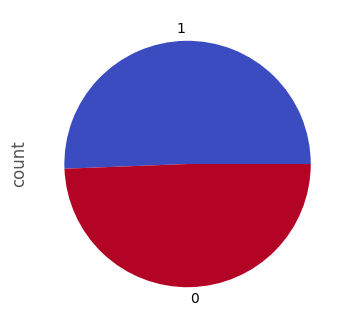

In [181]:
df[TARGET].value_counts().plot(kind="pie", figsize=(6,4), colormap="coolwarm");


Observamos que la columna **'Compra_'+producto** se trata del target, una variable booleana tipo int64 que nos indica si la el cliente ha comprado el producto o no. Cabe destacar que se trata de un target balanceado (porcentaje de prácticamente el 50%) y sin nulos por lo que en principio no deberemos de realizar ningún tipo de rebalanceo de los datos ni eliminación o imputación de filas con nulos.

Comenzamos clasificando las variables según si son categóricas, numéricas o booleanas con la ayuda de una función.

In [182]:
def obtener_lista_variables(dataset):
    lista_numericas = []
    lista_categoricas = []
    lista_booleanas = []

    for i in dataset:
        if (dataset[i].dtype.kind == 'f' or dataset[i].dtype.kind == 'i') and len(dataset[i].unique())!= 2 and (i not in TARGET):
            lista_numericas.append(i)
        if (dataset[i].dtype.kind == 'f' or dataset[i].dtype.kind == 'i') and len(dataset[i].unique()) == 2 and (i not in TARGET):
            lista_booleanas.append(i)
        if (dataset[i].dtype.kind == 'O') and (i not in TARGET):
            lista_categoricas.append(i)

    return lista_numericas,lista_categoricas,lista_booleanas

numericas,categoricas,booleanas = obtener_lista_variables(df)
print(f'Variables numéricas ({len(numericas)}): {numericas}')
print(f'Variables categóricas ({len(categoricas)}):{categoricas}')
print(f'Variables booleanas ({len(booleanas)}):{booleanas}')

Variables numéricas (17): ['age', 'salary', 'entry_date_year', 'entry_date_month', 'pk_partition_month', 'em_acount_consecutive_months', 'pension_plan_consecutive_months', 'payroll_consecutive_months', 'payroll_account_consecutive_months', 'emc_account_consecutive_months', 'credit_card_consecutive_months', 'long_term_deposit_consecutive_months', 'securities_consecutive_months', 'funds_consecutive_months', 'mortgage_consecutive_months', 'num_accounts', 'meses_antigüedad']
Variables categóricas (7):['country_id', 'region_code', 'gender', 'deceased', 'entry_channel', 'segment', 'tipo_cliente']
Variables booleanas (7):['active_customer', 'short_term_deposit_consecutive_months', 'loans_consecutive_months', 'has_credit_card_debt', 'has_savings_investments', 'has_easyMoney_account', 'num_debt_products']


### Análisis categóricas

Al mismo tiempo que identificamos nulos, outliers y datos erróneos vamos a estimar si cada variable es explicativa o no. Para ello, nos enfocaremos en el análisis de una pivot_table que nos aporta los siguientes datos estadísticos: 

- el número total de clientes en cada categoría dentro de una variable
- el número de clientes que ha comprado el producto en cada categoría 
- el porcentaje de compra asociado a cada categoría

En función del número de clientes de cada categoría y lo mucho que su porcentaje de compra se distingue de la media del target (50%), determinaremos si la variable es explicativa o no.

In [183]:
categoricas

['country_id',
 'region_code',
 'gender',
 'deceased',
 'entry_channel',
 'segment',
 'tipo_cliente']

A continuación vamos a definir las tres funciones que nos van a ayudar a analizar cada variable categórica y la relación que guarda cada una de ellas con el target.


- **explore_cat_values** --> nos indica el número de nulos de una columna categórica específica y genera una pivot_table la cual proporciona un resumen estadístico sobre dicha columna y su relación con el Target a través de 3 columnas: ['Num_clientes','Num_compras','Porcentaje_compra']


- **plot_cat_values** --> nos genera dos gráficas que nos ayudan a analizar tanto la distribución de las distintas categorías dentro de la variable como la distribución del Target dentro de cada una de esas categorías.


- **analisis_cat** --> incorpora las dos funciones anteriores y realiza un análisis exploratorio de una columna categórica específica en un dataframe, incluyendo visualización y resumen estadístico.

In [184]:
def explore_cat_values(dataframe, column, target_col):
    """
    Genera un resumen estadístico sobre una columna categórica específica del dataframe y su relación con el Target.

    Parámetros:
    dataframe (pd.DataFrame): El dataframe que contiene los datos.
    column (str): El nombre de la columna categórica a explorar.
    target_col (str): El nombre de la columna Target que se analizará en relación con la columna categórica.

    Retorna:
    pd.DataFrame: Un dataframe que contiene el resumen de la columna categórica, incluyendo:
                  - 'Num_clientes': El número de ocurrencias de cada categoría.
                  - 'Num_compras': La suma de los valores en la columna objetivo para cada categoría.
                  - 'Porcentaje_compra': El promedio de los valores en la columna objetivo para cada categoría, indicando el porcentaje de compra.
    """

    resumen_df = dataframe.pivot_table(index=column, values=target_col, aggfunc=[len,'sum','mean'],observed=False)
    resumen_df.columns = ['Num_clientes', 'Num_compras','Porcentaje_compra']
    resumen_df = resumen_df.sort_values(by='Num_clientes',ascending=False)
    return resumen_df

In [185]:
def plot_cat_values(dataframe, column, target_column):
    """
    Genera un gráfico de barras para visualizar la relación entre una variable categórica y el Target.

    Parámetros:
    dataframe (pd.DataFrame): El dataframe que contiene los datos.
    column (str): El nombre de la columna categórica a explorar.
    target_column (str): El nombre de la columna Target que se analizará en relación con la columna categórica.

    Retorna:
    None: La función muestra un gráfico de barras y no devuelve ningún valor.
    """
    plt.figure(figsize=(10,4))
    
    # Gráfico que muestra la distribución del target en cada categoría de la variable categórica
    ax1 = sns.countplot(data=dataframe, x=column, hue=target_column, order=list(dataframe[column].unique()))
    ax1.set_xticklabels(ax1.get_xticklabels(), rotation=70)

    plt.tight_layout()
    plt.show();

In [186]:
def analisis_cat(dataframe, column, target_column):

    """
    Realiza un análisis exploratorio de una columna categórica específica en un dataframe, incluyendo visualización y resumen estadístico.

    Parámetros:
    dataframe (pd.DataFrame): El dataframe que contiene los datos.
    column (str): El nombre de la columna categórica a explorar.
    target_column (str): El nombre de la columna Target que se analizará en relación con la columna categórica.

    Retorna:
    pd.DataFrame: Un dataframe que contiene el resumen de la columna categórica, incluyendo:
                  - 'Num_clientes': El número de ocurrencias de cada categoría.
                  - 'Num_compras': La suma de los valores en la columna objetivo para cada categoría.
                  - 'Porcentaje_compra': El promedio de los valores en la columna objetivo para cada categoría, indicando el porcentaje de compra.
    """
    
    plot_cat_values(dataframe, column, target_column)
    return explore_cat_values(dataframe, column, target_column)

#### country_id

c:\Users\USUARIO\AppData\Local\Programs\Python\Python312\Lib\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
c:\Users\USUARIO\AppData\Local\Programs\Python\Python312\Lib\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\Users\USUARIO\AppData\Local\Temp\ipykernel_8328\138647495.py:17: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(ax1.get_xticklabels(), rotation=70)


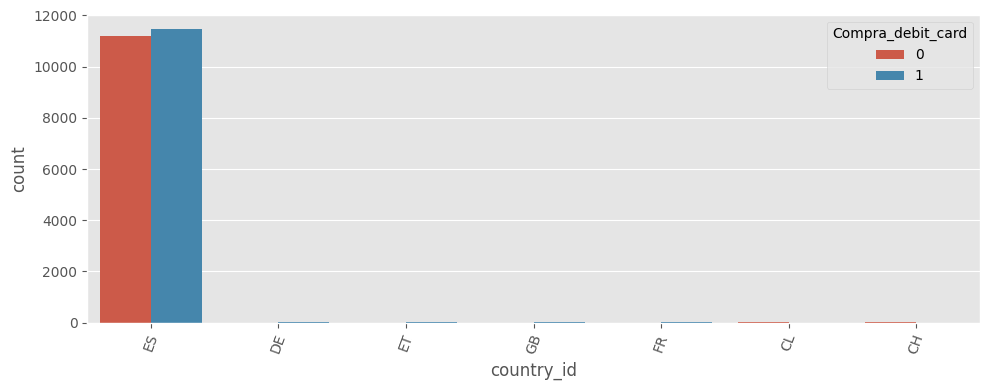

,Num_clientes,Num_compras,Porcentaje_compra
country_id,,,
ES,22644,11458,0.506006
GB,3,3,1.000000
DE,2,2,1.000000
CH,1,0,0.000000
CL,1,0,0.000000
ET,1,1,1.000000
FR,1,1,1.000000


In [187]:
analisis_cat(df, 'country_id', TARGET)

In [188]:
# la consideramos no explicativa debido a la poca varianza de la misma respecto del target, a parte su contenido está intrínseco en su
# mayoría en region_code

no_explicativas.append('country_id')

#### region_code

c:\Users\USUARIO\AppData\Local\Programs\Python\Python312\Lib\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
c:\Users\USUARIO\AppData\Local\Programs\Python\Python312\Lib\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\Users\USUARIO\AppData\Local\Temp\ipykernel_8328\138647495.py:17: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(ax1.get_xticklabels(), rotation=70)


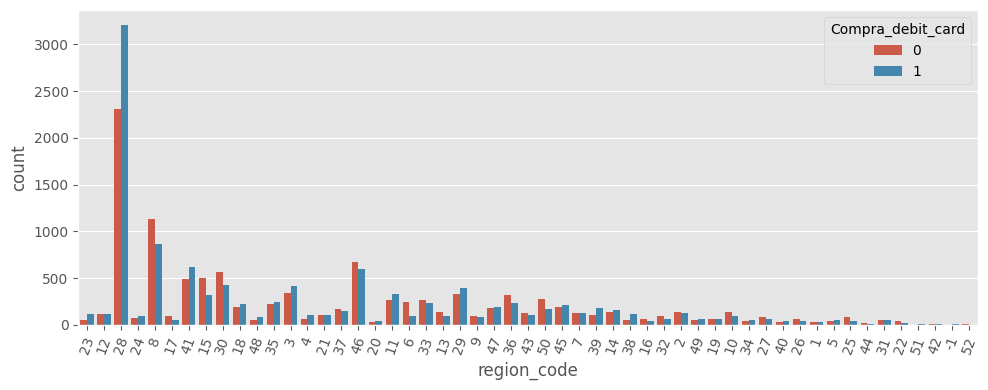

,Num_clientes,Num_compras,Porcentaje_compra
region_code,,,
28,5519,3208,0.581265
8,1992,862,0.432731
46,1279,602,0.470680
41,1113,617,0.554358
30,987,424,0.429585
15,823,316,0.383961
3,757,419,0.553501
29,733,398,0.542974
11,598,334,0.558528


In [189]:
analisis_cat(df, 'region_code', TARGET)

Debido al gran número de categorías vamos a realizar lo que se conoce como un target_encoding. Esto consiste en reemplazar los valores categóricos de la variable por un valor numérico, en este caso, el porcentaje de compra asociado a cada región. Esto mantiene la relación directa entre la región y el target sin aumentar mucho la dimensionalidad del modelo (no hay necesidad de aplicar OHE a la variable)

In [190]:
# Cálculo de la tasa de compra por región
region_target_mean = df.groupby('region_code')[TARGET].mean()

# Reemplaza la variable de región con la tasa media de compra por región
df['region_encoded'] = df['region_code'].map(region_target_mean)

# añadimos la variable original a la lista de variables no explicativas
no_explicativas.append('region_code')

#### gender

c:\Users\USUARIO\AppData\Local\Programs\Python\Python312\Lib\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
c:\Users\USUARIO\AppData\Local\Programs\Python\Python312\Lib\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\Users\USUARIO\AppData\Local\Temp\ipykernel_8328\138647495.py:17: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(ax1.get_xticklabels(), rotation=70)


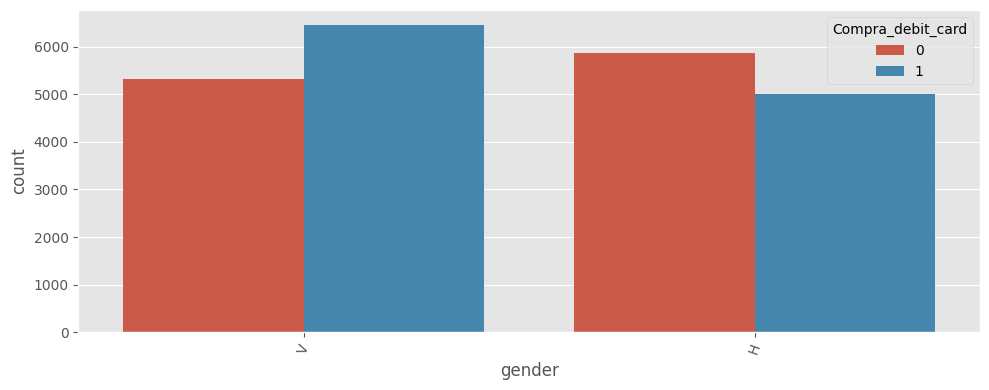

,Num_clientes,Num_compras,Porcentaje_compra
gender,,,
V,11773,6451,0.547949
H,10880,5014,0.460846


In [191]:
analisis_cat(df, 'gender', TARGET)

#### deceased

c:\Users\USUARIO\AppData\Local\Programs\Python\Python312\Lib\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
c:\Users\USUARIO\AppData\Local\Programs\Python\Python312\Lib\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\Users\USUARIO\AppData\Local\Temp\ipykernel_8328\138647495.py:17: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(ax1.get_xticklabels(), rotation=70)


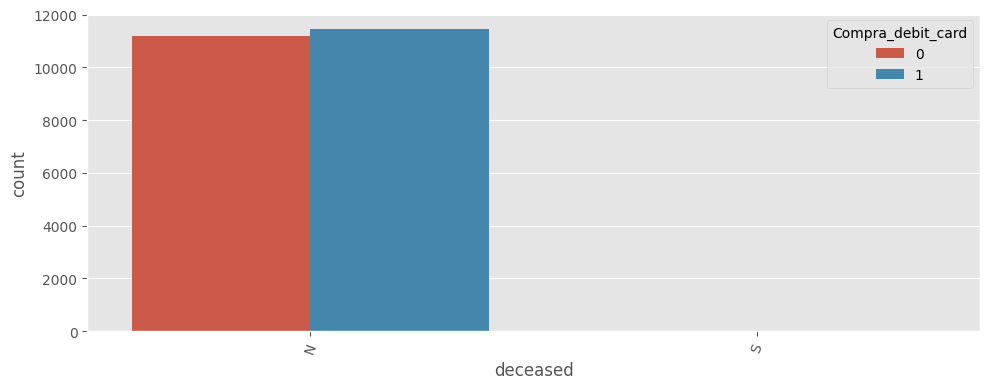

,Num_clientes,Num_compras,Porcentaje_compra
deceased,,,
N,22651,11465,0.506159
S,2,0,0.000000


In [192]:
analisis_cat(df, 'deceased', TARGET)

In [193]:
# tenemos solo dos fallecidos por lo que la consideramos variable no explicativa

no_explicativas.append('deceased')

#### segment

c:\Users\USUARIO\AppData\Local\Programs\Python\Python312\Lib\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
c:\Users\USUARIO\AppData\Local\Programs\Python\Python312\Lib\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\Users\USUARIO\AppData\Local\Temp\ipykernel_8328\138647495.py:17: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(ax1.get_xticklabels(), rotation=70)


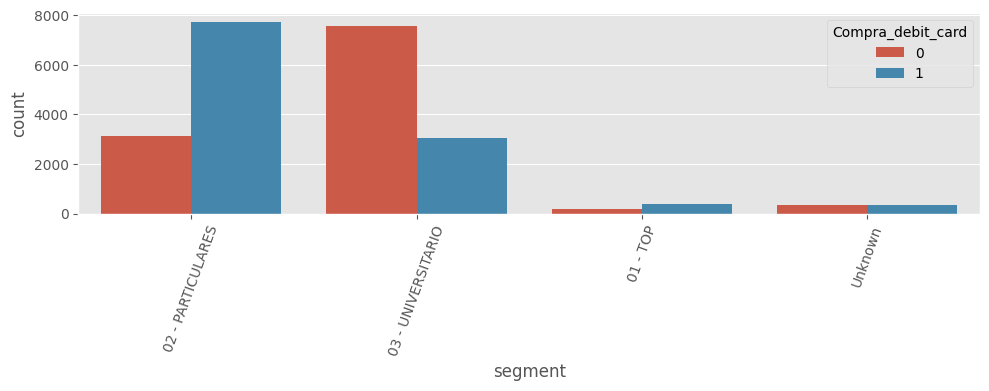

,Num_clientes,Num_compras,Porcentaje_compra
segment,,,
02 - PARTICULARES,10832,7717,0.712426
03 - UNIVERSITARIO,10590,3029,0.286025
Unknown,677,340,0.502216
01 - TOP,554,379,0.684116


In [194]:
analisis_cat(df, 'segment', TARGET)

In [195]:
# ponemos la variable más bonita

df['segment'] = np.where(df['segment']=='03 - UNIVERSITARIO','Universitario',df['segment'])
df['segment'] = np.where(df['segment']=='02 - PARTICULARES','Particulares',df['segment'])
df['segment'] = np.where(df['segment']=='01 - TOP','Top',df['segment'])

df['segment'].value_counts()

segment
Particulares     10832
Universitario    10590
Unknown            677
Top                554
Name: count, dtype: int64

#### entry_channel

c:\Users\USUARIO\AppData\Local\Programs\Python\Python312\Lib\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
c:\Users\USUARIO\AppData\Local\Programs\Python\Python312\Lib\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\Users\USUARIO\AppData\Local\Temp\ipykernel_8328\138647495.py:17: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(ax1.get_xticklabels(), rotation=70)


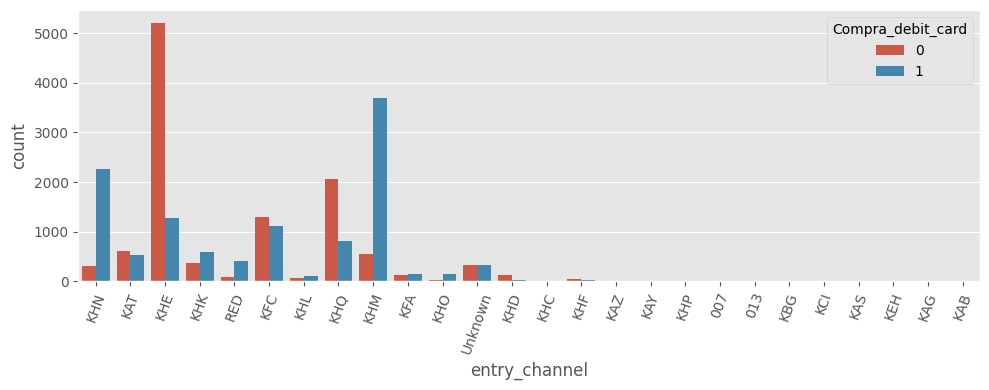

,Num_clientes,Num_compras,Porcentaje_compra
entry_channel,,,
KHE,6485,1274,0.196453
KHM,4241,3696,0.871493
KHQ,2855,802,0.280911
KHN,2557,2259,0.883457
KFC,2409,1118,0.464093
KAT,1147,536,0.467306
KHK,950,591,0.622105
Unknown,669,336,0.502242
RED,503,414,0.823062


In [196]:
analisis_cat(df, 'entry_channel', TARGET)

In [197]:
# agrupamos aquellos canales con menos de 200 clientes bajo el nombre de Others

def setOthers(dataframe, column, min_count):
    """
    Esta función toma una columna categórica en un DataFrame y reemplaza aquellas categorías cuya frecuencia es 
    menor que un umbral especificado (`min_count`) con la categoría 'Others'. Luego, la columna se convierte en 
    un tipo categórico con las categorías filtradas y 'Others'. Finalmente, las categorías no especificadas 
    explícitamente son reemplazadas por 'Others'.

    Parámetros:
    df (pd.DataFrame): El DataFrame que contiene la columna a transformar.
    columna (str): El nombre de la columna en el DataFrame que queremos transformar.
    min_count (int): El umbral de frecuencia mínima, es decir, el número mínimo de máquinas que una categoría debe tener para no ser agrupada en 'Others'.
    
    Retorna:
    pd.Series: Una Serie con la columna transformada, donde las categorías con frecuencia menor que `min_count` se han agrupado bajo 'Others'.
    """
    # Obtener el recuento de valores de la columna
    value_counts = dataframe[column].value_counts()
    # Filtrar las categorías que superan el umbral (min_count)
    top_categories = value_counts[value_counts >= min_count].index.to_list()
    # Añadir la categoría 'Others' al listado
    top_categories.append('Others')
    dataframe[column] = pd.Categorical(dataframe[column], categories=top_categories)
    # asignar a los nulos (categorías que no se encuentran en el top_categories) la categoría Others
    dataframe[column] = dataframe[column].fillna('Others')
    return dataframe[column]

setOthers(df, 'entry_channel', 200)
explore_cat_values(df,'entry_channel',TARGET)

,Num_clientes,Num_compras,Porcentaje_compra
entry_channel,,,
KHE,6485,1274,0.196453
KHM,4241,3696,0.871493
KHQ,2855,802,0.280911
KHN,2557,2259,0.883457
KFC,2409,1118,0.464093
KAT,1147,536,0.467306
KHK,950,591,0.622105
Unknown,669,336,0.502242
Others,576,295,0.512153


#### tipo_cliente

c:\Users\USUARIO\AppData\Local\Programs\Python\Python312\Lib\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
c:\Users\USUARIO\AppData\Local\Programs\Python\Python312\Lib\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\Users\USUARIO\AppData\Local\Temp\ipykernel_8328\138647495.py:17: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(ax1.get_xticklabels(), rotation=70)


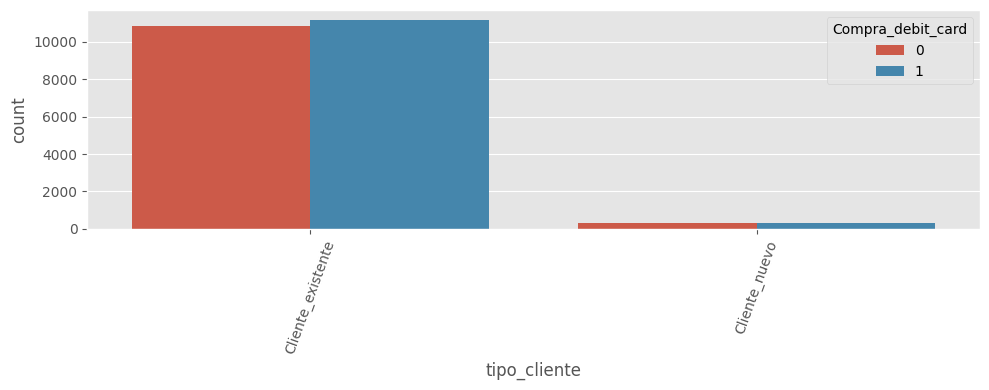

,Num_clientes,Num_compras,Porcentaje_compra
tipo_cliente,,,
Cliente_existente,22003,11142,0.506385
Cliente_nuevo,650,323,0.496923


In [198]:
analisis_cat(df, 'tipo_cliente', TARGET)

### Análisis numéricas

In [199]:
numericas

['age',
 'salary',
 'entry_date_year',
 'entry_date_month',
 'pk_partition_month',
 'em_acount_consecutive_months',
 'pension_plan_consecutive_months',
 'payroll_consecutive_months',
 'payroll_account_consecutive_months',
 'emc_account_consecutive_months',
 'credit_card_consecutive_months',
 'long_term_deposit_consecutive_months',
 'securities_consecutive_months',
 'funds_consecutive_months',
 'mortgage_consecutive_months',
 'num_accounts',
 'meses_antigüedad']

Creamos una fución que nos permite plotear un histograma y dos boxplots que nos ayudaran a obtener información útil sobre la distribución de las variables numéricas y su relación con el target. El primer boxplot indica la distribución de la variable numérica y el segundo nos muestra la distribución de dicha variable en relación con el target.

In [200]:
def plot_num(dataframe, column, target_column):
    """
    Genera tres gráficos para visualizar la distribución de una variable numérica y su relación con una variable objetivo.

    Parámetros:
    dataframe (pd.DataFrame): El dataframe que contiene los datos.
    column (str): El nombre de la columna numérica a explorar.
    target_column (str): El nombre de la columna objetivo que se analizará en relación con la columna numérica.

    Retorna:
    None: La función muestra tres gráficos y no devuelve ningún valor.

    Descripción:
    La función genera una figura con tres subplots:
    - El primer subplot muestra un histograma de la distribución de la variable numérica.
    - El segundo subplot muestra un diagrama de cajas (boxplot) de la variable numérica.
    - El tercer subplot muestra un diagrama de violines (violinplot) de la variable objetivo en relación con la variable numérica.
    """
    plt.figure(figsize=(22,9))
    
    # Primer gráfico: Histograma de la distribución de la variable numérica
    ax1 = plt.subplot(3,1,1)
    sns.histplot(data=dataframe, x=column, bins=30, ax=ax1)
    ax1.set_xlabel('')
    
    # Segundo gráfico: Boxplot de la variable numérica
    ax2 = plt.subplot(3,1,2)
    sns.boxplot(data=dataframe, x=column, ax=ax2)
    ax2.set_xlabel('')
    
    # Tercer gráfico: Boxplot de la variable objetivo en relación con la variable numérica
    ax3 = plt.subplot(3,1,3)
    sns.violinplot(data=dataframe, x=target_column, y=column, ax=ax3)
    
    plt.tight_layout()
    plt.show()

#### age

c:\Users\USUARIO\AppData\Local\Programs\Python\Python312\Lib\site-packages\seaborn\categorical.py:632: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)
c:\Users\USUARIO\AppData\Local\Programs\Python\Python312\Lib\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
c:\Users\USUARIO\AppData\Local\Programs\Python\Python312\Lib\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


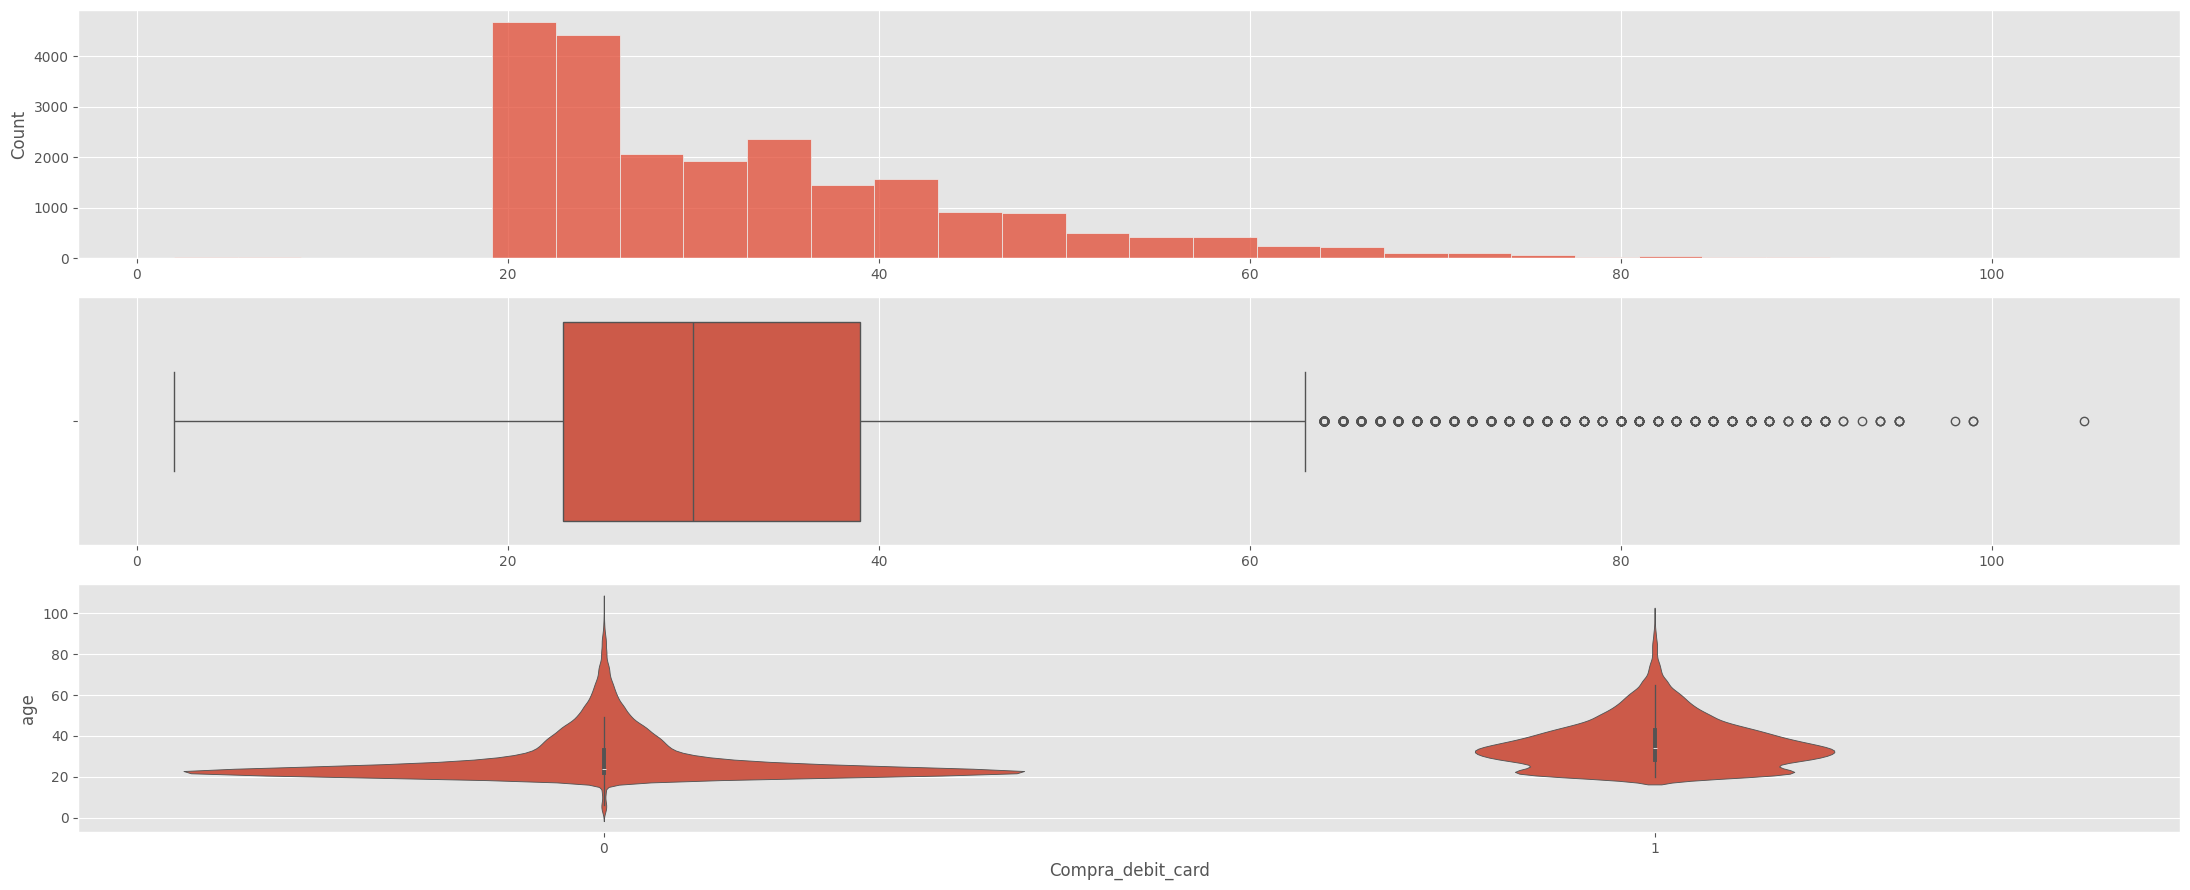

In [201]:
plot_num(df, 'age', TARGET)

#### salary

c:\Users\USUARIO\AppData\Local\Programs\Python\Python312\Lib\site-packages\seaborn\categorical.py:632: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)
c:\Users\USUARIO\AppData\Local\Programs\Python\Python312\Lib\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
c:\Users\USUARIO\AppData\Local\Programs\Python\Python312\Lib\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


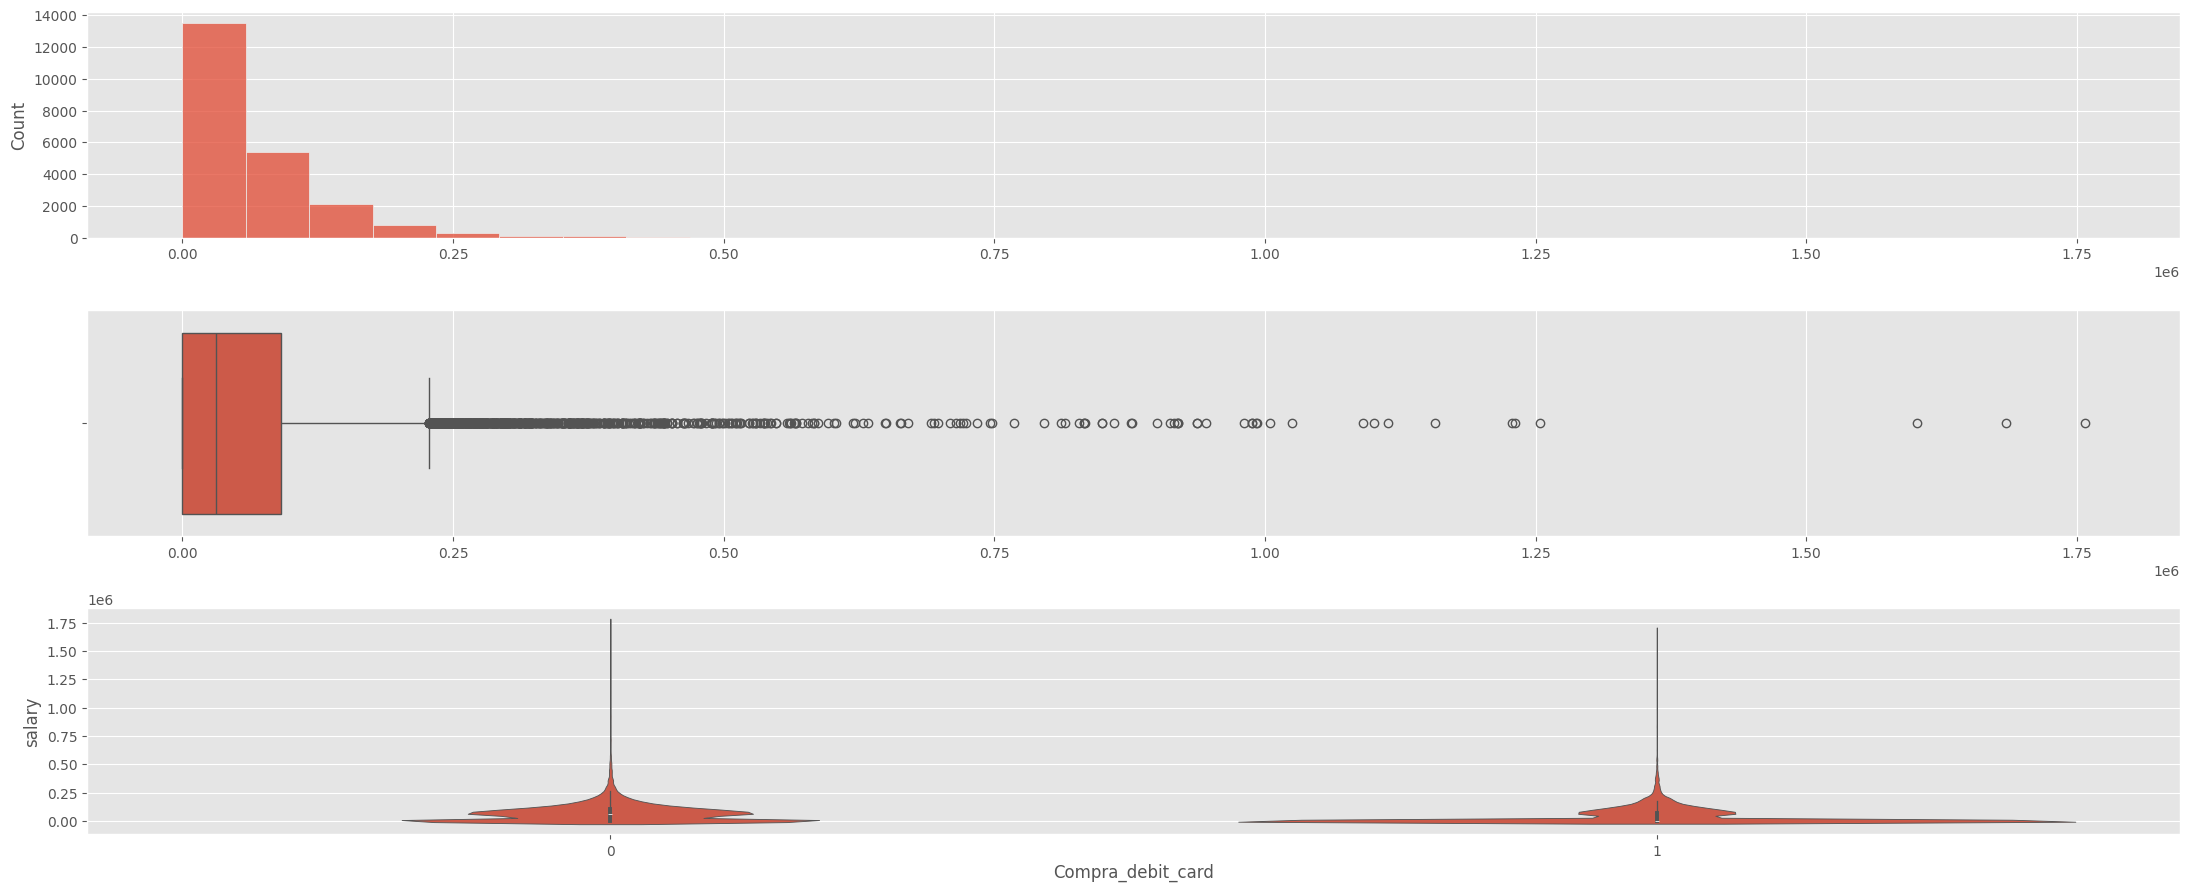

In [202]:
plot_num(df[df['salary']<2e6], 'salary', TARGET)

#### entry_date_year

c:\Users\USUARIO\AppData\Local\Programs\Python\Python312\Lib\site-packages\seaborn\categorical.py:632: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)
c:\Users\USUARIO\AppData\Local\Programs\Python\Python312\Lib\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
c:\Users\USUARIO\AppData\Local\Programs\Python\Python312\Lib\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


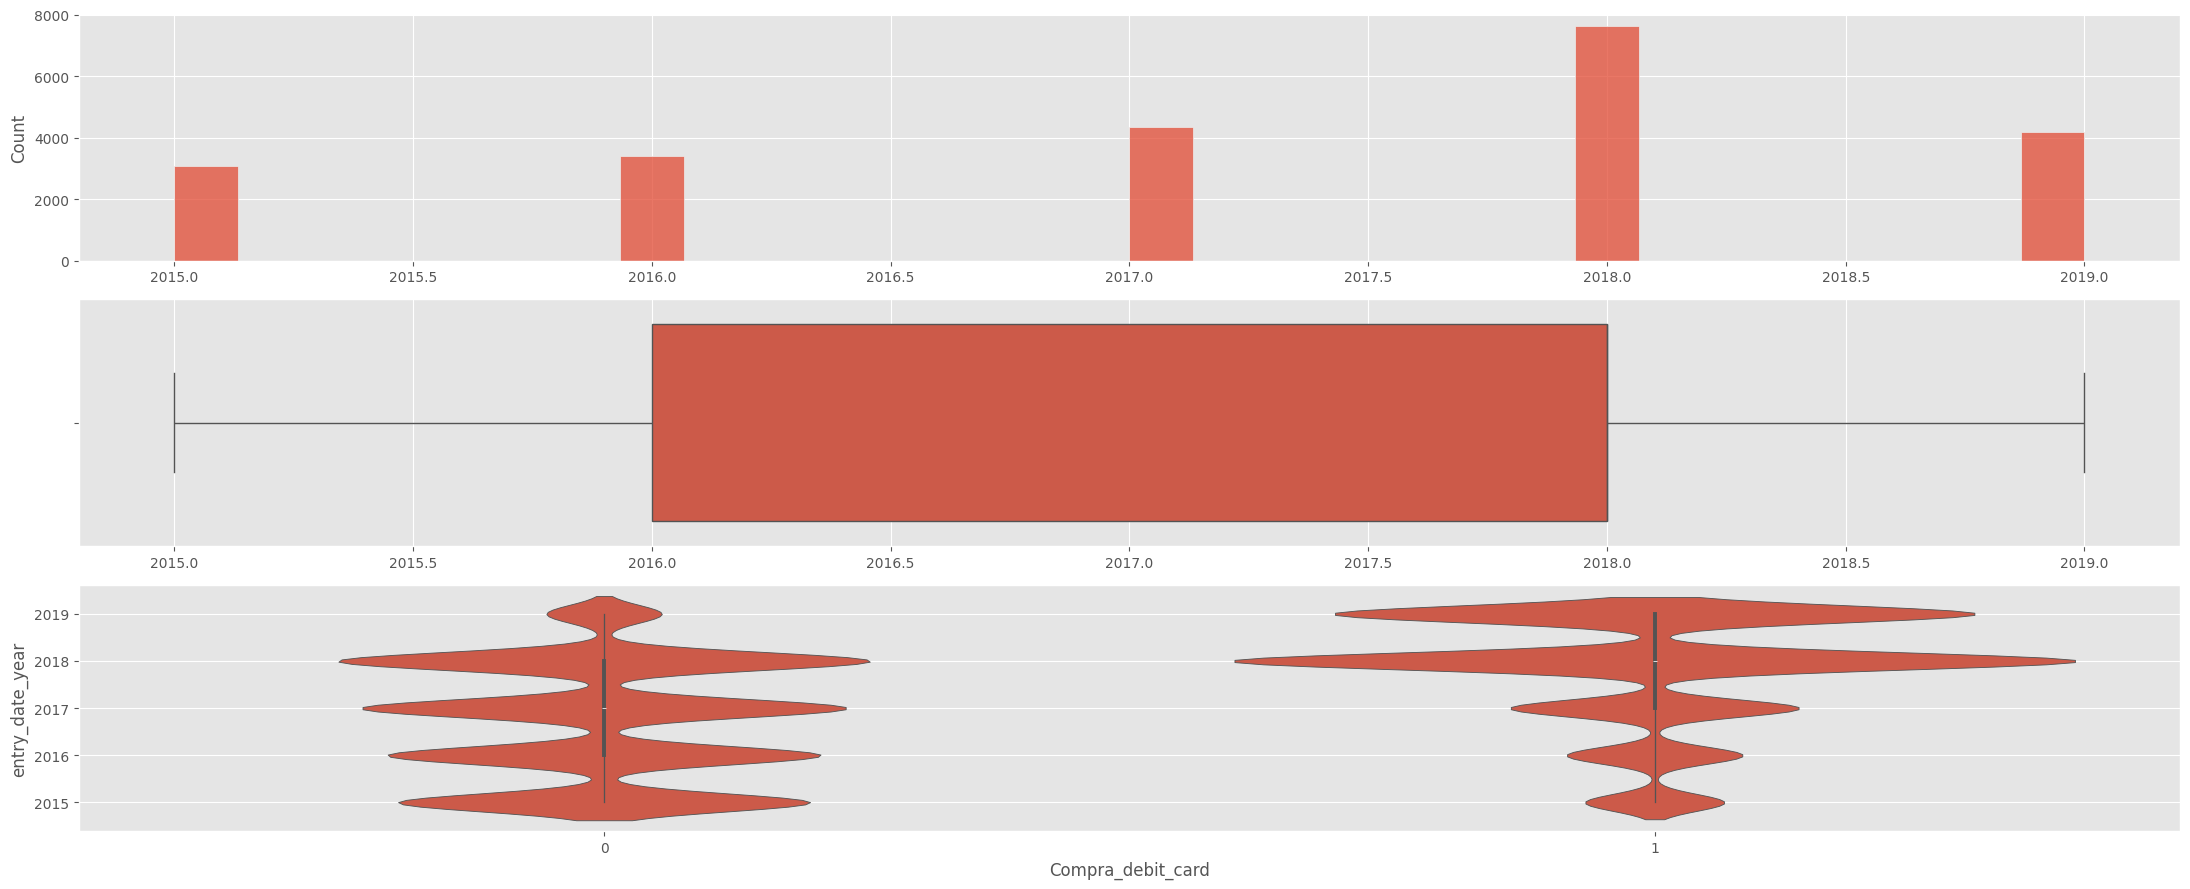

In [203]:
plot_num(df, 'entry_date_year', TARGET)

#### entry_date_month

c:\Users\USUARIO\AppData\Local\Programs\Python\Python312\Lib\site-packages\seaborn\categorical.py:632: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)
c:\Users\USUARIO\AppData\Local\Programs\Python\Python312\Lib\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
c:\Users\USUARIO\AppData\Local\Programs\Python\Python312\Lib\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


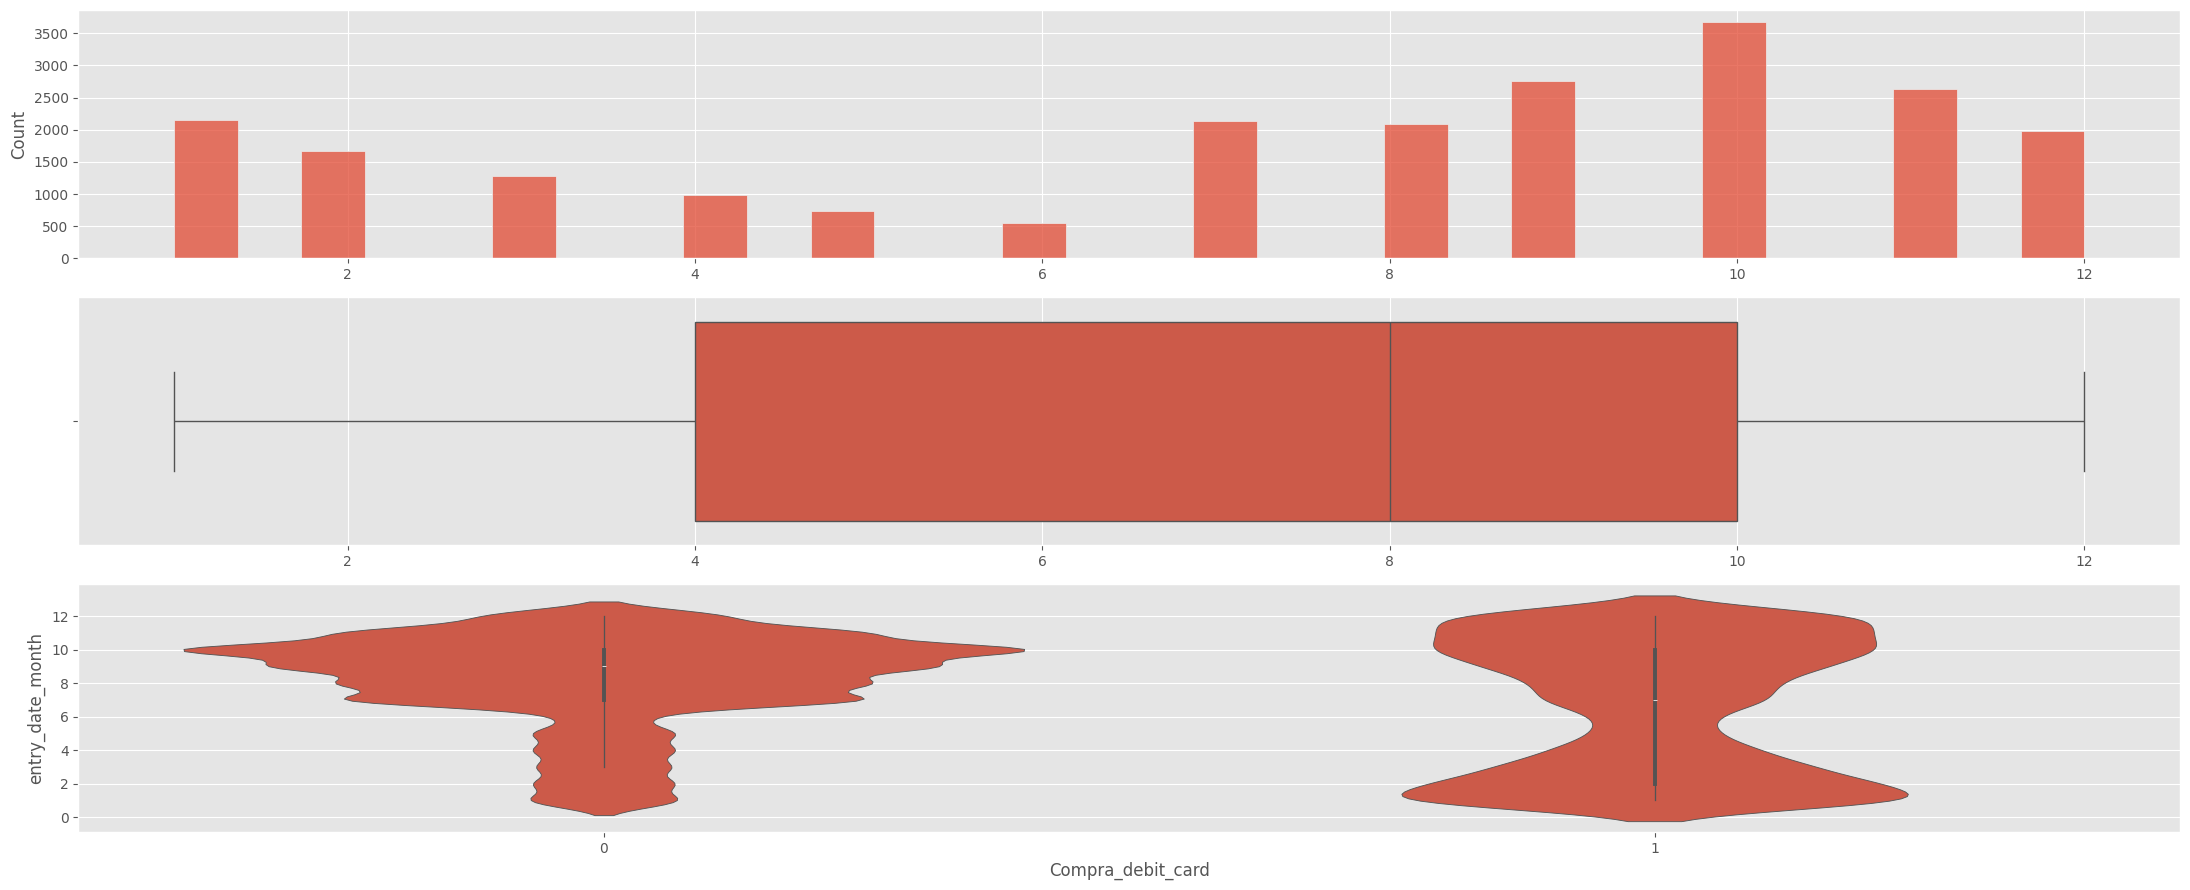

In [204]:
plot_num(df, 'entry_date_month', TARGET)

#### pk_partition_month

c:\Users\USUARIO\AppData\Local\Programs\Python\Python312\Lib\site-packages\seaborn\categorical.py:632: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)
c:\Users\USUARIO\AppData\Local\Programs\Python\Python312\Lib\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
c:\Users\USUARIO\AppData\Local\Programs\Python\Python312\Lib\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


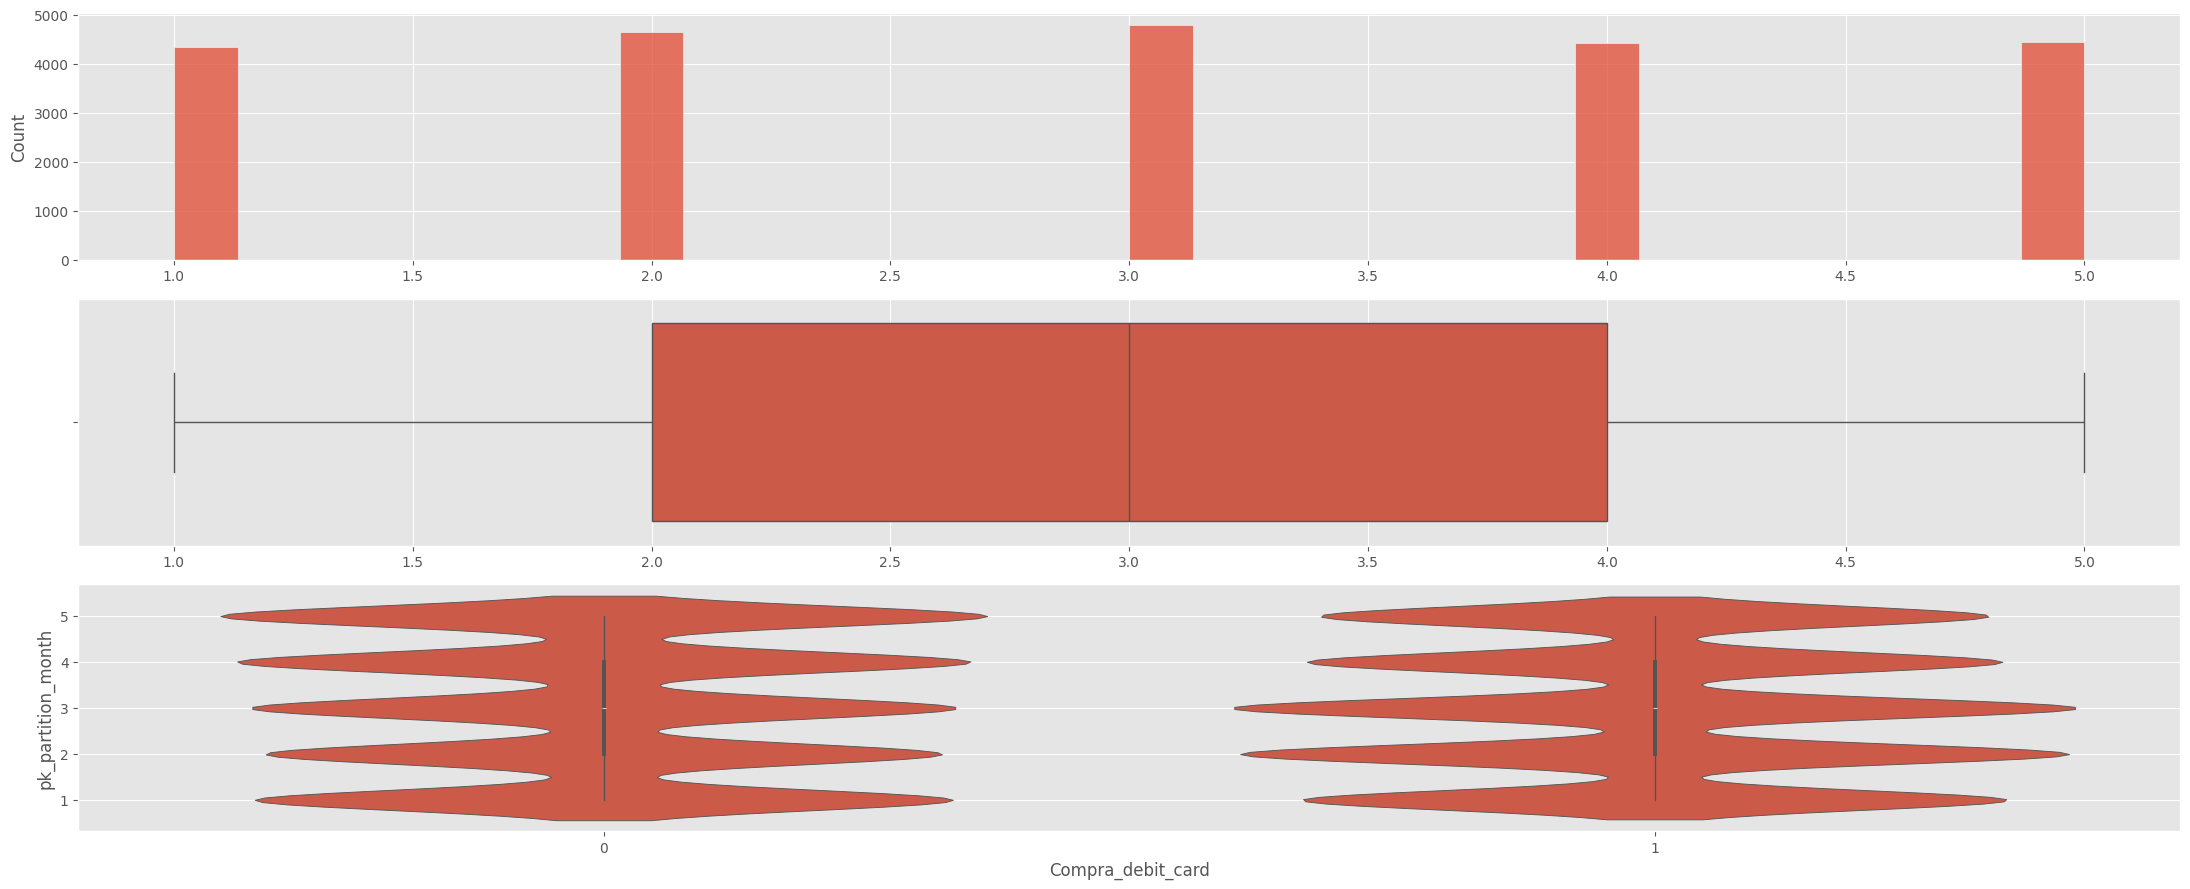

In [205]:
plot_num(df, 'pk_partition_month', TARGET)

In [206]:
# vemos que los violinplots no se diferencian mucho lo que indica que el mes no influye mucho en el TARGET

no_explicativas.append('pk_partition_month')

#### em_acount_consecutive_months

c:\Users\USUARIO\AppData\Local\Programs\Python\Python312\Lib\site-packages\seaborn\categorical.py:632: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)
c:\Users\USUARIO\AppData\Local\Programs\Python\Python312\Lib\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
c:\Users\USUARIO\AppData\Local\Programs\Python\Python312\Lib\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


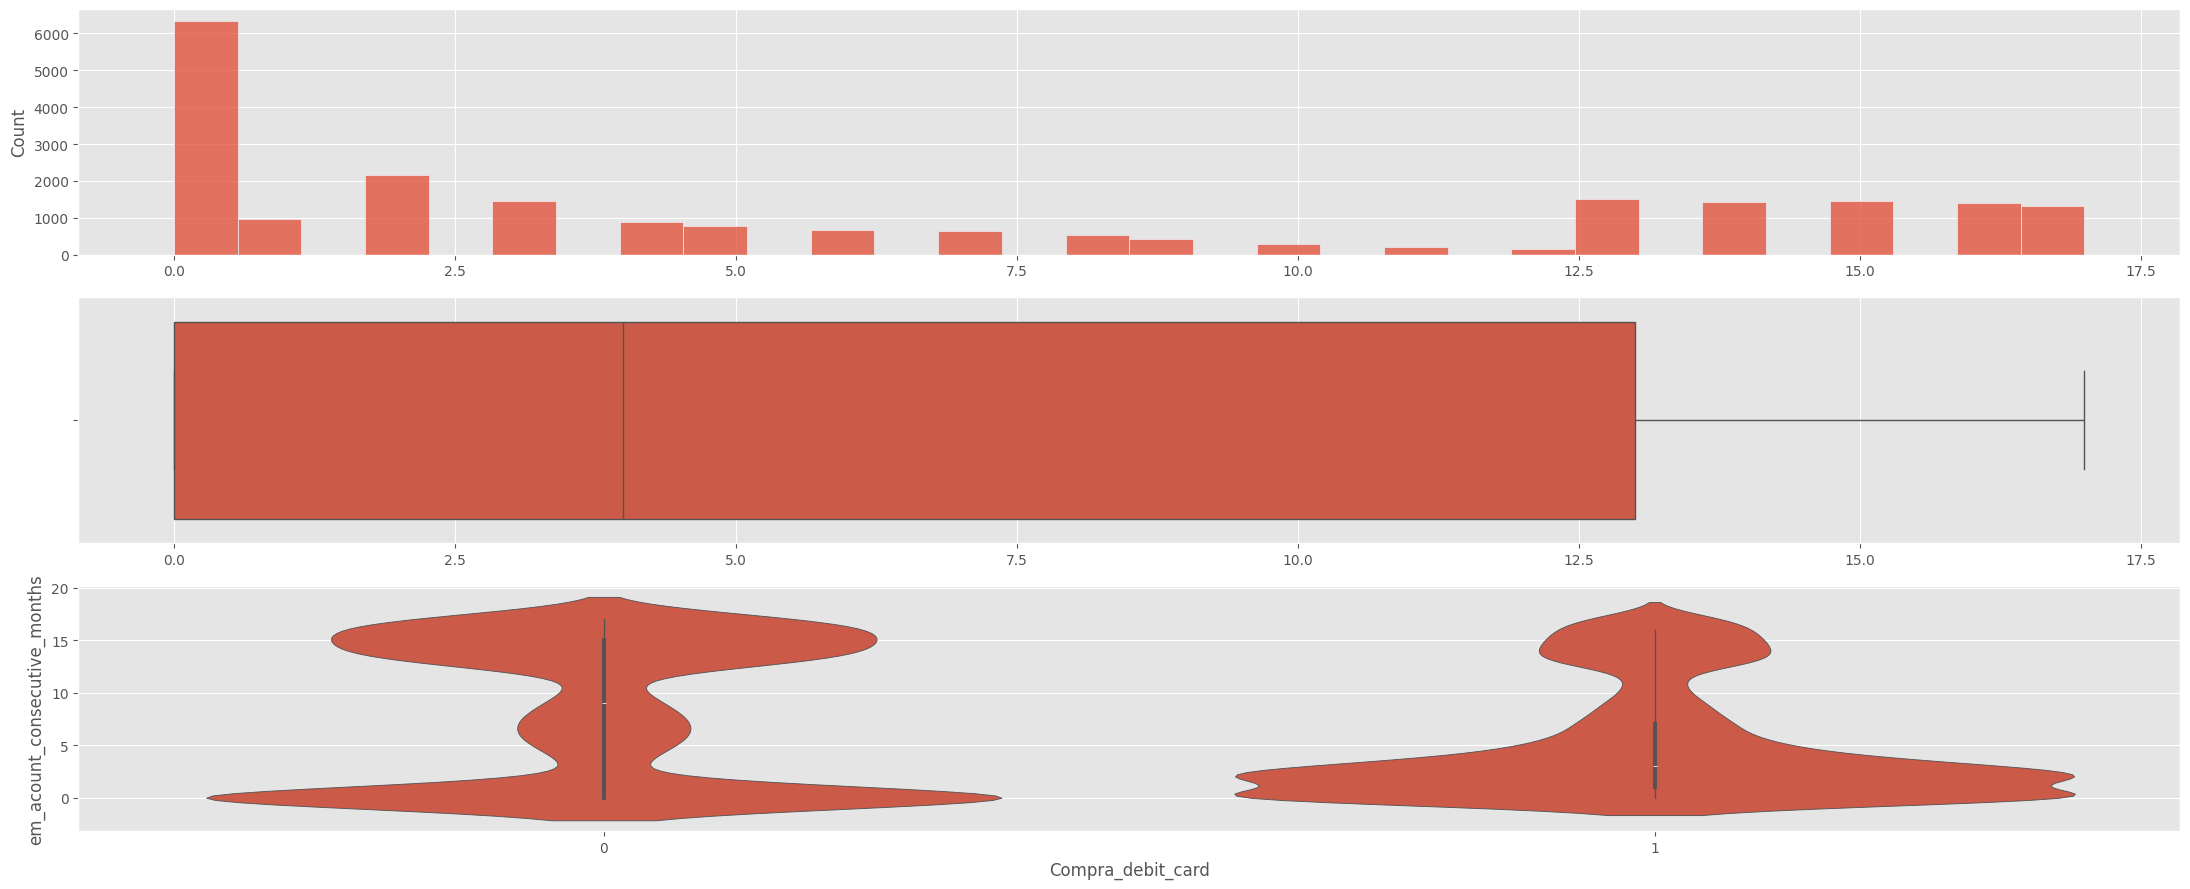

In [207]:
plot_num(df, 'em_acount_consecutive_months', TARGET)

#### pension_plan_consecutive_months

c:\Users\USUARIO\AppData\Local\Programs\Python\Python312\Lib\site-packages\seaborn\categorical.py:632: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)
c:\Users\USUARIO\AppData\Local\Programs\Python\Python312\Lib\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
c:\Users\USUARIO\AppData\Local\Programs\Python\Python312\Lib\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


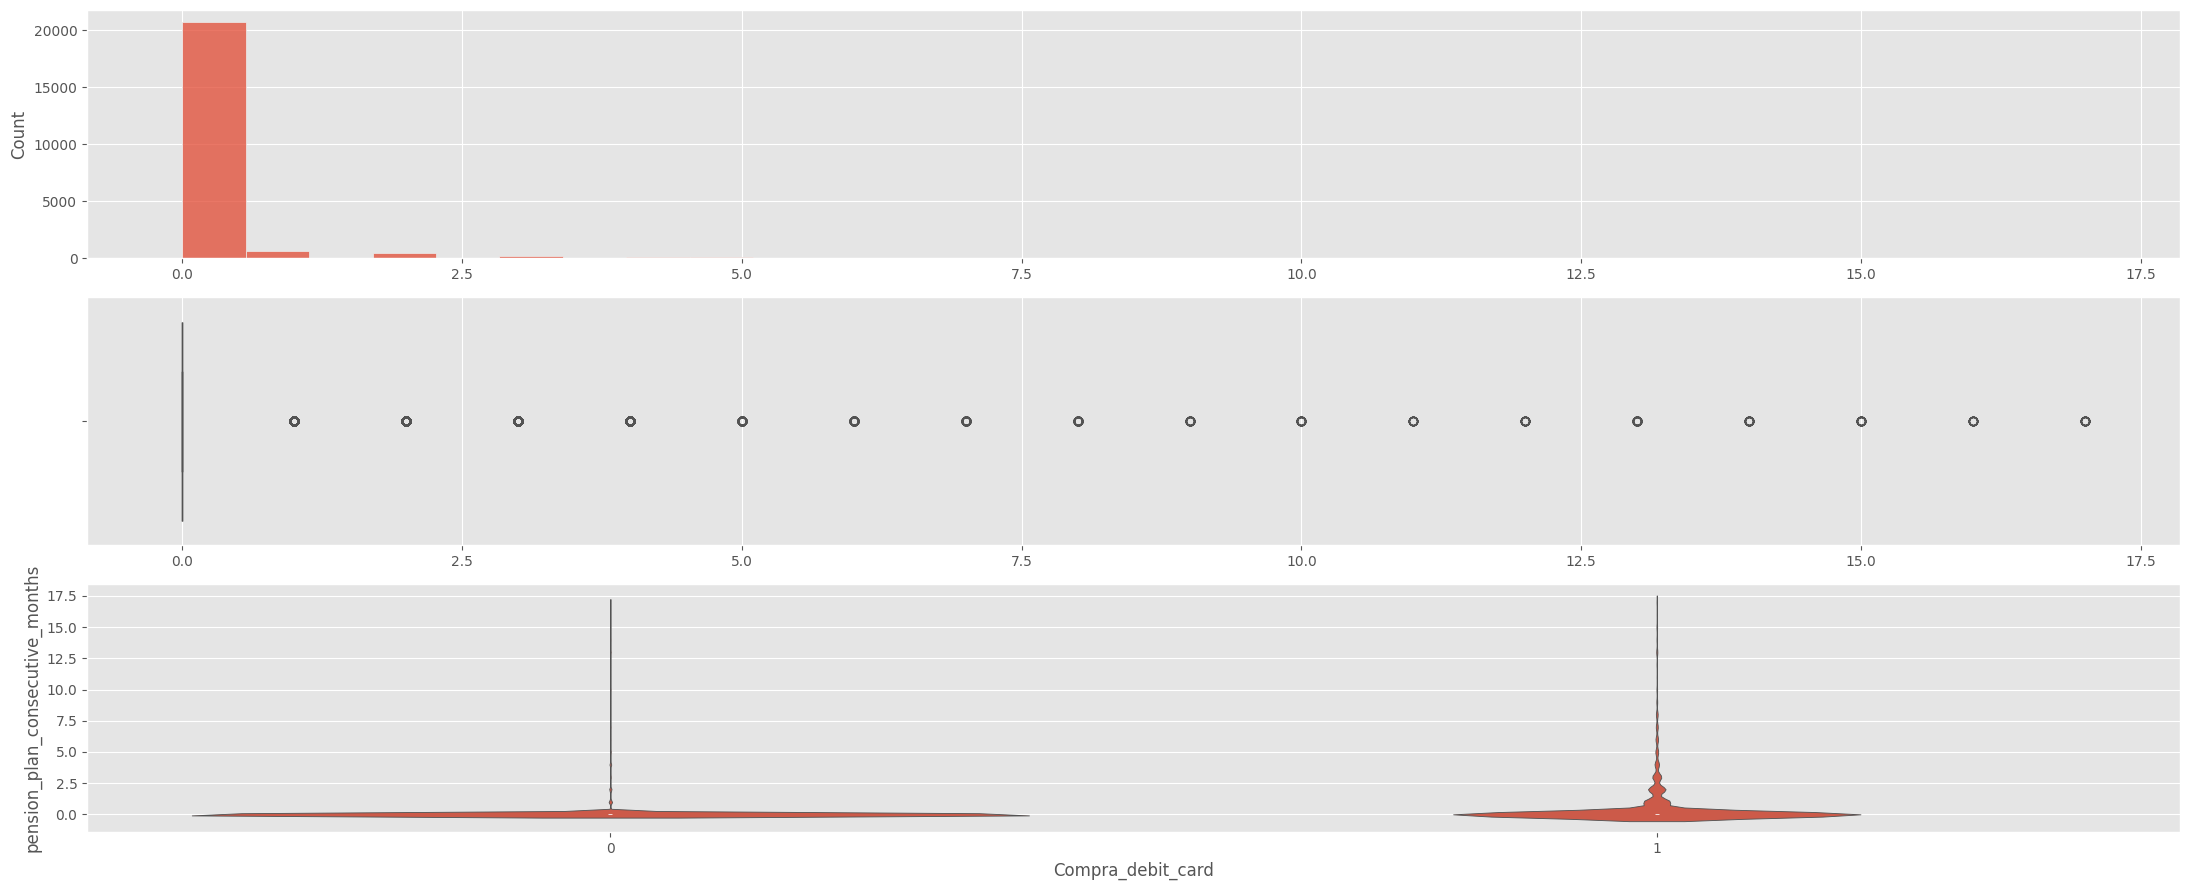

In [208]:
plot_num(df, 'pension_plan_consecutive_months', TARGET)

In [209]:
df['pension_plan_consecutive_months'].value_counts()

pension_plan_consecutive_months
0     20751
1       678
2       447
3       230
4       127
5        80
6        67
7        55
8        47
13       36
9        24
10       23
14       20
15       19
17       15
12       14
11       10
16       10
Name: count, dtype: int64

#### payroll_consecutive_months

c:\Users\USUARIO\AppData\Local\Programs\Python\Python312\Lib\site-packages\seaborn\categorical.py:632: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)
c:\Users\USUARIO\AppData\Local\Programs\Python\Python312\Lib\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
c:\Users\USUARIO\AppData\Local\Programs\Python\Python312\Lib\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


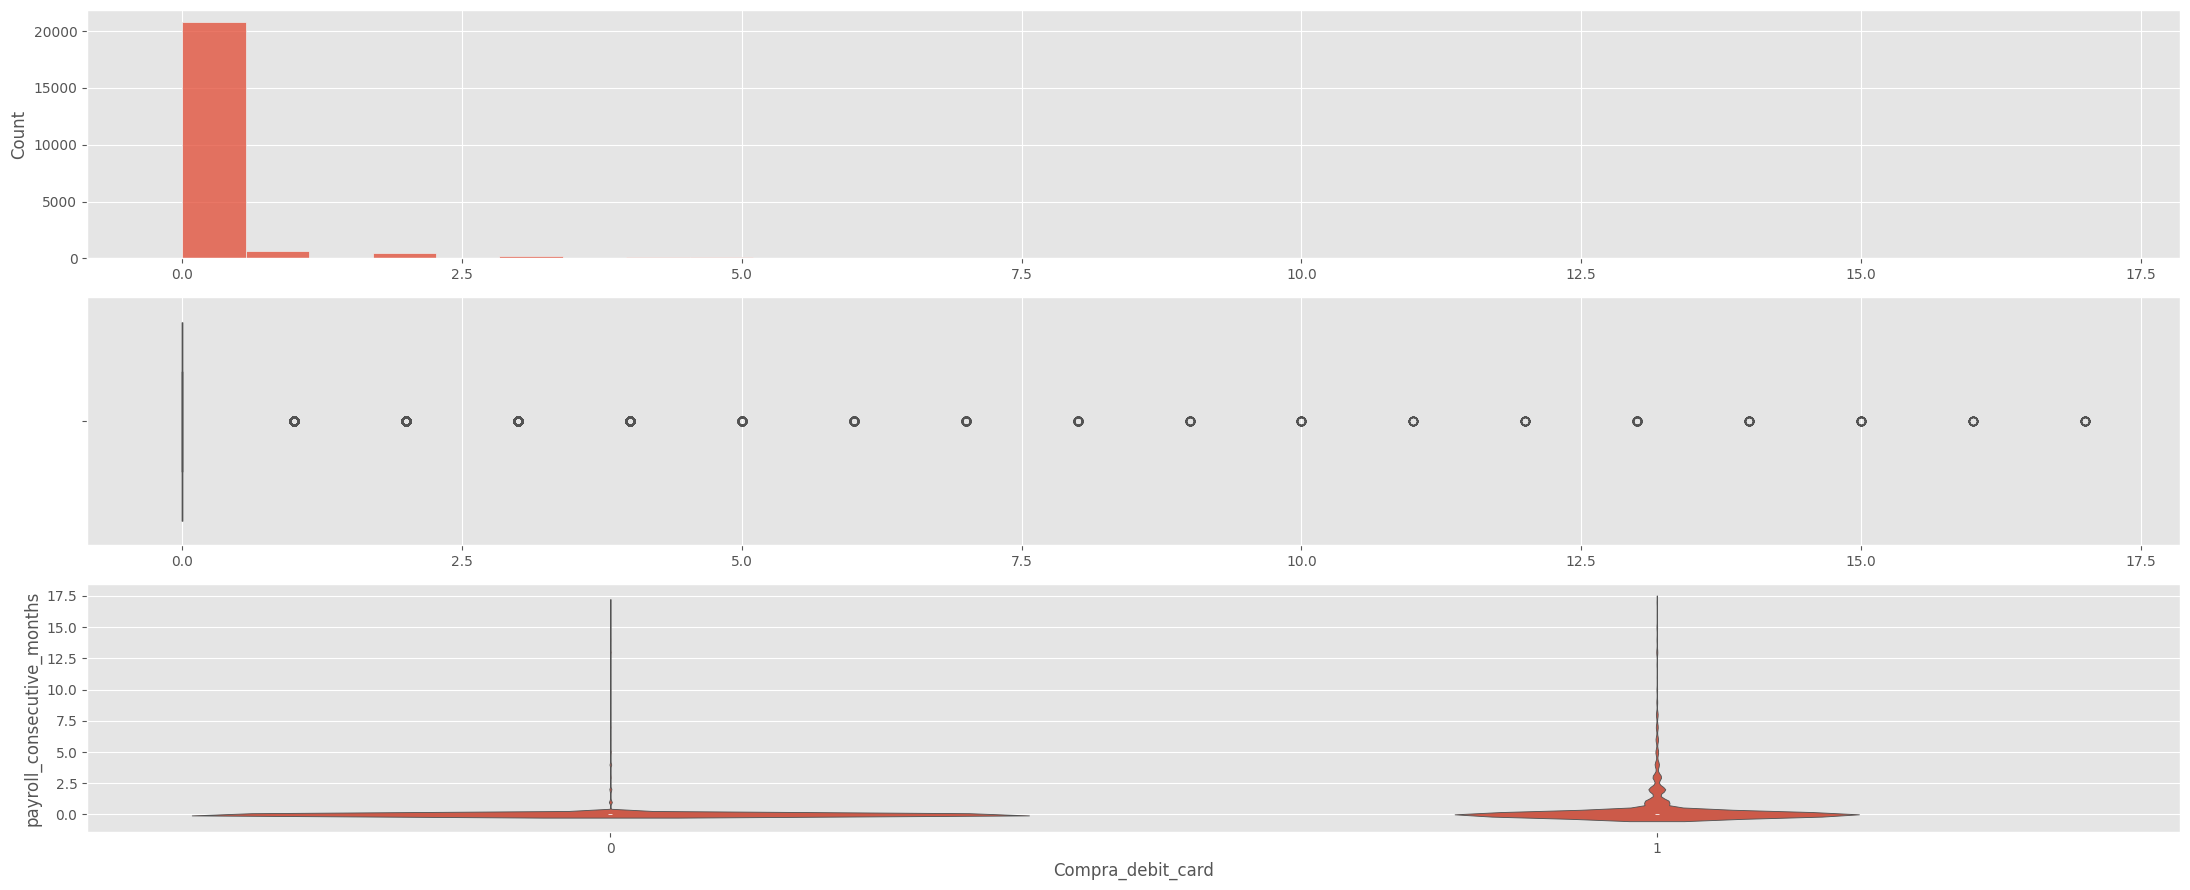

In [210]:
plot_num(df, 'payroll_consecutive_months', TARGET)

#### payroll_account_consecutive_months

c:\Users\USUARIO\AppData\Local\Programs\Python\Python312\Lib\site-packages\seaborn\categorical.py:632: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)
c:\Users\USUARIO\AppData\Local\Programs\Python\Python312\Lib\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
c:\Users\USUARIO\AppData\Local\Programs\Python\Python312\Lib\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


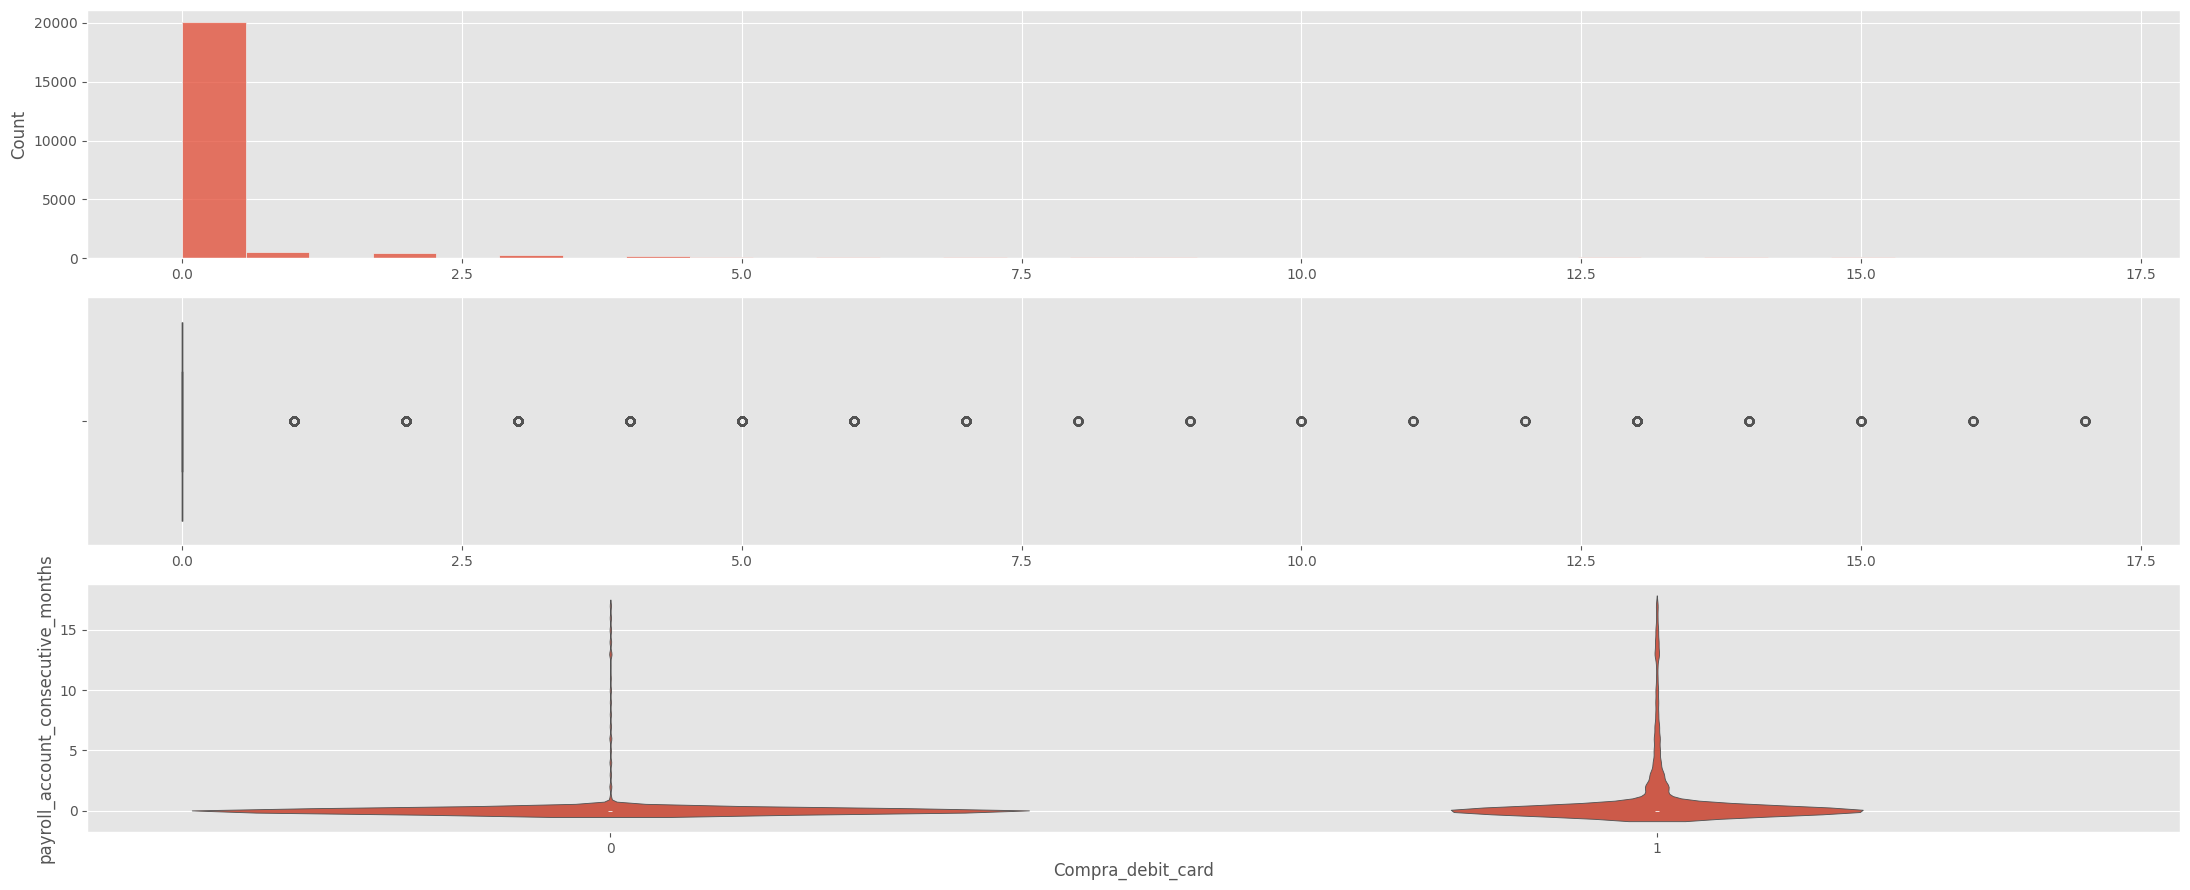

In [211]:
plot_num(df, 'payroll_account_consecutive_months', TARGET)

#### emc_account_consecutive_months

c:\Users\USUARIO\AppData\Local\Programs\Python\Python312\Lib\site-packages\seaborn\categorical.py:632: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)
c:\Users\USUARIO\AppData\Local\Programs\Python\Python312\Lib\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
c:\Users\USUARIO\AppData\Local\Programs\Python\Python312\Lib\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


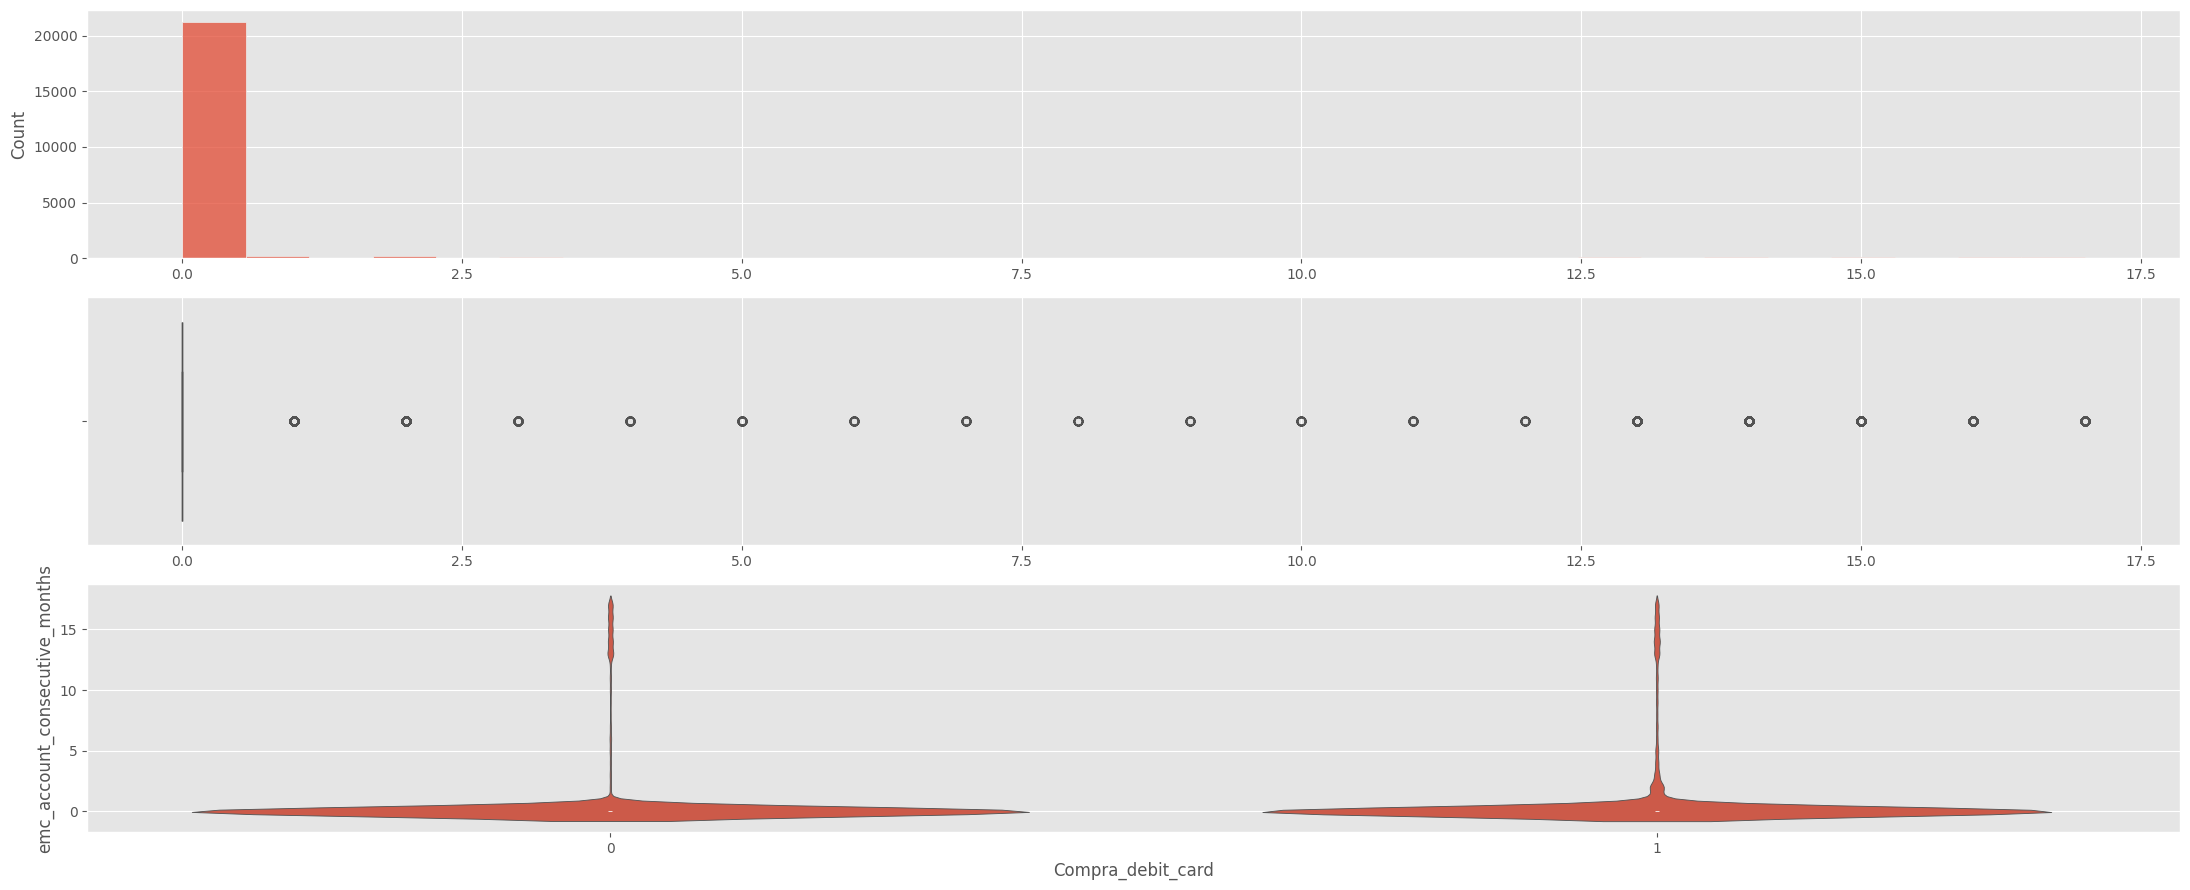

In [212]:
plot_num(df, 'emc_account_consecutive_months', TARGET)

#### credit_card_consecutive_months

c:\Users\USUARIO\AppData\Local\Programs\Python\Python312\Lib\site-packages\seaborn\categorical.py:632: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)
c:\Users\USUARIO\AppData\Local\Programs\Python\Python312\Lib\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
c:\Users\USUARIO\AppData\Local\Programs\Python\Python312\Lib\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


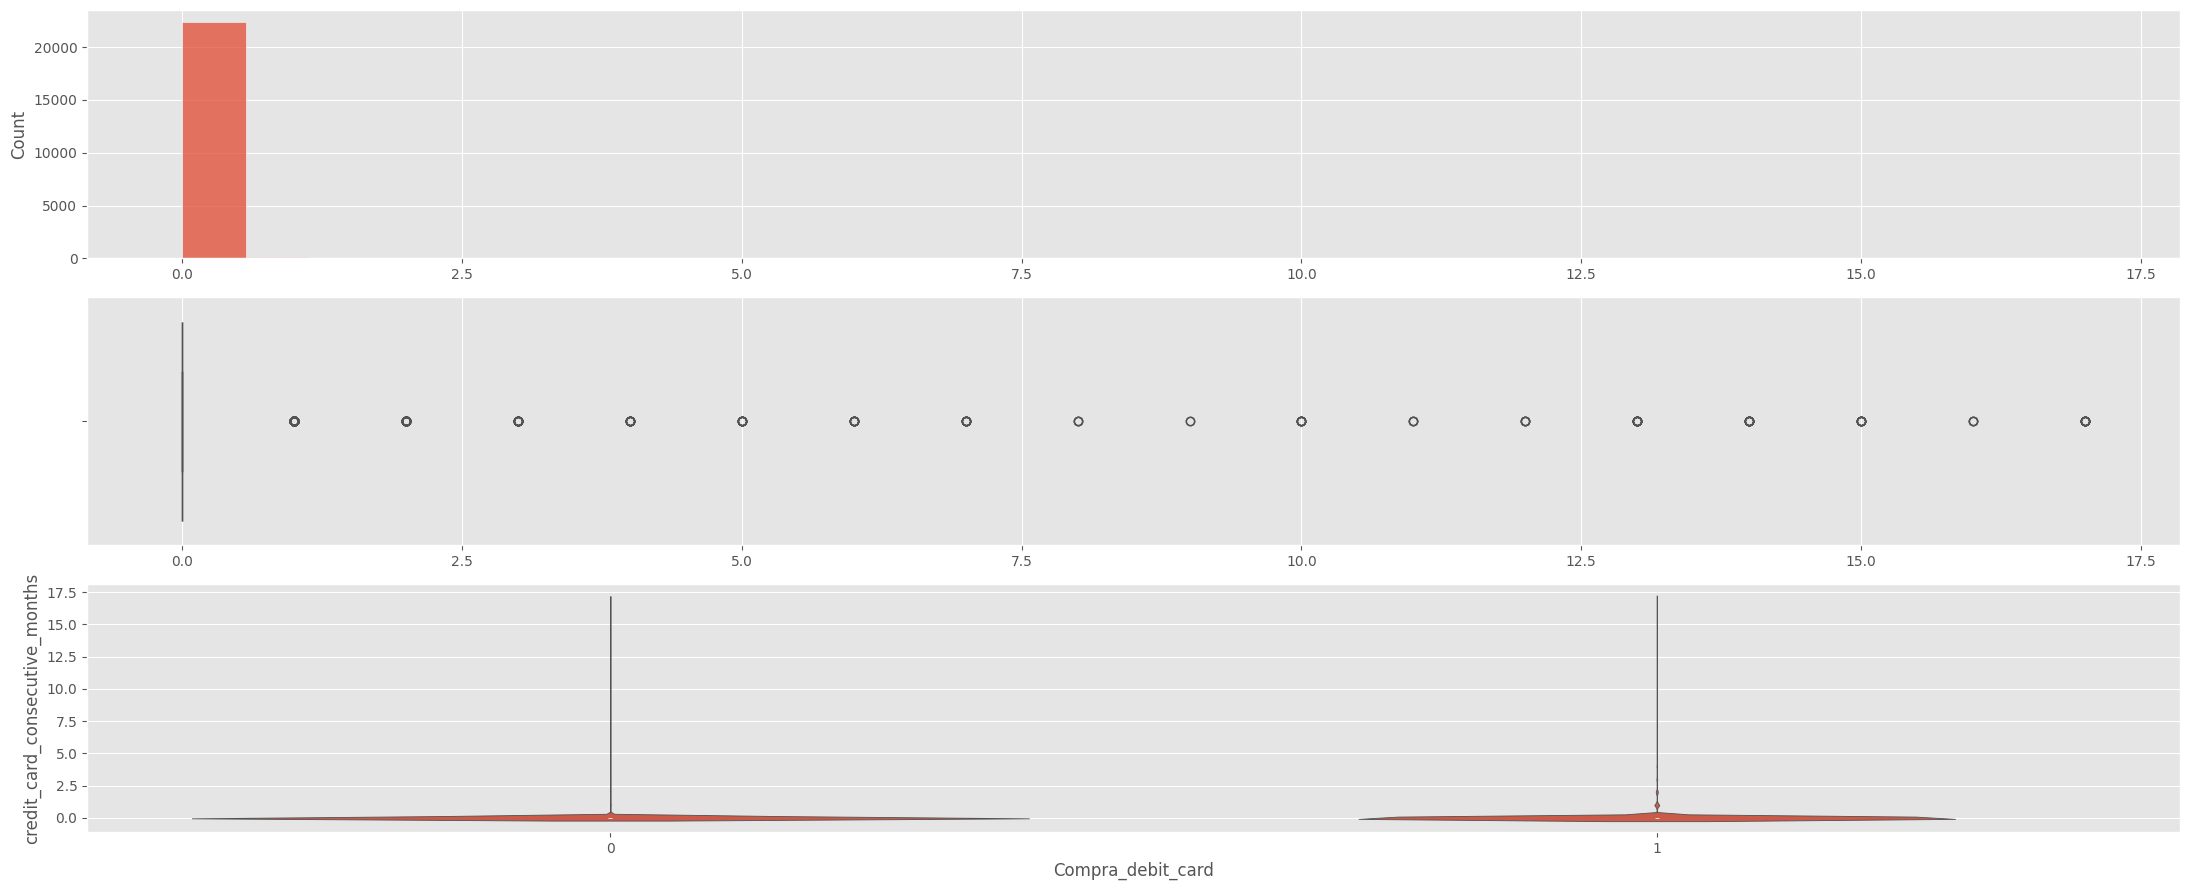

In [213]:
plot_num(df, 'credit_card_consecutive_months', TARGET)

In [214]:
no_explicativas.append('credit_card_consecutive_months')

#### long_term_deposit_consecutive_months

c:\Users\USUARIO\AppData\Local\Programs\Python\Python312\Lib\site-packages\seaborn\categorical.py:632: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)
c:\Users\USUARIO\AppData\Local\Programs\Python\Python312\Lib\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
c:\Users\USUARIO\AppData\Local\Programs\Python\Python312\Lib\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


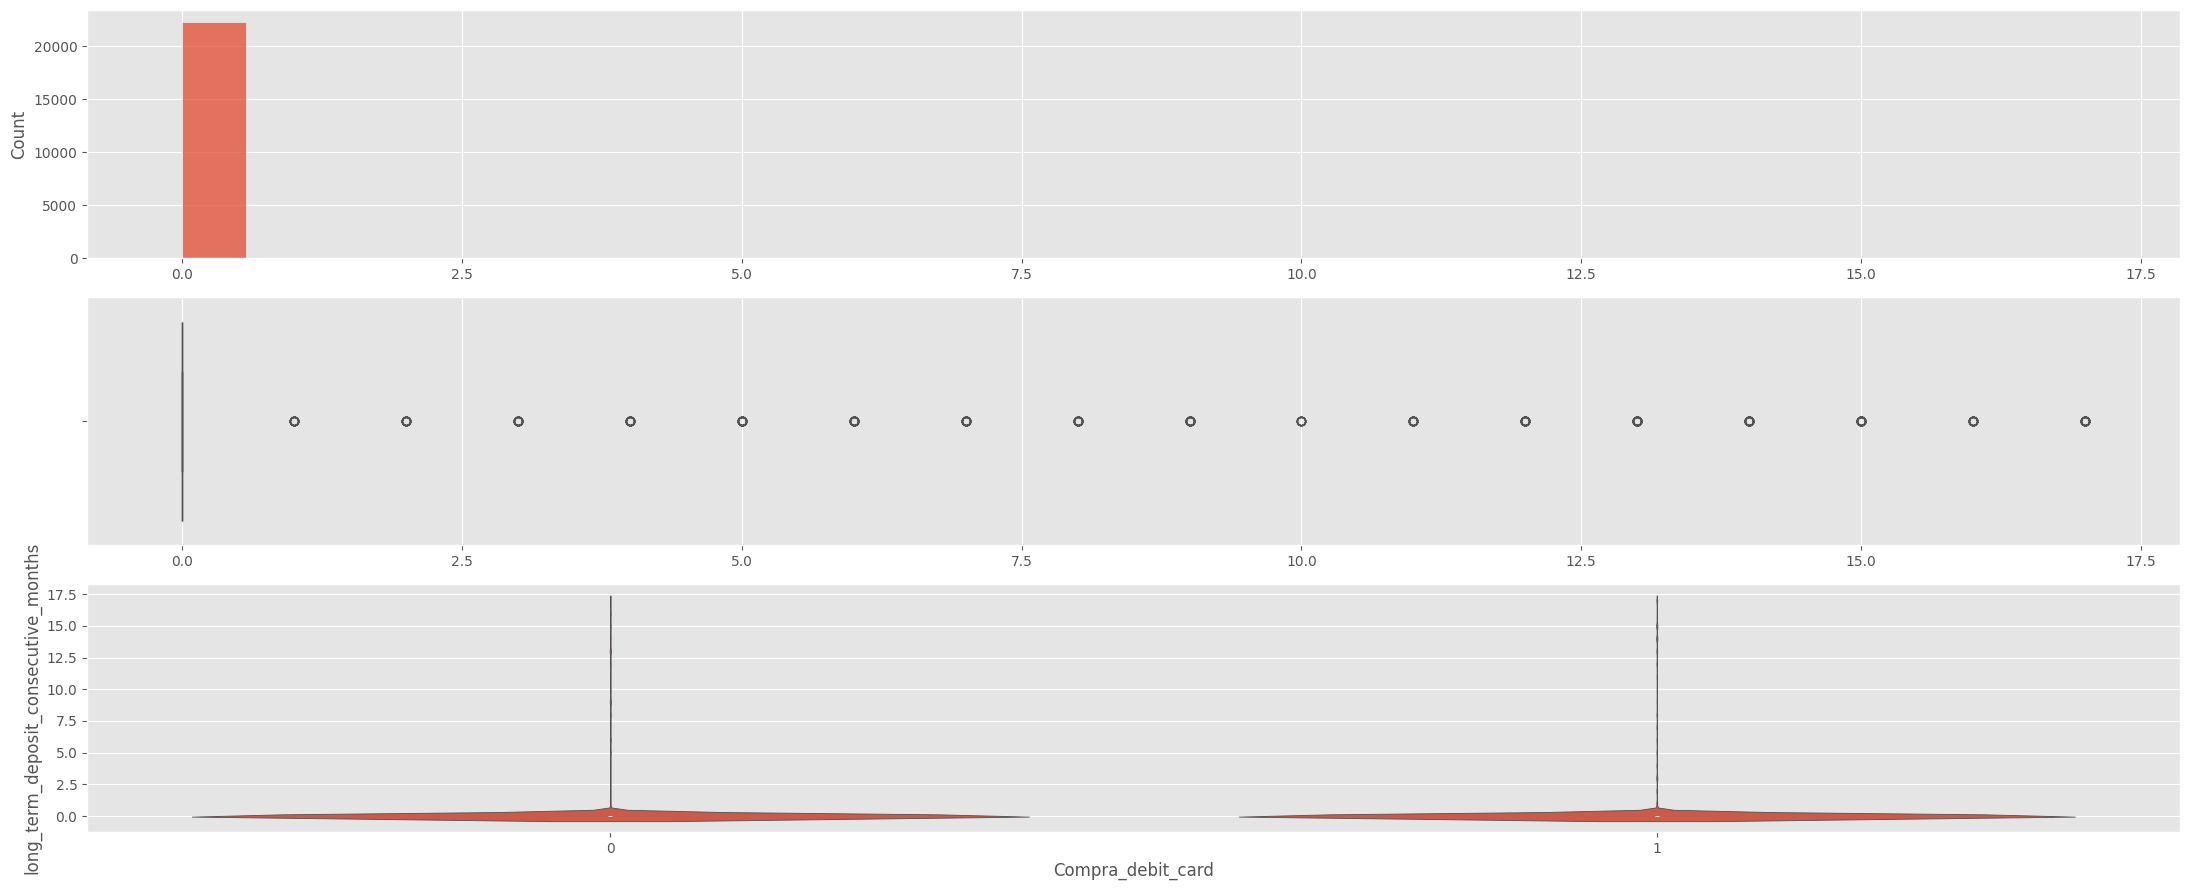

In [215]:
plot_num(df, 'long_term_deposit_consecutive_months', TARGET)

In [216]:
no_explicativas.append('long_term_deposit_consecutive_months')

#### securities_consecutive_months

c:\Users\USUARIO\AppData\Local\Programs\Python\Python312\Lib\site-packages\seaborn\categorical.py:632: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)
c:\Users\USUARIO\AppData\Local\Programs\Python\Python312\Lib\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
c:\Users\USUARIO\AppData\Local\Programs\Python\Python312\Lib\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


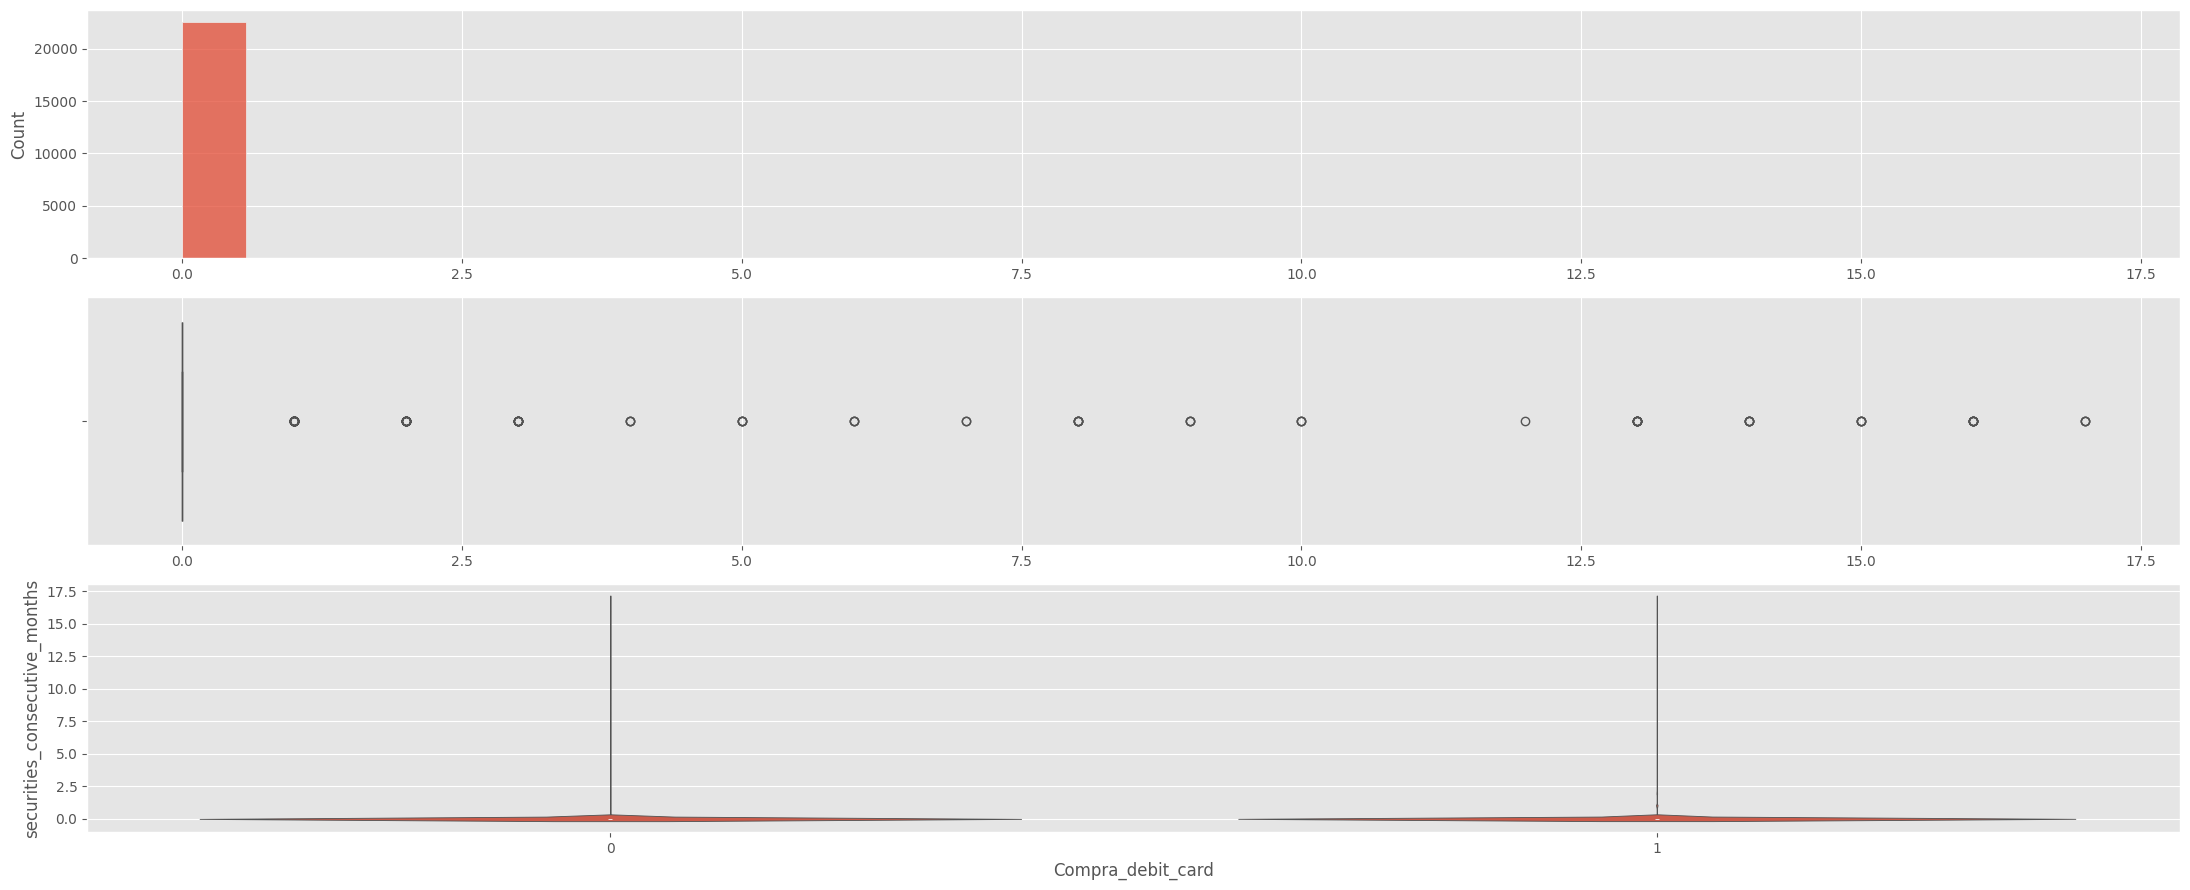

In [217]:
plot_num(df, 'securities_consecutive_months', TARGET)

In [218]:
no_explicativas.append('securities_consecutive_months')

#### funds_consecutive_months

c:\Users\USUARIO\AppData\Local\Programs\Python\Python312\Lib\site-packages\seaborn\categorical.py:632: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)
c:\Users\USUARIO\AppData\Local\Programs\Python\Python312\Lib\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
c:\Users\USUARIO\AppData\Local\Programs\Python\Python312\Lib\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


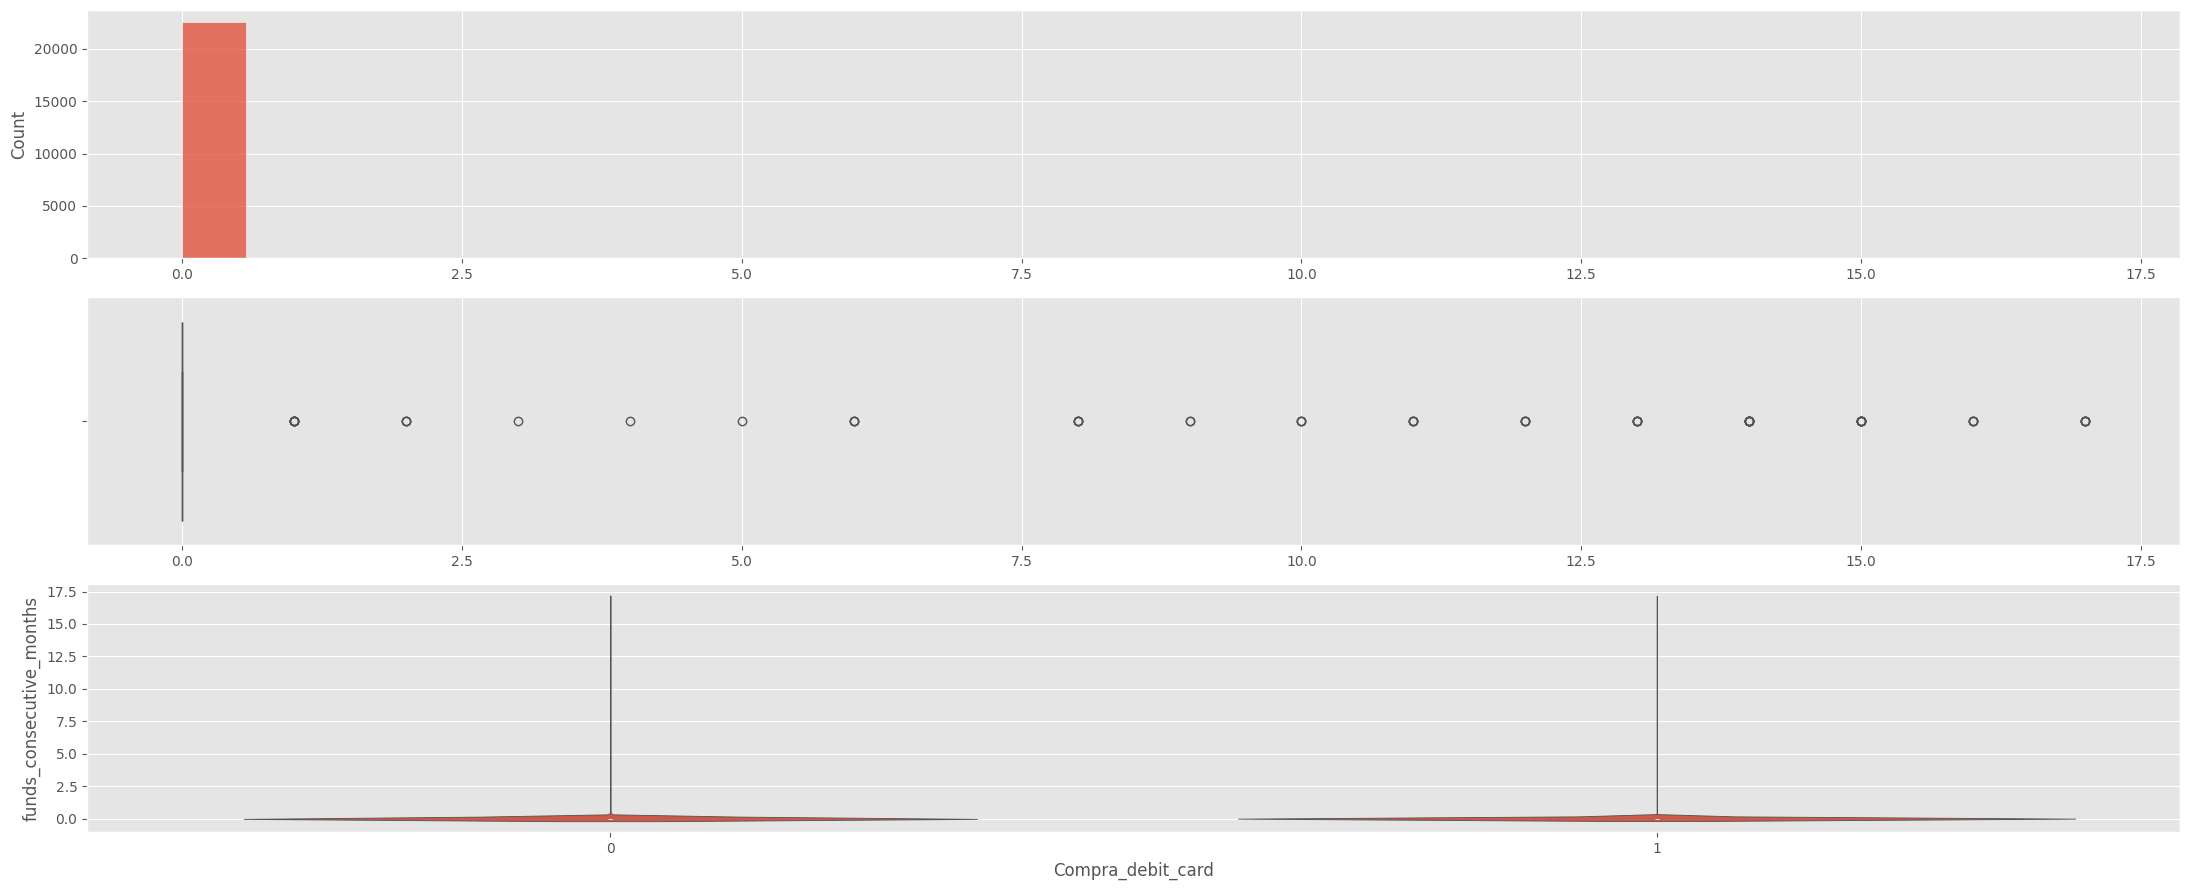

In [219]:
plot_num(df, 'funds_consecutive_months', TARGET)

In [220]:
no_explicativas.append('funds_consecutive_months')

#### mortgage_consecutive_months

c:\Users\USUARIO\AppData\Local\Programs\Python\Python312\Lib\site-packages\seaborn\categorical.py:632: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)
c:\Users\USUARIO\AppData\Local\Programs\Python\Python312\Lib\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
c:\Users\USUARIO\AppData\Local\Programs\Python\Python312\Lib\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


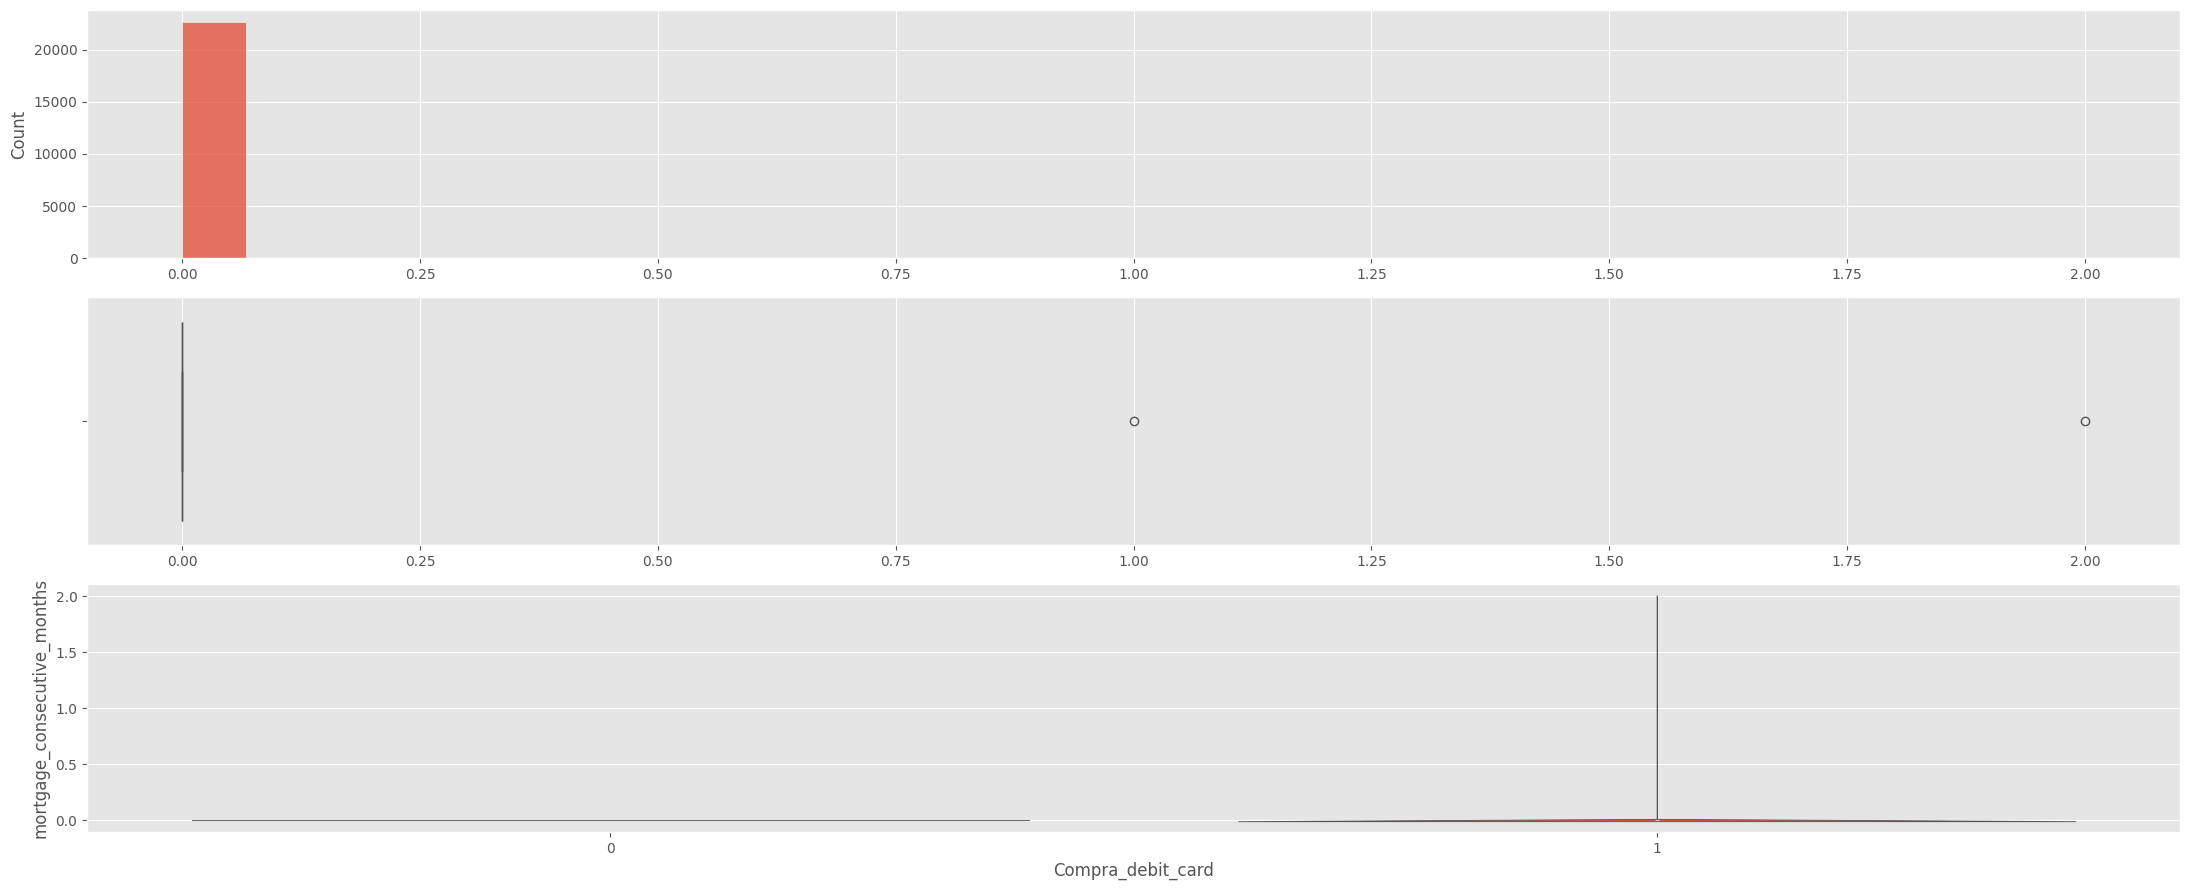

In [221]:
plot_num(df, 'mortgage_consecutive_months', TARGET)

In [222]:
no_explicativas.append('mortgage_consecutive_months')

#### num_accounts

c:\Users\USUARIO\AppData\Local\Programs\Python\Python312\Lib\site-packages\seaborn\categorical.py:632: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)
c:\Users\USUARIO\AppData\Local\Programs\Python\Python312\Lib\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
c:\Users\USUARIO\AppData\Local\Programs\Python\Python312\Lib\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


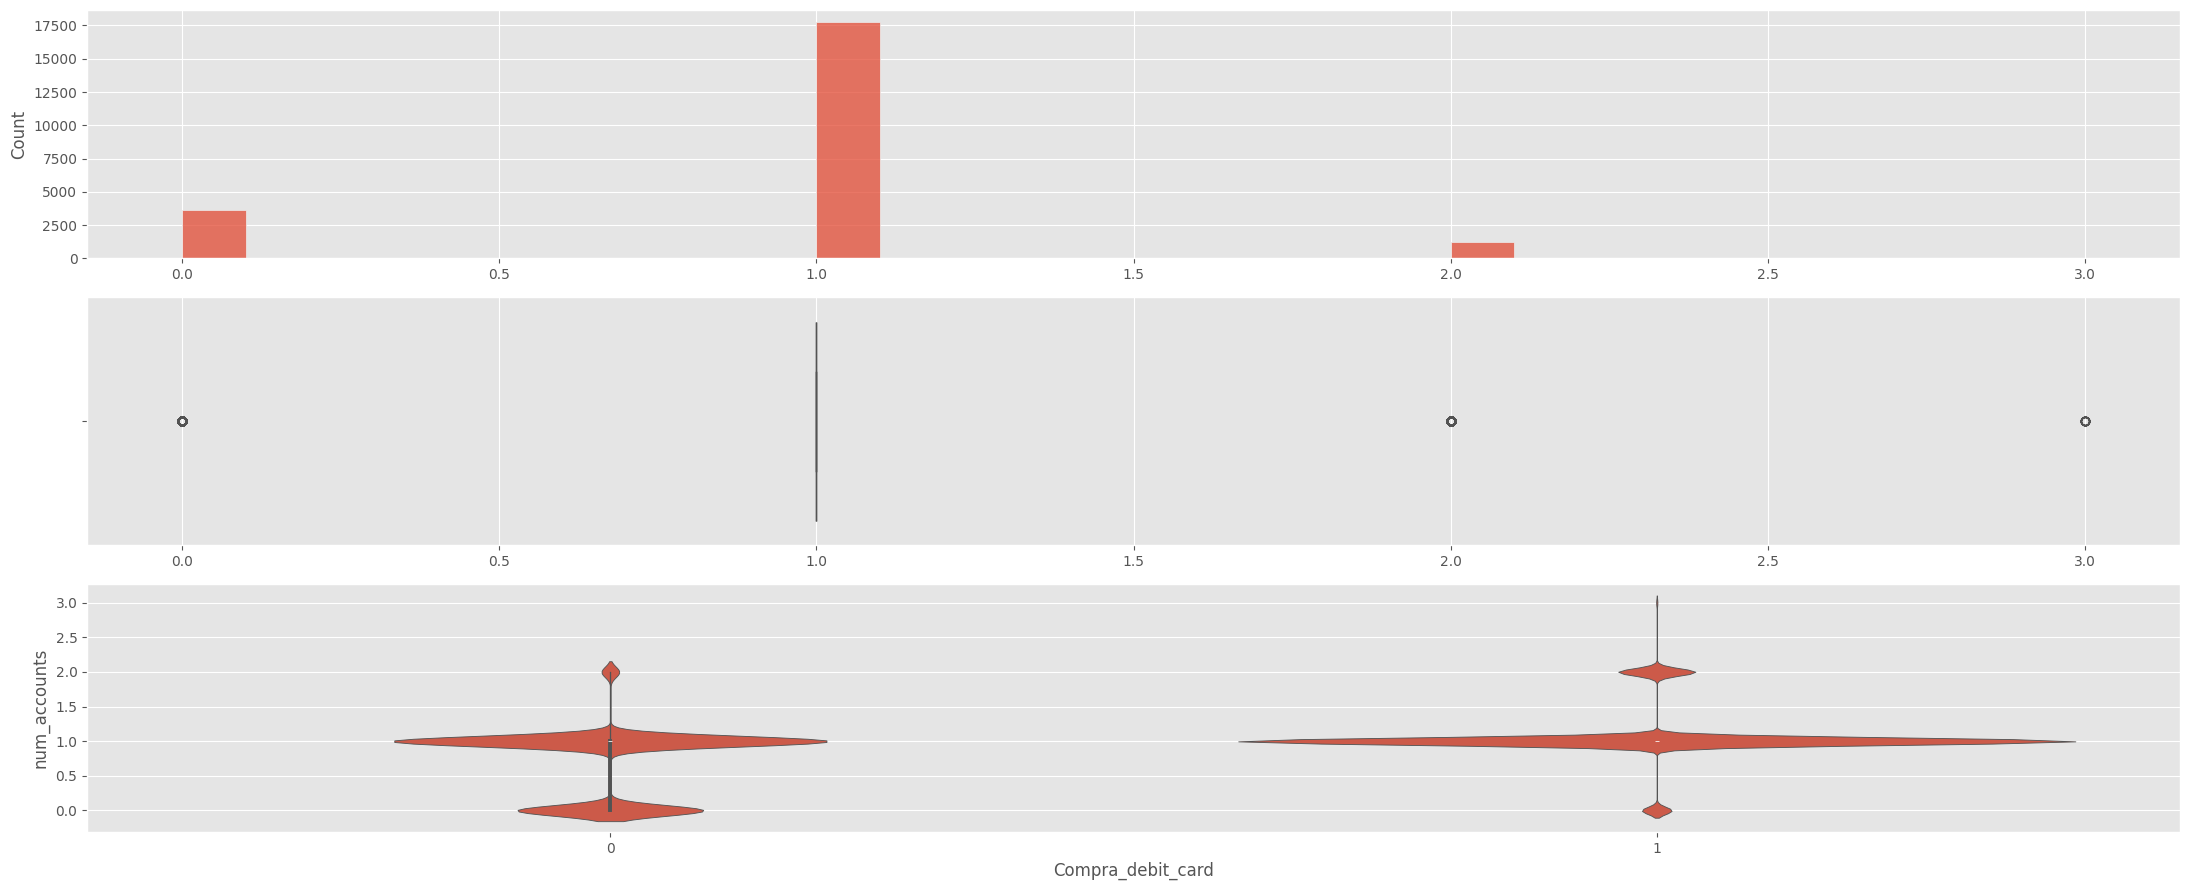

In [223]:
plot_num(df, 'num_accounts', TARGET)

#### meses_antigüedad

c:\Users\USUARIO\AppData\Local\Programs\Python\Python312\Lib\site-packages\seaborn\categorical.py:632: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)
c:\Users\USUARIO\AppData\Local\Programs\Python\Python312\Lib\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
c:\Users\USUARIO\AppData\Local\Programs\Python\Python312\Lib\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


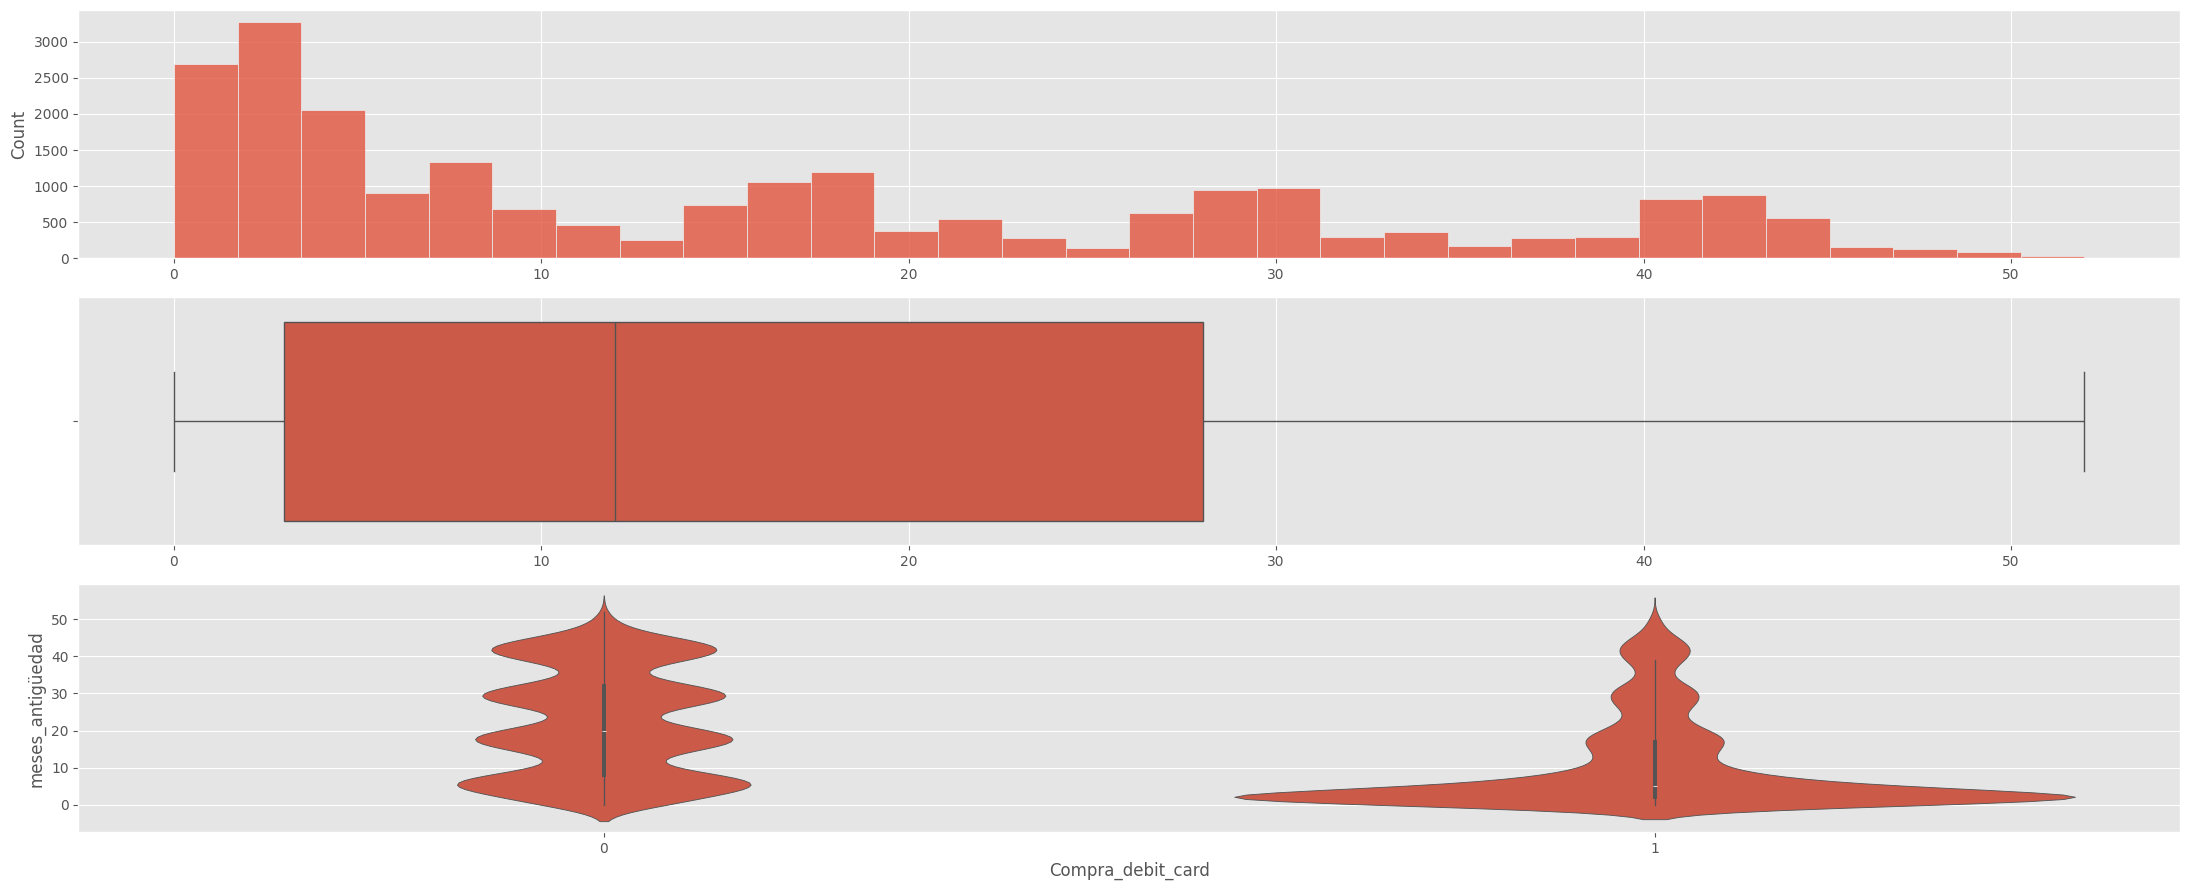

In [224]:
plot_num(df, 'meses_antigüedad', TARGET)

### Booleanas

In [225]:
booleanas

['active_customer',
 'short_term_deposit_consecutive_months',
 'loans_consecutive_months',
 'has_credit_card_debt',
 'has_savings_investments',
 'has_easyMoney_account',
 'num_debt_products']

Todas las variables que vamos a analizar a continuación son variables booleanas, lo que significa que no hace falta aplicar el OneHotEncoding y unicamente vamos a discutir si se trata de variables relevantes para nuestro modelo o no.

#### active_customer

c:\Users\USUARIO\AppData\Local\Programs\Python\Python312\Lib\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
c:\Users\USUARIO\AppData\Local\Programs\Python\Python312\Lib\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\Users\USUARIO\AppData\Local\Temp\ipykernel_8328\138647495.py:17: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(ax1.get_xticklabels(), rotation=70)


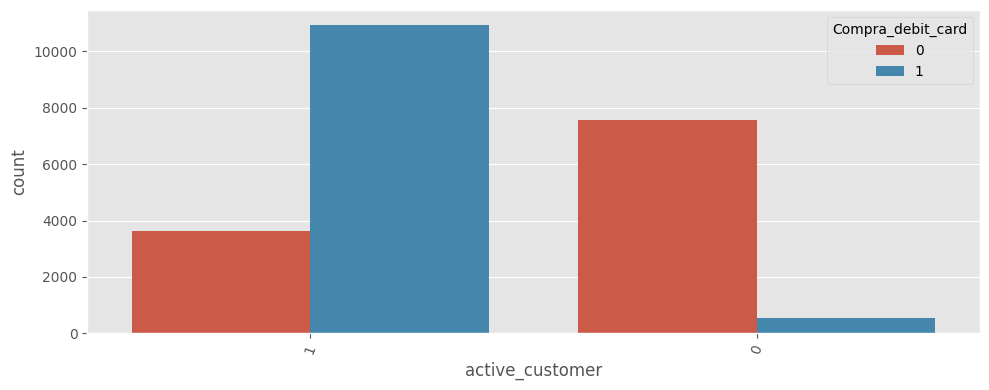

,Num_clientes,Num_compras,Porcentaje_compra
active_customer,,,
1,14560,10925,0.750343
0,8093,540,0.066724


In [226]:
analisis_cat(df, 'active_customer', TARGET)

#### short_term_deposit_consecutive_months

c:\Users\USUARIO\AppData\Local\Programs\Python\Python312\Lib\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
c:\Users\USUARIO\AppData\Local\Programs\Python\Python312\Lib\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\Users\USUARIO\AppData\Local\Temp\ipykernel_8328\138647495.py:17: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(ax1.get_xticklabels(), rotation=70)


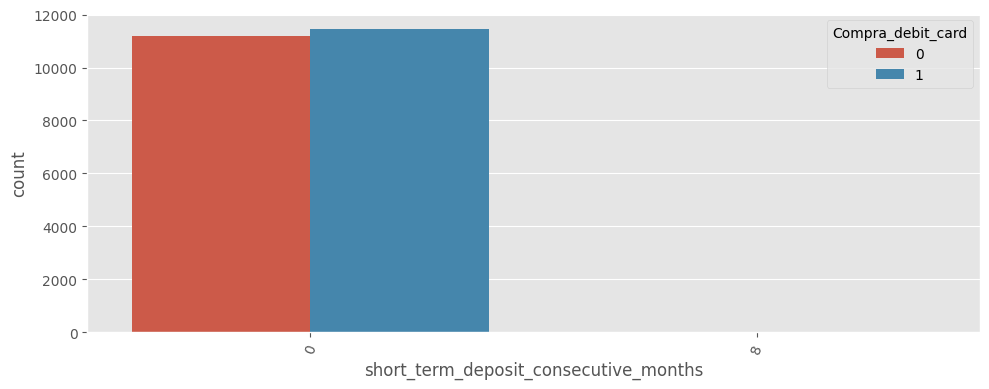

,Num_clientes,Num_compras,Porcentaje_compra
short_term_deposit_consecutive_months,,,
0,22652,11465,0.506136
8,1,0,0.000000


In [227]:
analisis_cat(df, 'short_term_deposit_consecutive_months', TARGET)

In [228]:
no_explicativas.append('short_term_deposit_consecutive_months')

#### loans_consecutive_months

c:\Users\USUARIO\AppData\Local\Programs\Python\Python312\Lib\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
c:\Users\USUARIO\AppData\Local\Programs\Python\Python312\Lib\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\Users\USUARIO\AppData\Local\Temp\ipykernel_8328\138647495.py:17: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(ax1.get_xticklabels(), rotation=70)


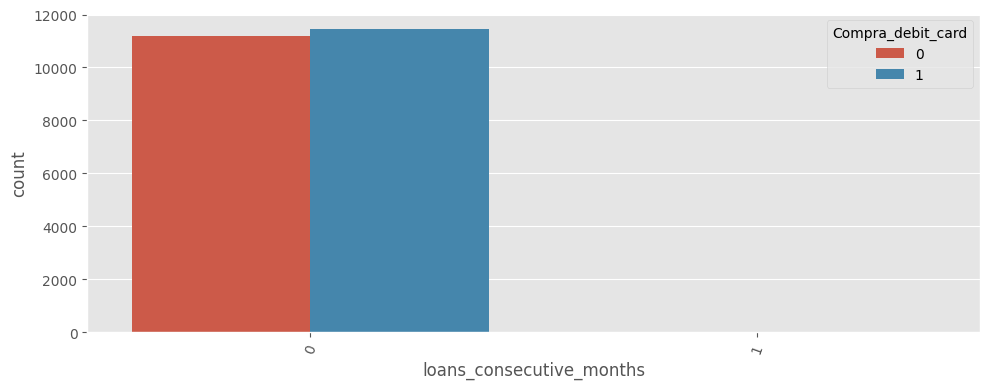

,Num_clientes,Num_compras,Porcentaje_compra
loans_consecutive_months,,,
0,22652,11464,0.506092
1,1,1,1.000000


In [229]:
analisis_cat(df, 'loans_consecutive_months', TARGET)

In [230]:
no_explicativas.append('loans_consecutive_months')

#### has_credit_card_debt

c:\Users\USUARIO\AppData\Local\Programs\Python\Python312\Lib\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
c:\Users\USUARIO\AppData\Local\Programs\Python\Python312\Lib\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\Users\USUARIO\AppData\Local\Temp\ipykernel_8328\138647495.py:17: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(ax1.get_xticklabels(), rotation=70)


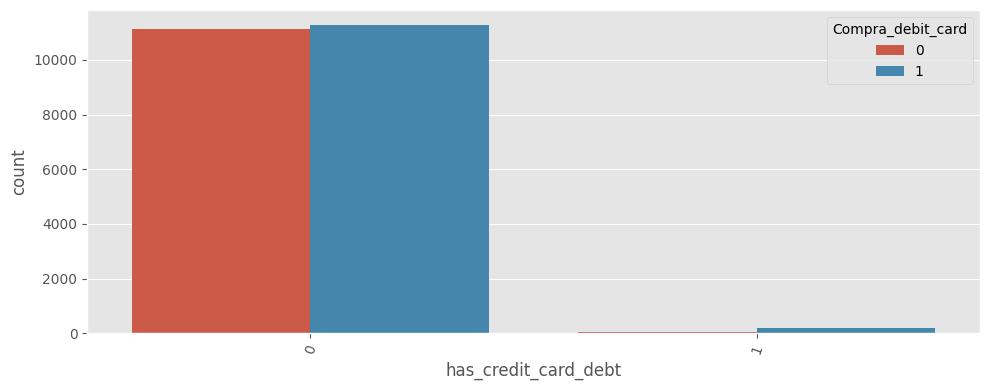

,Num_clientes,Num_compras,Porcentaje_compra
has_credit_card_debt,,,
0,22399,11266,0.502969
1,254,199,0.783465


In [231]:
analisis_cat(df, 'has_credit_card_debt', TARGET)

In [232]:
no_explicativas.append('has_credit_card_debt')

#### has_savings_investments

c:\Users\USUARIO\AppData\Local\Programs\Python\Python312\Lib\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
c:\Users\USUARIO\AppData\Local\Programs\Python\Python312\Lib\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\Users\USUARIO\AppData\Local\Temp\ipykernel_8328\138647495.py:17: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(ax1.get_xticklabels(), rotation=70)


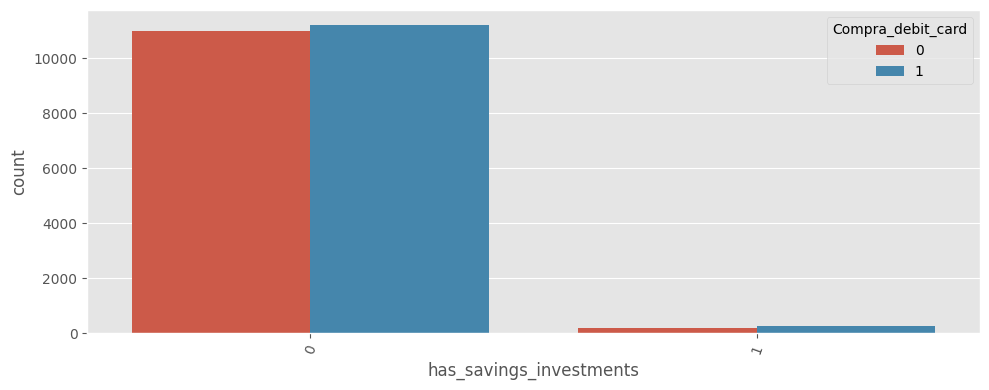

,Num_clientes,Num_compras,Porcentaje_compra
has_savings_investments,,,
0,22184,11195,0.504643
1,469,270,0.575693


In [233]:
analisis_cat(df, 'has_savings_investments', TARGET)

In [234]:
no_explicativas.append('has_savings_investments')

#### has_easyMoney_account

c:\Users\USUARIO\AppData\Local\Programs\Python\Python312\Lib\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
c:\Users\USUARIO\AppData\Local\Programs\Python\Python312\Lib\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\Users\USUARIO\AppData\Local\Temp\ipykernel_8328\138647495.py:17: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(ax1.get_xticklabels(), rotation=70)


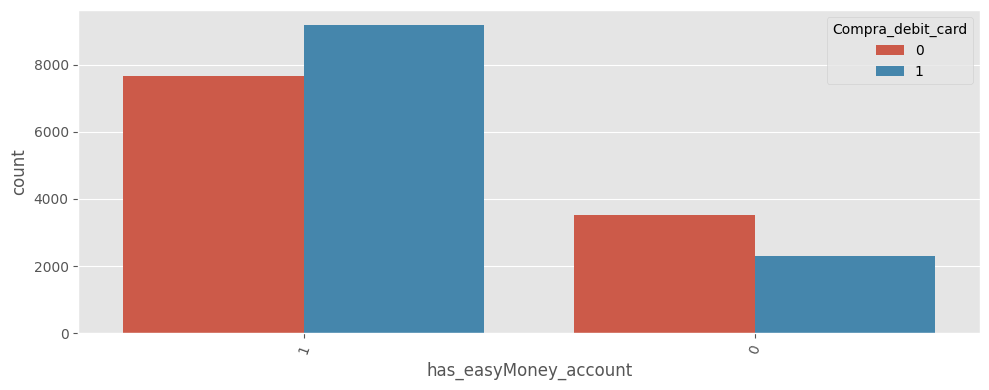

,Num_clientes,Num_compras,Porcentaje_compra
has_easyMoney_account,,,
1,16829,9164,0.544536
0,5824,2301,0.395089


In [235]:
analisis_cat(df, 'has_easyMoney_account', TARGET)

#### num_debt_products

c:\Users\USUARIO\AppData\Local\Programs\Python\Python312\Lib\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
c:\Users\USUARIO\AppData\Local\Programs\Python\Python312\Lib\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\Users\USUARIO\AppData\Local\Temp\ipykernel_8328\138647495.py:17: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(ax1.get_xticklabels(), rotation=70)


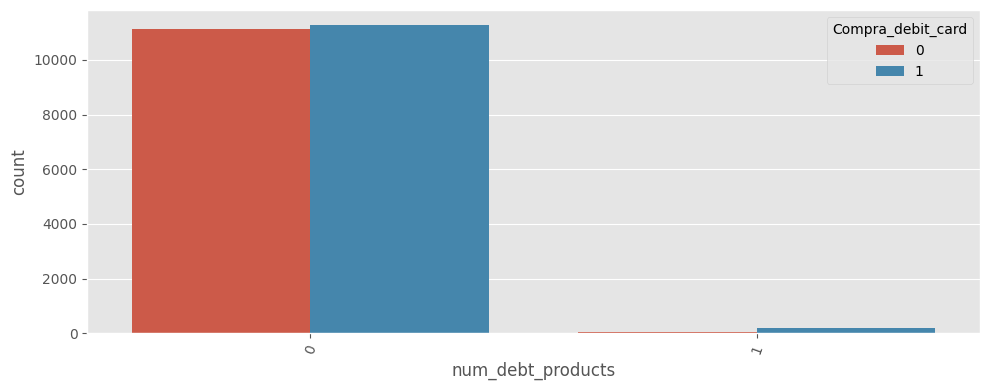

,Num_clientes,Num_compras,Porcentaje_compra
num_debt_products,,,
0,22399,11266,0.502969
1,254,199,0.783465


In [236]:
analisis_cat(df, 'num_debt_products', TARGET)

In [237]:
no_explicativas.append('num_debt_products')

<a id='analisis_multivariante'></a>
## Análisis Multivariante
[Volver al índice](#index)

En este apartado analizamos la distribución de variables 2 a 2 y analizamos la correlación que puede existir entre ellas.

Pero antes eliminamos aquellas variables que hemos considerado no explicativas.

In [238]:
no_explicativas

['country_id',
 'region_code',
 'deceased',
 'pk_partition_month',
 'credit_card_consecutive_months',
 'long_term_deposit_consecutive_months',
 'securities_consecutive_months',
 'funds_consecutive_months',
 'mortgage_consecutive_months',
 'short_term_deposit_consecutive_months',
 'loans_consecutive_months',
 'has_credit_card_debt',
 'has_savings_investments',
 'num_debt_products']

In [239]:
df = df.drop(columns=no_explicativas)

In [240]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 22653 entries, 1517558 to 1546388
Data columns (total 19 columns):
 #   Column                              Non-Null Count  Dtype   
---  ------                              --------------  -----   
 0   gender                              22653 non-null  object  
 1   age                                 22653 non-null  int64   
 2   salary                              22653 non-null  float64 
 3   entry_channel                       22653 non-null  category
 4   active_customer                     22653 non-null  int32   
 5   segment                             22653 non-null  object  
 6   entry_date_year                     22653 non-null  int32   
 7   entry_date_month                    22653 non-null  int32   
 8   tipo_cliente                        22653 non-null  object  
 9   Compra_debit_card                   22653 non-null  int64   
 10  em_acount_consecutive_months        22653 non-null  int64   
 11  pension_plan_consecutive_

In [241]:
numericas,categoricas,booleanas = obtener_lista_variables(df)
print(f'Variables numéricas ({len(numericas)}): {numericas}')
print(f'Variables categóricas ({len(categoricas)}):{categoricas}')
print(f'Variables booleanas ({len(booleanas)}):{booleanas}')

Variables numéricas (12): ['age', 'salary', 'entry_date_year', 'entry_date_month', 'em_acount_consecutive_months', 'pension_plan_consecutive_months', 'payroll_consecutive_months', 'payroll_account_consecutive_months', 'emc_account_consecutive_months', 'num_accounts', 'meses_antigüedad', 'region_encoded']
Variables categóricas (4):['gender', 'entry_channel', 'segment', 'tipo_cliente']
Variables booleanas (2):['active_customer', 'has_easyMoney_account']


In [242]:
from scipy.stats import chi2_contingency

def relacion_categoricas(col_1,col_2):
    """
    Calcula y muestra el coeficiente de Cramér V para medir la asociación entre dos variables categóricas.

    Parámetros:
    col_1 (str): El nombre de la primera columna categórica.
    col_2 (str): El nombre de la segunda columna categórica.

    Retorna:
    None: La función imprime el coeficiente de Cramér V, una medida de asociación entre las dos variables categóricas.
    """
    tabla_contingencia = pd.crosstab(df[col_1], df[col_2])
    chi2, p, dof, ex = chi2_contingency(tabla_contingencia)
    n = tabla_contingencia.sum().sum()
    cramers_v = np.sqrt(chi2 / (n * (min(tabla_contingencia.shape) - 1)))
    print(f'El coeficiente de Cramér V entre {col_1} y {col_2} es de: {cramers_v}')

Vamos a comenzar viendo si ciertas variables estudiadas anteriormente son independientes o no. Para ello hacemos uso de la función **relacion_categoricas** que nos permite calcular el coeficiente de Cramér, el cuál nos da una idea de la independencia entre dos variables categóricas.

Si el coeficiente es igual a 1, las variables son dependientes entre sí, lo cual indica que están fuertemente relacionadas. Por otro lado, cuanto más cercano a 0 sea el coeficiente, más independencia hay entre las dos variables, por lo que no están relacionadas entre sí.

In [243]:
categoricas

['gender', 'entry_channel', 'segment', 'tipo_cliente']

In [244]:
print('\n','Relación entre distintas variables categóricas:','\n')
relacion_categoricas('gender','entry_channel')
relacion_categoricas('gender','tipo_cliente')
relacion_categoricas('segment','tipo_cliente')


 Relación entre distintas variables categóricas: 

El coeficiente de Cramér V entre gender y entry_channel es de: 0.1371610307185526
El coeficiente de Cramér V entre gender y tipo_cliente es de: 0.01835913570330274
El coeficiente de Cramér V entre segment y tipo_cliente es de: 0.9792548198533193


Por otro lado, para las variables numéricas, vamos a crear un dataset con aquellas variables que nos interesan y mediante un heatmap de la matriz de correlación vamos a ser capaces de visualizar la correlación entre las distintas variables.

In [245]:
todas_numericas = df[numericas+booleanas]
corr_numericas = todas_numericas.corr() 
corr_numericas.style.background_gradient(cmap='coolwarm')

,age,salary,entry_date_year,entry_date_month,em_acount_consecutive_months,pension_plan_consecutive_months,payroll_consecutive_months,payroll_account_consecutive_months,emc_account_consecutive_months,num_accounts,meses_antigüedad,region_encoded,active_customer,has_easyMoney_account
age,1.000000,-0.037385,0.204416,-0.262402,-0.210655,0.033627,0.027092,0.041679,0.177175,0.116320,-0.154501,0.136598,0.267681,-0.014070
salary,-0.037385,1.000000,-0.172639,0.039812,0.104865,0.021791,0.021201,0.034576,0.040710,-0.010259,0.174941,0.009049,-0.059160,-0.018978
entry_date_year,0.204416,-0.172639,1.000000,-0.418176,-0.497841,-0.025396,-0.025153,-0.080002,-0.157450,0.029892,-0.967295,0.122003,0.320784,0.024475
entry_date_month,-0.262402,0.039812,-0.418176,1.000000,0.189988,-0.026274,-0.026392,-0.015577,-0.042291,-0.067824,0.191028,-0.069905,-0.230431,-0.022896
em_acount_consecutive_months,-0.210655,0.104865,-0.497841,0.189988,1.000000,-0.198078,-0.195471,-0.260268,0.036103,0.372839,0.498984,-0.164246,-0.106031,0.604120
pension_plan_consecutive_months,0.033627,0.021791,-0.025396,-0.026274,-0.198078,1.000000,0.993882,0.617859,0.068000,0.118911,0.034562,0.049372,0.154501,-0.260097
payroll_consecutive_months,0.027092,0.021201,-0.025153,-0.026392,-0.195471,0.993882,1.000000,0.611433,0.066046,0.116653,0.034251,0.048173,0.152129,-0.256543
payroll_account_consecutive_months,0.041679,0.034576,-0.080002,-0.015577,-0.260268,0.617859,0.611433,1.000000,0.083836,0.157796,0.090304,0.049703,0.187749,-0.347188
emc_account_consecutive_months,0.177175,0.040710,-0.157450,-0.042291,0.036103,0.068000,0.066046,0.083836,1.000000,0.428936,0.181187,0.064907,0.117455,0.123469
num_accounts,0.116320,-0.010259,0.029892,-0.067824,0.372839,0.118911,0.116653,0.157796,0.428936,1.000000,-0.016222,0.009108,0.483630,0.670219


In [246]:
tabla_correlacion = corr_numericas.stack().reset_index()
tabla_correlacion.columns = ['Variable 1', 'Variable 2', 'Correlación']

# Filtrar los valores duplicados y las autocorrelaciones
tabla_correlacion = tabla_correlacion[tabla_correlacion['Variable 1'] != tabla_correlacion['Variable 2']]
tabla_correlacion['abs_Correlación'] = tabla_correlacion['Correlación'].abs()
tabla_correlacion = tabla_correlacion.drop_duplicates(subset=['Correlación'])

# Ordenar los valores por la correlación absoluta
tabla_correlacion = tabla_correlacion.sort_values(by='abs_Correlación', ascending=False)

# Mostrar las correlaciones más altas, tanto positivas como negativas
tabla_correlacion.head(10)

,Variable 1,Variable 2,Correlación,abs_Correlación
76,pension_plan_consecutive_months,payroll_consecutive_months,0.993882,0.993882
38,entry_date_year,meses_antigüedad,-0.967295,0.967295
139,num_accounts,has_easyMoney_account,0.670219,0.670219
77,pension_plan_consecutive_months,payroll_account_consecutive_months,0.617859,0.617859
91,payroll_consecutive_months,payroll_account_consecutive_months,0.611433,0.611433
69,em_acount_consecutive_months,has_easyMoney_account,0.604120,0.604120
66,em_acount_consecutive_months,meses_antigüedad,0.498984,0.498984
32,entry_date_year,em_acount_consecutive_months,-0.497841,0.497841
138,num_accounts,active_customer,0.483630,0.483630
121,emc_account_consecutive_months,num_accounts,0.428936,0.428936


In [247]:
correlacion_alta = tabla_correlacion[tabla_correlacion['abs_Correlación']>0.90]['Variable 1'].to_list()
print(f'Se eliminan las siguientes variables debido a su alta correlación con otras columnas: {correlacion_alta}')
df = df.drop(columns= correlacion_alta)

Se eliminan las siguientes variables debido a su alta correlación con otras columnas: ['pension_plan_consecutive_months', 'entry_date_year']


# DATA PREPARATION

Una vez tenemos limpio el dataset y lo tenemos listo para preprocesar vamos a únicamente a estandarizar aquellas variables numéricas que lo requieren. 
Vamos a realizar este paso para tener un dataset de entrenamiento para los modelos de LightGBM y CatBoost que, pese a tratar con variables categóricas sin problema, se recomienda que las variables numéricas si se encuentren estandariazdas/normalizadas.

In [248]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 22653 entries, 1517558 to 1546388
Data columns (total 17 columns):
 #   Column                              Non-Null Count  Dtype   
---  ------                              --------------  -----   
 0   gender                              22653 non-null  object  
 1   age                                 22653 non-null  int64   
 2   salary                              22653 non-null  float64 
 3   entry_channel                       22653 non-null  category
 4   active_customer                     22653 non-null  int32   
 5   segment                             22653 non-null  object  
 6   entry_date_month                    22653 non-null  int32   
 7   tipo_cliente                        22653 non-null  object  
 8   Compra_debit_card                   22653 non-null  int64   
 9   em_acount_consecutive_months        22653 non-null  int64   
 10  payroll_consecutive_months          22653 non-null  int64   
 11  payroll_account_consecuti

In [249]:
numericas,categoricas,booleanas = obtener_lista_variables(df)
print(f'Variables numéricas ({len(numericas)}): {numericas}')
print(f'Variables categóricas ({len(categoricas)}):{categoricas}')
print(f'Variables booleanas ({len(booleanas)}):{booleanas}')

Variables numéricas (10): ['age', 'salary', 'entry_date_month', 'em_acount_consecutive_months', 'payroll_consecutive_months', 'payroll_account_consecutive_months', 'emc_account_consecutive_months', 'num_accounts', 'meses_antigüedad', 'region_encoded']
Variables categóricas (4):['gender', 'entry_channel', 'segment', 'tipo_cliente']
Variables booleanas (2):['active_customer', 'has_easyMoney_account']


<a id='transformacion'></a>
## Transformación de atributos
[Volver al índice](#index)

En este apartado aplicamos el OneHotEncoding y el Ordinal Encoding sobre aquellas variables que lo requieran

In [250]:
# para aplicar el ordinal encoder comenzamos definiendo el orden de las categorías
#age_group_order = ['18-24', '25-34', '35-44','45-54','55+']
#salary_bracket_order = ['low','medium','high','Unknown']  # ponemos el unknown como la más alta porque es la que más porcentaje de compra tiene

# Crear el OrdinalEncoder y especificar el orden
#ordinal_encoder = OrdinalEncoder(categories=[age_group_order, salary_bracket_order])

# Aplicar el OrdinalEncoder a las columnas correspondientes
#df[['age_group', 'salary_bracket']] = ordinal_encoder.fit_transform(df[['age_group', 'salary_bracket']])

# Mostrar el resultado
#print(df[['age_group', 'salary_bracket']])

In [251]:
categoricas

['gender', 'entry_channel', 'segment', 'tipo_cliente']

In [252]:
numericas

['age',
 'salary',
 'entry_date_month',
 'em_acount_consecutive_months',
 'payroll_consecutive_months',
 'payroll_account_consecutive_months',
 'emc_account_consecutive_months',
 'num_accounts',
 'meses_antigüedad',
 'region_encoded']

In [253]:
# comenzamos aplicando StandardScaler a aquellas variables numéricas para que a los modelos les resulte más fácil encontrar patrones
scaler = StandardScaler()
# Aplicar el escalado solo a las columnas numéricas
df[numericas] = scaler.fit_transform(df[numericas])

In [254]:
df.describe(include=np.number).T

,count,mean,std,min,25%,50%,75%,max
age,22653.0,-8.217993e-17,1.000022,-2.464554,-0.796846,-0.240943,0.473789,5.715156
salary,22653.0,-8.782588e-18,1.000022,-0.307488,-0.307488,-0.147866,0.152056,110.754005
active_customer,22653.0,6.427405e-01,0.479203,0.000000,0.000000,1.000000,1.000000,1.000000
entry_date_month,22653.0,-1.154283e-16,1.000022,-1.781779,-0.939141,0.184376,0.746135,1.307894
Compra_debit_card,22653.0,5.061140e-01,0.499974,0.000000,0.000000,1.000000,1.000000,1.000000
em_acount_consecutive_months,22653.0,-8.531657e-17,1.000022,-1.026933,-1.026933,-0.393772,1.030839,1.663999
payroll_consecutive_months,22653.0,2.258380e-17,1.000022,-0.204140,-0.204140,-0.204140,-0.204140,12.144989
payroll_account_consecutive_months,22653.0,-2.383845e-17,1.000022,-0.262731,-0.262731,-0.262731,-0.262731,7.018880
emc_account_consecutive_months,22653.0,-4.767691e-17,1.000022,-0.209883,-0.209883,-0.209883,-0.209883,6.408712
has_easyMoney_account,22653.0,7.429038e-01,0.437043,0.000000,0.000000,1.000000,1.000000,1.000000


In [255]:
df.head()

,gender,age,salary,entry_channel,active_customer,segment,entry_date_month,tipo_cliente,Compra_debit_card,em_acount_consecutive_months,payroll_consecutive_months,payroll_account_consecutive_months,emc_account_consecutive_months,has_easyMoney_account,num_accounts,meses_antigüedad,region_encoded
cid,,,,,,,,,,,,,,,,,
1517558,V,0.632618,-0.307488,KHN,1,Particulares,1.307894,Cliente_existente,1,-0.710352,-0.20414,-0.262731,-0.209883,1,0.227617,-1.054340,1.939935
1161959,H,-0.558602,-0.109460,KAT,0,Universitario,0.184376,Cliente_existente,0,1.030839,-0.20414,-0.262731,-0.209883,1,0.227617,0.878981,-0.181164
1100492,H,-0.796846,-0.130175,KHE,0,Universitario,1.027014,Cliente_existente,0,1.030839,-0.20414,-0.262731,-0.209883,1,0.227617,1.500405,0.942360
1391462,V,1.188520,0.044452,KHN,0,Top,-0.939141,Cliente_existente,1,-1.026933,-0.20414,-0.262731,-0.209883,0,-1.972128,-0.501963,0.901857
1391434,V,1.823838,-0.307488,KHK,1,Particulares,-0.939141,Cliente_existente,1,-1.026933,-0.20414,0.165599,-0.209883,0,0.227617,-0.501963,-0.920194


En este momento ya tenemos el dataframe procesado para los modelos que soportan categorías como son LightGBM y CatBoost. Por lo tanto realizaremos una copia de este dataframe para usarlo en el entrenamiento de dichos modelos.

In [256]:
df_cat_procesado = df.copy()

In [257]:
#df_cat_procesado.to_pickle('df_cat_procesado.pkl')

In [258]:
def dummie(dataframe, columnas, col_dummie=None):
    """
    Genera columnas dummies a partir de una o varias columnas categóricas en un DataFrame, añade las dummies generadas al DataFrame original y elimina las columnas originales.

    Parámetros:
    dataframe (pd.DataFrame): El DataFrame sobre el cual se va a aplicar la transformación. 
    columnas (str o list): El nombre de una columna o una lista de columnas categóricas que se van a transformar en dummies. 
    col_dummie (str, optional): El nombre de la columna dummy específica que se desea añadir al DataFrame. 
                                Si se especifica, solo esa columna dummy se añadirá al DataFrame.
                                Si no se especifica (None), se añadirán todas las columnas dummies generadas.
        
    Retorna:
    pd.DataFrame: Un nuevo DataFrame con las columnas dummies añadidas y las columnas originales eliminadas.
    """
    # Convertir 'columnas' a lista si no lo es
    if isinstance(columnas, str):
        columnas = [columnas]
    
    for columna in columnas:
        # Aplicamos el OneHotEncoding
        _dummy_dataset = pd.get_dummies(dataframe[columna], prefix=columna)

        # Si se especifica una columna en particular, seleccionamos solo esa
        if col_dummie is not None:
            _dummy_dataset = _dummy_dataset[[col_dummie]]

        # Añadimos las columnas dummies al dataframe original
        dataframe = pd.concat([dataframe, _dummy_dataset.astype(int)], axis=1)

        # Eliminamos la columna original
        dataframe = dataframe.drop(columns=[columna])
    
    return dataframe

Comenzamos aplicando el OneHotEncoding a través de la función *dummie* que nos transforma los valores de la columna a distintas columnas booleanas y elimina la variable original del dataset.

In [259]:
df = dummie(df,categoricas)

In [260]:
correlacion_final = df.corr() 
#correlacion_final.style.background_gradient(cmap='coolwarm')

In [261]:
corr_long = correlacion_final.stack().reset_index()
corr_long.columns = ['Variable 1', 'Variable 2', 'Correlación']

# Filtrar los valores duplicados y las autocorrelaciones
corr_long = corr_long[corr_long['Variable 1'] != corr_long['Variable 2']]
corr_long['abs_Correlación'] = corr_long['Correlación'].abs()
corr_long = corr_long.drop_duplicates(subset=['Correlación'])

# Ordenar los valores por la correlación absoluta
corr_long = corr_long.sort_values(by='abs_Correlación', ascending=False)

# Mostrar las correlaciones más altas, tanto positivas como negativas
corr_long.head(30)

,Variable 1,Variable 2,Correlación,abs_Correlación
991,tipo_cliente_Cliente_existente,tipo_cliente_Cliente_nuevo,-1.000000,1.000000
430,gender_H,gender_V,-1.000000,1.000000
733,entry_channel_Unknown,segment_Unknown,0.986236,0.986236
959,segment_Unknown,tipo_cliente_Cliente_nuevo,0.979255,0.979255
958,segment_Unknown,tipo_cliente_Cliente_existente,-0.979255,0.979255
735,entry_channel_Unknown,tipo_cliente_Cliente_nuevo,0.969652,0.969652
734,entry_channel_Unknown,tipo_cliente_Cliente_existente,-0.969652,0.969652
860,segment_Particulares,segment_Universitario,-0.896907,0.896907
28,age,segment_Universitario,-0.676553,0.676553
298,has_easyMoney_account,num_accounts,0.670219,0.670219


Debido a el tratamiento realizado sobre las variables, las categorías que surgen tras realizar el OneHotEncoding pueden tener altas relaciones como es el caso de la variable gender. Es por ello que hemos realizado esta comprobación final, para asegurarnos de prescindir de estas variables con correlaciones tan altas. 

Pasamos por lo tanto a eliminar una de las dos variables en aquellas que poseen más de un 90% de correlación:

In [262]:
correlacion_alta = corr_long[corr_long['abs_Correlación']>0.90]['Variable 2'].to_list()
correlacion_alta

['tipo_cliente_Cliente_nuevo',
 'gender_V',
 'segment_Unknown',
 'tipo_cliente_Cliente_nuevo',
 'tipo_cliente_Cliente_existente',
 'tipo_cliente_Cliente_nuevo',
 'tipo_cliente_Cliente_existente']

In [263]:
df = df.drop(columns= correlacion_alta)

In [264]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 22653 entries, 1517558 to 1546388
Data columns (total 28 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   age                                 22653 non-null  float64
 1   salary                              22653 non-null  float64
 2   active_customer                     22653 non-null  int32  
 3   entry_date_month                    22653 non-null  float64
 4   Compra_debit_card                   22653 non-null  int64  
 5   em_acount_consecutive_months        22653 non-null  float64
 6   payroll_consecutive_months          22653 non-null  float64
 7   payroll_account_consecutive_months  22653 non-null  float64
 8   emc_account_consecutive_months      22653 non-null  float64
 9   has_easyMoney_account               22653 non-null  int64  
 10  num_accounts                        22653 non-null  float64
 11  meses_antigüedad                    22

In [265]:
df.head()

,age,salary,active_customer,entry_date_month,Compra_debit_card,em_acount_consecutive_months,payroll_consecutive_months,payroll_account_consecutive_months,emc_account_consecutive_months,has_easyMoney_account,num_accounts,meses_antigüedad,region_encoded,gender_H,entry_channel_KHE,entry_channel_KHM,entry_channel_KHQ,entry_channel_KHN,entry_channel_KFC,entry_channel_KAT,entry_channel_KHK,entry_channel_Unknown,entry_channel_RED,entry_channel_KFA,entry_channel_Others,segment_Particulares,segment_Top,segment_Universitario
cid,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1517558,0.632618,-0.307488,1,1.307894,1,-0.710352,-0.20414,-0.262731,-0.209883,1,0.227617,-1.054340,1.939935,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0
1161959,-0.558602,-0.109460,0,0.184376,0,1.030839,-0.20414,-0.262731,-0.209883,1,0.227617,0.878981,-0.181164,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1
1100492,-0.796846,-0.130175,0,1.027014,0,1.030839,-0.20414,-0.262731,-0.209883,1,0.227617,1.500405,0.942360,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1
1391462,1.188520,0.044452,0,-0.939141,1,-1.026933,-0.20414,-0.262731,-0.209883,0,-1.972128,-0.501963,0.901857,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0
1391434,1.823838,-0.307488,1,-0.939141,1,-1.026933,-0.20414,0.165599,-0.209883,0,0.227617,-0.501963,-0.920194,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0


Por último, para no tener que correr todo el código en caso de modificaciones o errores en un futuro, procedemos a guardar el dataframe final como un pickle

In [266]:
#df.to_pickle('df_procesado_debit_card.pkl')

# MODELING

<a id='particionymuestreo'></a>
## Partición y muestreo del dataset
[Volver al índice](#index)

Sabemos que para entrenar un modelo debemos de dividir el dataset procesado en tres datasets diferentes:

- **Train**: La muestra de datos utilizada para ajustar el modelo.
- **Validation**: La muestra de datos utilizada para proporcionar una evaluación no sesgada del ajuste de un modelo en el conjunto de datos de entrenamiento mientras se ajustan los hiperparámetros del modelo. La evaluación se vuelve más sesgada a medida que la habilidad en el conjunto de datos de validación se incorpora a la configuración del modelo.
- **Test**: La muestra de datos utilizada para proporcionar una evaluación imparcial del ajuste final de un modelo en el conjunto de datos de entrenamiento.

Nuestro objetivo es determinar como de propenso es un cliente a comprar cierto producto en el siguiente mes. Es por ello que vamos a crear los datasets de train, test y validación en base al tiempo. Nuestro dataset se comprende entre el 2019-01-01 y 2019-05-01. Por lo tanto entrenaremos el modelo con los datos de los tres primeros meses, validaremos el mismo con el cuarto mes y finalmente testearemos el rendimiento del mismo en el último mes del que poseemos información.

In [267]:
# comenzamos incorporando la columna pk_partition que nos permitirá dividir el dataframe en train, test y validation según los meses
df = df.reset_index()

incorporar_fechas = df_fechas[['cid','pk_partition']]
df_final = pd.merge(df,incorporar_fechas,on='cid',how='left')
df_final.set_index('cid', inplace=True)

df_final.head()

,age,salary,active_customer,entry_date_month,Compra_debit_card,em_acount_consecutive_months,payroll_consecutive_months,payroll_account_consecutive_months,emc_account_consecutive_months,has_easyMoney_account,num_accounts,meses_antigüedad,region_encoded,gender_H,entry_channel_KHE,entry_channel_KHM,entry_channel_KHQ,entry_channel_KHN,entry_channel_KFC,entry_channel_KAT,entry_channel_KHK,entry_channel_Unknown,entry_channel_RED,entry_channel_KFA,entry_channel_Others,segment_Particulares,segment_Top,segment_Universitario,pk_partition
cid,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1517558,0.632618,-0.307488,1,1.307894,1,-0.710352,-0.20414,-0.262731,-0.209883,1,0.227617,-1.054340,1.939935,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,2019-01-01
1161959,-0.558602,-0.109460,0,0.184376,0,1.030839,-0.20414,-0.262731,-0.209883,1,0.227617,0.878981,-0.181164,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,2019-01-01
1100492,-0.796846,-0.130175,0,1.027014,0,1.030839,-0.20414,-0.262731,-0.209883,1,0.227617,1.500405,0.942360,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,2019-01-01
1391462,1.188520,0.044452,0,-0.939141,1,-1.026933,-0.20414,-0.262731,-0.209883,0,-1.972128,-0.501963,0.901857,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,2019-01-01
1391434,1.823838,-0.307488,1,-0.939141,1,-1.026933,-0.20414,0.165599,-0.209883,0,0.227617,-0.501963,-0.920194,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,2019-01-01


In [268]:
print(f'Nuestro dataset va desde {df_final['pk_partition'].min()} hasta {df_final['pk_partition'].max()}')

Nuestro dataset va desde 2019-01-01 00:00:00 hasta 2019-05-01 00:00:00


In [269]:
def particion_dataset(dataframe,nombre,start_date,end_date):
    # train
    particion = dataframe[(dataframe['pk_partition']>=start_date)&(dataframe['pk_partition']<end_date)]
    print(f'Porcentaje de {nombre} sobre el dataset completo: {np.round((particion.shape[0]/dataframe.shape[0])*100,2)}%','\n')
    print(f'{nombre} va desde {particion['pk_partition'].min()} hasta {particion['pk_partition'].max()}','\n')

    #eliminamos la columna pk_partition y dividimos en columnas que son variables *X* y TARGET *y*
    particion = particion.drop(columns=['pk_partition'])

    X_particion = particion.drop(columns = [TARGET])
    y_particion = particion[[TARGET]]

    # nos aseguramos de que se han creado bien los datasets
    print('Tamaño de X_{nombre}: ', X_particion.shape)
    print('Tamaño de y_{nombre}: ', y_particion.shape)
    
    return X_particion,y_particion

In [270]:
X_train,y_train = particion_dataset(df_final,'train','2019-01-01','2019-04-01')

Porcentaje de train sobre el dataset completo: 60.87% 

train va desde 2019-01-01 00:00:00 hasta 2019-03-01 00:00:00 

Tamaño de X_{nombre}:  (13789, 27)
Tamaño de y_{nombre}:  (13789, 1)


In [271]:
X_validation,y_validation = particion_dataset(df_final,'validation','2019-04-01','2019-05-01')

Porcentaje de validation sobre el dataset completo: 19.52% 

validation va desde 2019-04-01 00:00:00 hasta 2019-04-01 00:00:00 

Tamaño de X_{nombre}:  (4421, 27)
Tamaño de y_{nombre}:  (4421, 1)


In [272]:
X_test,y_test = particion_dataset(df_final,'test','2019-05-01','2019-06-01')

Porcentaje de test sobre el dataset completo: 19.61% 

test va desde 2019-05-01 00:00:00 hasta 2019-05-01 00:00:00 

Tamaño de X_{nombre}:  (4443, 27)
Tamaño de y_{nombre}:  (4443, 1)


Nos disponemos a crear una serie de funciones que nos ayuden a analizar cada uno de los modelos que usemos, su rendimiento y su eficacia a través de diferentes gráficas y métricas. 

In [273]:
def grafica_perdidas(modelo,columna1,columna2,func_perdidas):
    """
    Genera una gráfica de las pérdidas (losses) de entrenamiento y validación a lo largo del entrenamiento del modelo.

    Parámetros:
    -----------
    modelo(object):El modelo ya entrenado que contiene los resultados de evaluación en el atributo 'evals_result_'.
    columna1(str): El nombre de la columna que contiene las pérdidas de entrenamiento.
    columna2(str): El nombre de la columna que contiene las pérdidas de validación.
    func_perdidas(str): La métrica de evaluación a graficar (por ejemplo, 'logloss').

    Retorna:
    --------
    Esta función no retorna ningún valor, solo muestra la gráfica de las pérdidas de entrenamiento y validación.

    """
    results = modelo.evals_result_

    # Graficar las pérdidas de entrenamiento y validación
    plt.figure(figsize=(8,5))
    plt.plot(results[columna1][func_perdidas], label="Training loss")
    plt.plot(results[columna2][func_perdidas], label="Validation loss")
    plt.xlabel("Number of trees")
    plt.ylabel("Logloss")
    plt.legend()
    plt.show()

In [274]:
def curva_roc_auc(Y_TEST,Y_PRED_PROBA,nombre_modelo):
    """
    Genera y muestra la curva ROC (Receiver Operating Characteristic) junto con el AUC (Area Under the Curve).

    Esta función calcula la curva ROC y el valor del AUC utilizando las etiquetas verdaderas y las probabilidades 
    predichas para la clase positiva. Luego, grafica la curva ROC para visualizar el rendimiento del modelo.

    Parámetros:
    -----------
    Y_TEST: dataframe -> Las etiquetas verdaderas del conjunto de prueba.
    Y_PRED_PROBA: dataframe -> Las probabilidades predichas de la clase positiva para el conjunto de prueba.

    Retorna:
    --------
    Esta función no retorna ningún valor, solo muestra la gráfica de la curva ROC con el AUC.

    """
    fpr, tpr, thresholds = metrics.roc_curve(Y_TEST, Y_PRED_PROBA)
    roc_auc = metrics.auc(fpr, tpr)
    plt.figure()
    plt.plot(fpr, tpr, label=f'{nombre_modelo} ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc='lower right')
    plt.show()

In [275]:
def dataframe_resumen(Y_TEST,Y_TEST_PRED,Y_PRED_PROBA,product):
    """
    Crea un DataFrame que resume los resultados de las predicciones de compra de un producto, incluyendo el éxito de las predicciones y las probabilidades de compra.

    Esta función toma las etiquetas verdaderas, las predicciones y las probabilidades predichas, las combina en un solo DataFrame y calcula una columna de éxito, 
    que indica si la predicción fue correcta o no. También añade una columna con la probabilidad de compra del producto.

    Parámetros:
    -----------
    Y_TEST (DataFrame): DataFrame que contiene las etiquetas verdaderas de compra de los clientes.
    Y_TEST_PRED (DataFrame): DataFrame que contiene las predicciones del modelo (compra o no compra) para los clientes.
    Y_PRED_PROBA (DataFrame):DataFrame que contiene las probabilidades predichas de compra para el producto en cuestión.
    product (str): El nombre del producto para el cual se realizan las predicciones. Se utiliza para crear columnas específicas en el DataFrame de salida.

    Retorna:
    --------
    DataFrame: Un DataFrame que contiene las etiquetas verdaderas, las predicciones, una columna de éxito ('Success') y la probabilidad de compra para el producto dado.
    """
    results_df = Y_TEST.join(Y_TEST_PRED, how = 'inner')
    results_df['Success'] = (results_df['Compra_'+product] == results_df['Compra_predict']).astype(int)
    y_score = pd.DataFrame(Y_PRED_PROBA, index = Y_TEST.index, columns = ['Probabilidad_compra_'+product])
    results_df = results_df.join(y_score)
    return results_df

In [276]:
def resumen_metricas(modelo,Y_TEST,Y_TEST_PRED,X_TR,Y_TR,X_VAL,Y_VAL,X_TEST):
    """
    Muestra un resumen de las métricas de rendimiento del modelo, incluyendo la precisión y el informe de clasificación, 
    así como los scores en los conjuntos de entrenamiento, validación y prueba.

    Esta función calcula y muestra la precisión (accuracy) en el conjunto de prueba, imprime el informe de clasificación que incluye 
    precisión, recall y F1-score, y también muestra los scores del modelo en los conjuntos de entrenamiento, validación y prueba.

    Parámetros:
    -----------
    modelo (object):El modelo entrenado que se está evaluando, que debe implementar el método 'score()'.
    Y_TEST (DataFrame): DataFrame con las etiquetas verdaderas para el conjunto de prueba.
    Y_TEST_PRED (DataFrame): DataFrame con las predicciones realizadas por el modelo para el conjunto de prueba.
    X_TR (DataFrame): DataFrame con las características del conjunto de entrenamiento.
    Y_TR (DataFrame): DataFrame con las etiquetas verdaderas del conjunto de entrenamiento.
    X_VAL (DataFrame): DataFrame con las características del conjunto de validación.
    Y_VAL (DataFrame): DataFrame con las etiquetas verdaderas del conjunto de validación.
    X_TEST (DataFrame): DataFrame con las características del conjunto de prueba.

    Retorna:
    --------
    La función imprime las métricas de clasificación y los scores, pero no retorna ningún valor.
    """
    accuracy = metrics.accuracy_score(Y_TEST, Y_TEST_PRED)
    print(metrics.classification_report(Y_TEST, Y_TEST_PRED))

    print(f"Accuracy: {accuracy:.4f}",'\n')

    train_acc = modelo.score(X_TR, Y_TR)
    test_acc = modelo.score(X_TEST, Y_TEST)
    validation_acc = modelo.score(X_VAL,Y_VAL)

    print(f'El score en train es de: {train_acc}')
    print(f'El score en validation es de: {validation_acc}')
    print(f'El score en test es de: {test_acc}')

<a id='XGB'></a>
## XGBoost
[Volver al índice](#index)

En este apartado utilizamos el modelo XGBClassifier, que se caracteriza por ser un algoritmo de boosting basado en árboles de decisión. Este modelo es particularmente eficiente en tareas de clasificación al combinar múltiples árboles débiles para mejorar la precisión de las predicciones. Se realiza un ajuste de hiperparámetros como el número de árboles, la profundidad máxima de los árboles y la tasa de aprendizaje, con el objetivo de optimizar su rendimiento. La evaluación del modelo se lleva a cabo observando métricas clave como el accuracy, la curva ROC-AUC, y la función de pérdidas (log loss), para asegurar que el modelo generalice adecuadamente en los datos de validación.

In [277]:
modelo_xgb = xgb.XGBClassifier(eval_metric='logloss',objective ="binary:logistic",seed = 44)

In [278]:
# Ajustar los parámetros para el Grid Search
params_xgb = {
    "learning_rate": [0.008,0.01, 0.03], 
    "max_depth": [3, 5, 7],          
    #"colsample_bytree": [0.8, 0.9, 1],   
    "n_estimators": [200,250,300]           
}

# Configurar Grid Search con Validación Cruzada
grid_search_xgb = model_selection.GridSearchCV(estimator=modelo_xgb, 
                                           param_grid=params_xgb, 
                                           cv=5, scoring='accuracy', 
                                           n_jobs=-1, verbose=1)

# Entrenar usando Grid Search
grid_search_xgb.fit(X_train, y_train)

# Mejor combinación de parámetros
print("Best parameters found: ", grid_search_xgb.best_params_)

Fitting 5 folds for each of 27 candidates, totalling 135 fits


c:\Users\USUARIO\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_validation.py:547: FitFailedWarning: 
4 fits failed out of a total of 135.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\USUARIO\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\USUARIO\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py", line 726, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "c:\Users\USUARIO\AppData\Local\Programs\Python\Python312\Lib\site

Best parameters found:  {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 300}


In [279]:
print("Mejor score: ",grid_search_xgb.best_score_)

Mejor score:  0.8126788084809107


In [280]:
model_XGBoost = grid_search_xgb.best_estimator_

In [281]:
model_XGBoost.fit(
    X_train, 
    y_train, 
    eval_set = [(X_train, y_train), (X_validation, y_validation)],
    verbose = False
)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.01, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=3,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=300,
              n_jobs=None, num_parallel_tree=None, random_state=None, ...)

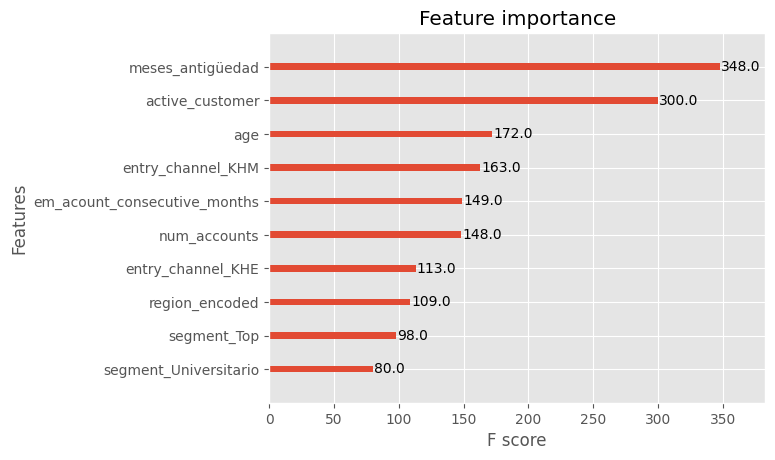

In [282]:
# Importancia de las variables
xgb.plot_importance(model_XGBoost, max_num_features=10)
plt.show()

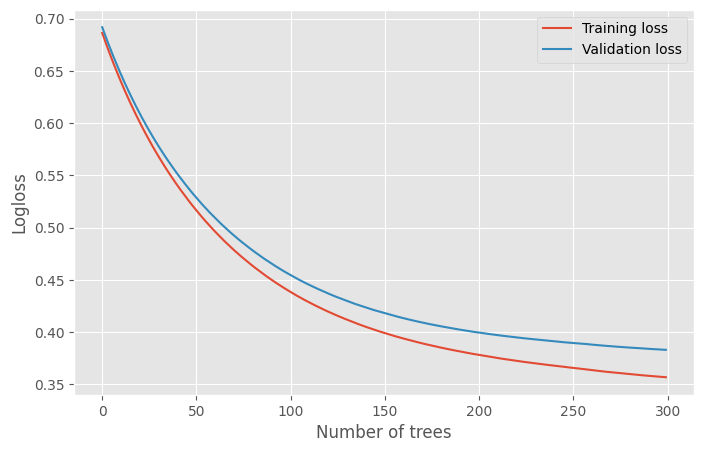

In [283]:
grafica_perdidas(model_XGBoost,"validation_0","validation_1","logloss")

In [285]:
# obtenemos las probabilidades y las predicciones de compra a partir del mejor modelo tras el grid search cross validation

y_test_pred_xgb = pd.DataFrame(model_XGBoost.predict(X_test), index = y_test.index, columns = ['Compra_predict'])
y_pred_proba_xgb = model_XGBoost.predict_proba(X_test)[:,1]

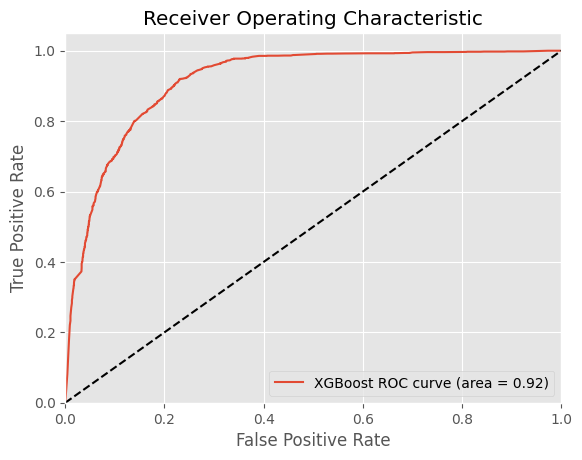

In [286]:
curva_roc_auc(y_test,y_pred_proba_xgb,'XGBoost')

In [288]:
resumen_xgb = dataframe_resumen(y_test,y_test_pred_xgb,y_pred_proba_xgb,producto)
resumen_xgb

,Compra_debit_card,Compra_predict,Success,Probabilidad_compra_debit_card
cid,,,,
1451798,1,1,1,0.768523
1104047,1,1,1,0.606479
1443548,1,1,1,0.749364
1443226,1,1,1,0.848611
866793,1,1,1,0.695539
...,...,...,...,...
1540186,1,1,1,0.928899
1540192,1,1,1,0.928899
1540238,1,1,1,0.929860


In [290]:
resumen_metricas(model_XGBoost,y_test,y_test_pred_xgb,X_train,y_train,X_validation,y_validation,X_test)

              precision    recall  f1-score   support

           0       0.92      0.76      0.83      2394
           1       0.77      0.92      0.84      2049

    accuracy                           0.84      4443
   macro avg       0.84      0.84      0.83      4443
weighted avg       0.85      0.84      0.83      4443

Accuracy: 0.8350 

El score en train es de: 0.8458191311915295
El score en validation es de: 0.8206288170097263
El score en test es de: 0.8350213819491334


<a id='LightGBM'></a>
## LightGBM
[Volver al índice](#index)

En este apartado utilizamos el modelo LightGBM, que se caracteriza por ser un algoritmo de boosting basado en gradientes, diseñado para entrenar de manera rápida y eficiente, incluso en datasets grandes. Su ventaja radica en la forma en que divide los datos, lo que acelera el proceso de entrenamiento sin perder precisión. Se ajustan hiperparámetros como el número de iteraciones, la tasa de aprendizaje, el número de hojas y la profundidad para mejorar su rendimiento. El modelo es evaluado a través de métricas como el accuracy, la curva ROC-AUC, y la gráfica de pérdidas, asegurando así un equilibrio entre la precisión y la eficiencia del modelo.

In [293]:
modelo_lgb = lgb.LGBMClassifier(objective="binary", random_state=44)

In [294]:
# Ajustar los parámetros para el Grid Search
params_lgb = {
    "num_leaves": [20, 31, 40],
    "max_depth": [5, 7, 10],
    "learning_rate": [0.01, 0.03, 0.1],
    "n_estimators": [100, 200, 300],
}

# Configurar Grid Search con Validación Cruzada
grid_search_lgb = model_selection.GridSearchCV(estimator=modelo_lgb, 
                                           param_grid=params_lgb, 
                                           cv=5, scoring='accuracy', 
                                           n_jobs=-1, verbose=1)

# Entrenar usando Grid Search
grid_search_lgb.fit(X_train, y_train)

# Mejor combinación de parámetros
print("Best parameters found: ", grid_search_lgb.best_params_)

Fitting 5 folds for each of 81 candidates, totalling 405 fits


c:\Users\USUARIO\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\preprocessing\_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\USUARIO\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\preprocessing\_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Info] Number of positive: 7287, number of negative: 6502
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000449 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 567
[LightGBM] [Info] Number of data points in the train set: 13789, number of used features: 27
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.528465 -> initscore=0.113982
[LightGBM] [Info] Start training from score 0.113982
Best parameters found:  {'learning_rate': 0.01, 'max_depth': 10, 'n_estimators': 300, 'num_leaves': 20}


In [295]:
model_LGB = grid_search_lgb.best_estimator_

In [296]:
model_LGB.fit(
    X_train, 
    y_train, 
    eval_set = [(X_train, y_train), (X_validation, y_validation)]
)

[LightGBM] [Info] Number of positive: 7287, number of negative: 6502
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000754 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 567
[LightGBM] [Info] Number of data points in the train set: 13789, number of used features: 27
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.528465 -> initscore=0.113982
[LightGBM] [Info] Start training from score 0.113982


c:\Users\USUARIO\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\preprocessing\_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\USUARIO\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\preprocessing\_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
c:\Users\USUARIO\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\preprocessing\_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


LGBMClassifier(learning_rate=0.01, max_depth=10, n_estimators=300,
               num_leaves=20, objective='binary', random_state=44)

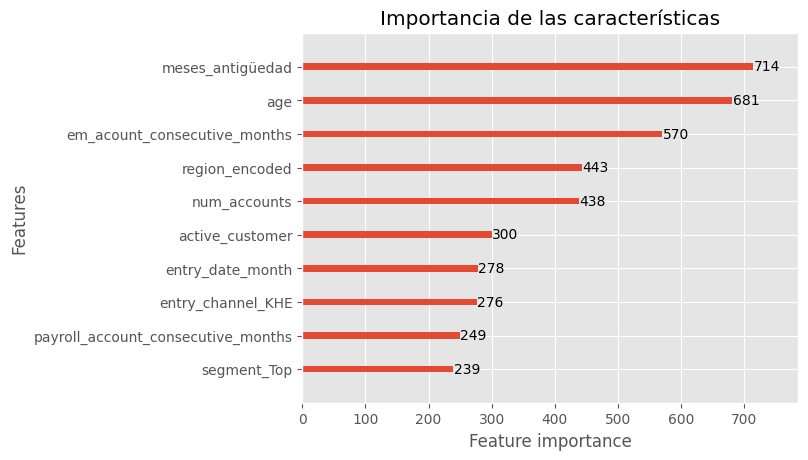

In [297]:
# Importancia de las variables
lgb.plot_importance(model_LGB, max_num_features=10)
plt.title("Importancia de las características")
plt.show()

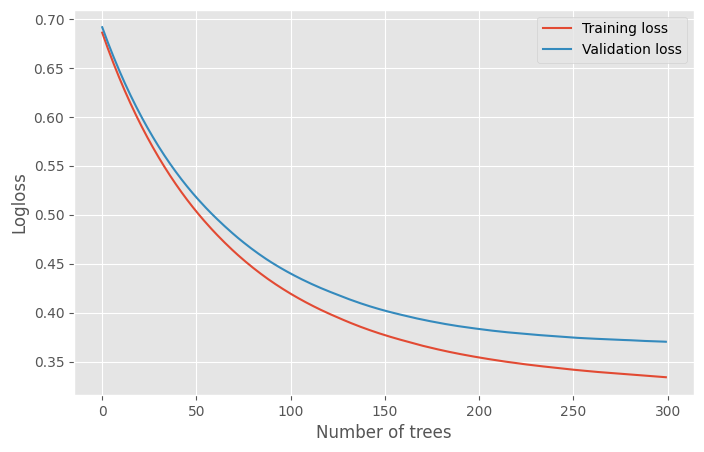

In [298]:
grafica_perdidas(model_LGB,'training','valid_1','binary_logloss')

In [300]:
# obtenemos las probabilidades y las predicciones de compra a partir del mejor modelo tras el grid search cross validation

y_test_pred_lgb = pd.DataFrame(model_LGB.predict(X_test), index = y_test.index, columns = ['Compra_predict'])
y_pred_proba_lgb = model_LGB.predict_proba(X_test)[:,1]

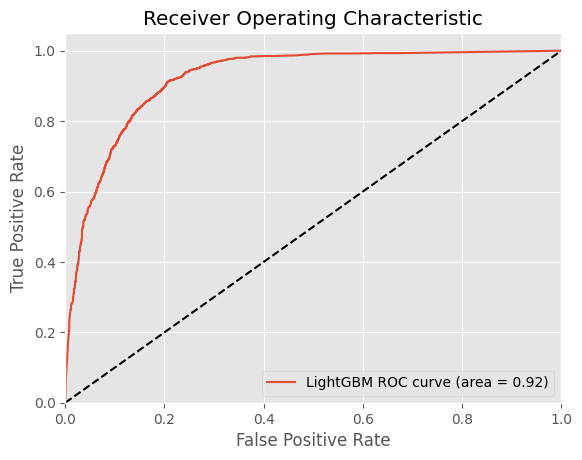

In [301]:
curva_roc_auc(y_test,y_pred_proba_lgb,'LightGBM')

In [333]:
resumen_lgb = dataframe_resumen(y_test,y_test_pred_lgb,y_pred_proba_lgb,producto)
resumen_lgb

,Compra_debit_card,Compra_predict,Success,Probabilidad_compra_debit_card
cid,,,,
1451798,1,1,1,0.776852
1104047,1,1,1,0.553422
1443548,1,1,1,0.769331
1443226,1,1,1,0.881143
866793,1,1,1,0.709977
...,...,...,...,...
1540186,1,1,1,0.944303
1540192,1,1,1,0.944303
1540238,1,1,1,0.944989


In [305]:
resumen_metricas(model_LGB,y_test,y_test_pred_lgb,X_train,y_train,X_validation,y_validation,X_test)

              precision    recall  f1-score   support

           0       0.92      0.78      0.84      2394
           1       0.78      0.92      0.84      2049

    accuracy                           0.84      4443
   macro avg       0.85      0.85      0.84      4443
weighted avg       0.85      0.84      0.84      4443

Accuracy: 0.8424 

El score en train es de: 0.8595257088983973
El score en validation es de: 0.8299027369373445
El score en test es de: 0.8424487958586541


<a id='CatBoost'></a>
## CatBoost
[Volver al índice](#index)

En este apartado utilizamos el modelo CatBoost, que se caracteriza por ser especialmente adecuado para trabajar con variables categóricas, lo que lo convierte en una excelente opción cuando se trabaja con este tipo de datos sin necesidad de preprocesamiento intensivo. Es por ello que realizamos un muestreo diferente al resto de modelos.

Los hiperparámetros ajustados incluyen tasa de aprendizaje, la profundidad y early_stopping_rounds que son claves para lograr un buen rendimiento. La evaluación se realiza observando el accuracy, la curva ROC-AUC y la función de pérdidas, asegurando que el modelo no solo sea preciso, sino también eficiente en términos de manejo de datos categóricos.

In [308]:
df_cat_procesado.info()

<class 'pandas.core.frame.DataFrame'>
Index: 22653 entries, 1517558 to 1546388
Data columns (total 17 columns):
 #   Column                              Non-Null Count  Dtype   
---  ------                              --------------  -----   
 0   gender                              22653 non-null  object  
 1   age                                 22653 non-null  float64 
 2   salary                              22653 non-null  float64 
 3   entry_channel                       22653 non-null  category
 4   active_customer                     22653 non-null  int32   
 5   segment                             22653 non-null  object  
 6   entry_date_month                    22653 non-null  float64 
 7   tipo_cliente                        22653 non-null  object  
 8   Compra_debit_card                   22653 non-null  int64   
 9   em_acount_consecutive_months        22653 non-null  float64 
 10  payroll_consecutive_months          22653 non-null  float64 
 11  payroll_account_consecuti

In [309]:
# comenzamos incorporando la columna pk_partition que nos permitirá dividir el dataframe en train, test y validation según los meses
df_cat_procesado = df_cat_procesado.reset_index()

incorporar_fechas = df_fechas[['cid','pk_partition']]
df_final1 = pd.merge(df_cat_procesado,incorporar_fechas,on='cid',how='left')
df_final1[categoricas] = df_final1[categoricas].astype('category')

df_final1.set_index('cid', inplace=True)

df_final1.head()

,gender,age,salary,entry_channel,active_customer,segment,entry_date_month,tipo_cliente,Compra_debit_card,em_acount_consecutive_months,payroll_consecutive_months,payroll_account_consecutive_months,emc_account_consecutive_months,has_easyMoney_account,num_accounts,meses_antigüedad,region_encoded,pk_partition
cid,,,,,,,,,,,,,,,,,,
1517558,V,0.632618,-0.307488,KHN,1,Particulares,1.307894,Cliente_existente,1,-0.710352,-0.20414,-0.262731,-0.209883,1,0.227617,-1.054340,1.939935,2019-01-01
1161959,H,-0.558602,-0.109460,KAT,0,Universitario,0.184376,Cliente_existente,0,1.030839,-0.20414,-0.262731,-0.209883,1,0.227617,0.878981,-0.181164,2019-01-01
1100492,H,-0.796846,-0.130175,KHE,0,Universitario,1.027014,Cliente_existente,0,1.030839,-0.20414,-0.262731,-0.209883,1,0.227617,1.500405,0.942360,2019-01-01
1391462,V,1.188520,0.044452,KHN,0,Top,-0.939141,Cliente_existente,1,-1.026933,-0.20414,-0.262731,-0.209883,0,-1.972128,-0.501963,0.901857,2019-01-01
1391434,V,1.823838,-0.307488,KHK,1,Particulares,-0.939141,Cliente_existente,1,-1.026933,-0.20414,0.165599,-0.209883,0,0.227617,-0.501963,-0.920194,2019-01-01


In [310]:
X_train1,y_train1= particion_dataset(df_final1,'train','2019-01-01','2019-04-01')

Porcentaje de train sobre el dataset completo: 60.87% 

train va desde 2019-01-01 00:00:00 hasta 2019-03-01 00:00:00 

Tamaño de X_{nombre}:  (13789, 16)
Tamaño de y_{nombre}:  (13789, 1)


In [311]:
X_validation1,y_validation1 = particion_dataset(df_final1,'validation','2019-04-01','2019-05-01')

Porcentaje de validation sobre el dataset completo: 19.52% 

validation va desde 2019-04-01 00:00:00 hasta 2019-04-01 00:00:00 



Tamaño de X_{nombre}:  (4421, 16)
Tamaño de y_{nombre}:  (4421, 1)


In [312]:
X_test1,y_test1 = particion_dataset(df_final1,'test','2019-05-01','2019-06-01')

Porcentaje de test sobre el dataset completo: 19.61% 

test va desde 2019-05-01 00:00:00 hasta 2019-05-01 00:00:00 

Tamaño de X_{nombre}:  (4443, 16)
Tamaño de y_{nombre}:  (4443, 1)


In [313]:
model_cat = cat.CatBoostClassifier(
    iterations=500,
    random_seed=44,
    loss_function='Logloss',
    cat_features=['gender', 'segment', 'entry_channel', 'tipo_cliente']
)

In [314]:
# Ajustar los parámetros para el Grid Search
#params_cat = {
#    "learning_rate": [0.005,0.01, 0.1],
#    "depth": [5, 6, 7],
#    "early_stopping_rounds": [20, 50, 70]
#}

# Configurar Grid Search con Validación Cruzada
#grid_search_cat = model_selection.GridSearchCV(estimator=model_cat, 
#                                           param_grid=params_cat, 
#                                           cv=5, scoring='accuracy', 
#                                           n_jobs=-1, verbose=1)

# Entrenar usando Grid Search
#grid_search_cat.fit(X_train1, y_train1)

# Mejor combinación de parámetros
#print("Best parameters found: ", grid_search_cat.best_params_)
#print("Best score found: ", grid_search_cat.best_score_)

In [315]:
#model_cat = grid_search_cat.best_estimator_

In [316]:
model_cat = cat.CatBoostClassifier(
    iterations=500,
    random_seed=44,
    loss_function='Logloss',
    cat_features=['gender', 'segment', 'entry_channel', 'tipo_cliente'],
    depth = 6,
    early_stopping_rounds = 20,
    learning_rate = 0.005 #0.01
)

In [317]:
model_cat.fit(
          X_train1,
          y_train1, 
          eval_set=[(X_train1, y_train1), (X_validation1, y_validation1)], 
          use_best_model=True,
          plot=True
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.6890282	test: 0.6890282	test1: 0.6891103	best: 0.6891103 (0)	total: 98.3ms	remaining: 49.1s
1:	learn: 0.6850137	test: 0.6850137	test1: 0.6852040	best: 0.6852040 (1)	total: 145ms	remaining: 36.1s
2:	learn: 0.6811415	test: 0.6811358	test1: 0.6814815	best: 0.6814815 (2)	total: 206ms	remaining: 34.2s
3:	learn: 0.6770158	test: 0.6770037	test1: 0.6774091	best: 0.6774091 (3)	total: 271ms	remaining: 33.5s
4:	learn: 0.6730096	test: 0.6729976	test1: 0.6735463	best: 0.6735463 (4)	total: 352ms	remaining: 34.8s
5:	learn: 0.6690666	test: 0.6690484	test1: 0.6697183	best: 0.6697183 (5)	total: 410ms	remaining: 33.8s
6:	learn: 0.6651561	test: 0.6651380	test1: 0.6659285	best: 0.6659285 (6)	total: 458ms	remaining: 32.2s
7:	learn: 0.6612085	test: 0.6611878	test1: 0.6621340	best: 0.6621340 (7)	total: 501ms	remaining: 30.8s
8:	learn: 0.6574443	test: 0.6574172	test1: 0.6584415	best: 0.6584415 (8)	total: 541ms	remaining: 29.5s
9:	learn: 0.6537725	test: 0.6537435	test1: 0.6548661	best: 0.6548661 (9)

In [318]:
# obtenemos las probabilidades y las predicciones de compra a partir del mejor modelo tras el grid search cross validation

y_test_pred_cat = pd.DataFrame(model_cat.predict(X_test1), index = y_test1.index, columns = ['Compra_predict'])
y_pred_proba_cat = model_cat.predict_proba(X_test1)[:, 1]

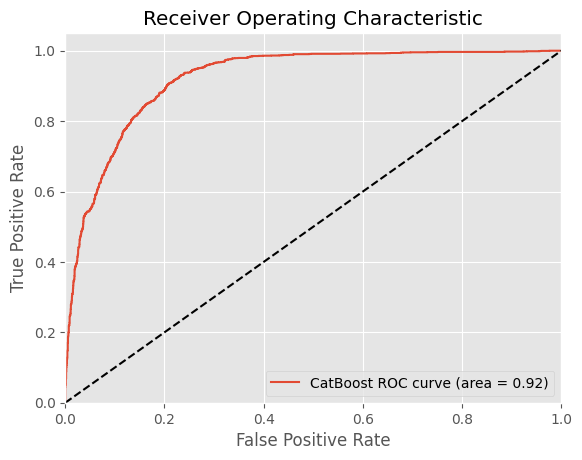

In [319]:
curva_roc_auc(y_test1,y_pred_proba_cat,'CatBoost')

In [334]:
resumen_cat = dataframe_resumen(y_test1,y_test_pred_cat,y_pred_proba_cat,producto)
resumen_cat

,Compra_debit_card,Compra_predict,Success,Probabilidad_compra_debit_card
cid,,,,
1451798,1,1,1,0.746707
1104047,1,1,1,0.606670
1443548,1,1,1,0.801532
1443226,1,1,1,0.918249
866793,1,1,1,0.733529
...,...,...,...,...
1540186,1,1,1,0.928263
1540192,1,1,1,0.927485
1540238,1,1,1,0.930532


In [323]:
resumen_metricas(model_cat,y_test1,y_test_pred_cat,X_train1,y_train1,X_validation1,y_validation1,X_test1)

              precision    recall  f1-score   support

           0       0.91      0.78      0.84      2394
           1       0.78      0.92      0.84      2049

    accuracy                           0.84      4443
   macro avg       0.85      0.85      0.84      4443
weighted avg       0.85      0.84      0.84      4443

Accuracy: 0.8431 

El score en train es de: 0.8543766770614257
El score en validation es de: 0.8312598959511422
El score en test es de: 0.8431240153049742


<a id='logistic'></a>
## Logistic Regresión
[Volver al índice](#index)

En este apartado utilizamos el modelo de Regresión Logística, que se caracteriza por ser un modelo lineal que estima la probabilidad de que un evento ocurra (en este caso, si un cliente comprará o no un producto). Este modelo es sencillo pero poderoso en problemas de clasificación binaria. La evaluación del modelo se lleva a cabo observando métricas como el accuracy, la curva ROC-AUC y la función de pérdidas, permitiendo analizar la capacidad del modelo para predecir correctamente y manejar desequilibrios en los datos.

In [326]:
log_reg = LogisticRegression(max_iter=1000,random_state=44)
log_reg.fit(X_train, y_train)

# Predicciones
y_pred_train = log_reg.predict(X_train)
y_pred_val = log_reg.predict(X_validation)

c:\Users\USUARIO\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


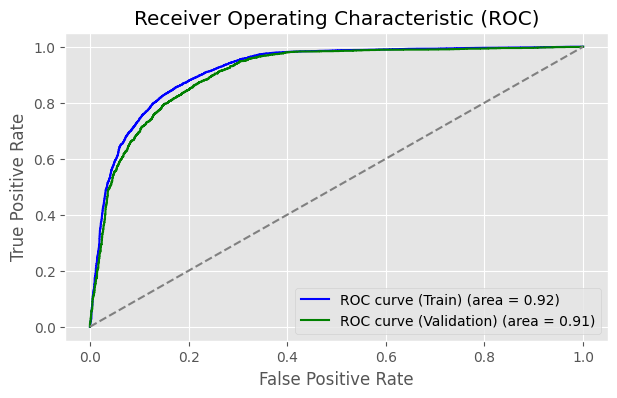

In [327]:
# Curva ROC para entrenamiento
fpr_train, tpr_train, _ = metrics.roc_curve(y_train, log_reg.predict_proba(X_train)[:, 1])
roc_auc_train = metrics.auc(fpr_train, tpr_train)

# Curva ROC para validación
fpr_val, tpr_val, _ = metrics.roc_curve(y_validation, log_reg.predict_proba(X_validation)[:, 1])
roc_auc_val = metrics.auc(fpr_val, tpr_val)

plt.figure(figsize=(7, 4))
plt.plot(fpr_train, tpr_train, color='blue', label=f'ROC curve (Train) (area = {roc_auc_train:.2f})')
plt.plot(fpr_val, tpr_val, color='green', label=f'ROC curve (Validation) (area = {roc_auc_val:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

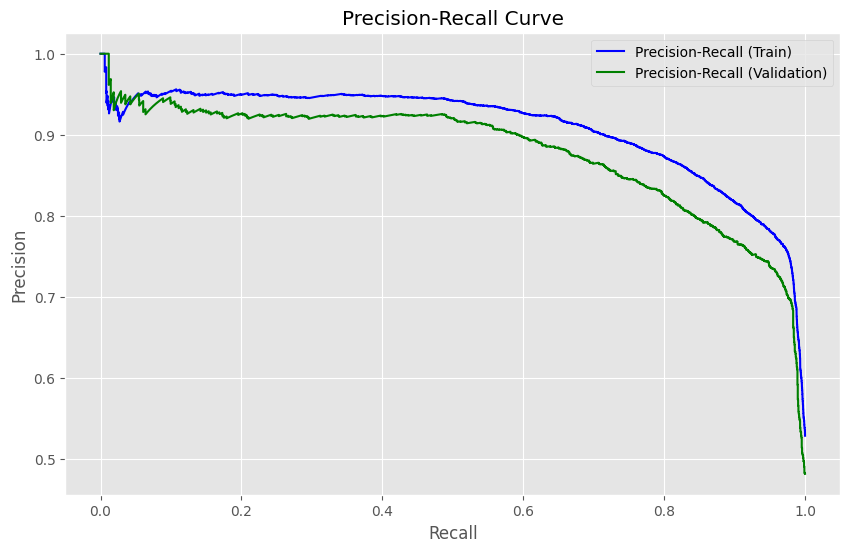

In [328]:
# Curva de precisión-recall para entrenamiento
precision_train, recall_train, _ = metrics.precision_recall_curve(y_train, log_reg.predict_proba(X_train)[:, 1])

# Curva de precisión-recall para validación
precision_val, recall_val, _ = metrics.precision_recall_curve(y_validation, log_reg.predict_proba(X_validation)[:, 1])

plt.figure(figsize=(10, 6))
plt.plot(recall_train, precision_train, color='blue', label='Precision-Recall (Train)')
plt.plot(recall_val, precision_val, color='green', label='Precision-Recall (Validation)')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="best")
plt.show()

In [329]:
# obtenemos las probabilidades y las predicciones de compra a partir del mejor modelo tras el grid search cross validation

y_test_pred_logistic = pd.DataFrame(log_reg.predict(X_test), index = y_test.index, columns = ['Compra_predict'])
y_pred_proba_logisic = log_reg.predict_proba(X_test)[:,1]

In [335]:
resumen_logistic = dataframe_resumen(y_test,y_test_pred_logistic,y_pred_proba_logisic,producto)
resumen_logistic

,Compra_debit_card,Compra_predict,Success,Probabilidad_compra_debit_card
cid,,,,
1451798,1,1,1,0.817087
1104047,1,1,1,0.523393
1443548,1,1,1,0.863394
1443226,1,1,1,0.938994
866793,1,1,1,0.918079
...,...,...,...,...
1540186,1,1,1,0.957122
1540192,1,1,1,0.991735
1540238,1,1,1,0.944245


In [332]:
resumen_metricas(log_reg,y_test,y_test_pred_logistic,X_train,y_train,X_validation,y_validation,X_test)

              precision    recall  f1-score   support

           0       0.86      0.83      0.84      2394
           1       0.81      0.84      0.82      2049

    accuracy                           0.83      4443
   macro avg       0.83      0.83      0.83      4443
weighted avg       0.83      0.83      0.83      4443

Accuracy: 0.8334 

El score en train es de: 0.8405250562042208
El score en validation es de: 0.822664555530423
El score en test es de: 0.83344586990772
